## Statistical Analysis of Stock Data

In this section, we will explore the statistical properties of the stock price data. The objectives are:
- Understand the trends and seasonality of stock prices.
- Compute key financial metrics like daily returns and volatility.
- Identify correlations between stocks from different industries.

Visualizations will help us uncover insights and relationships in the data.


## Downloading S&P 500 Stock Data

In this section, we will:
1. Retrieve the current list of S&P 500 companies from Wikipedia.
2. Use the `yfinance` library to download historical stock data for each company.
3. Ensure that the data spans from the year 2000 to the end of November 2024.

The downloaded data will include:
- Open, High, Low, Close, and Adjusted Close prices.
- Volume of shares traded.

This data will form the foundation for subsequent analyses, including returns, correlations, and predictive modeling.


In [8]:
import pandas as pd
import yfinance as yf
import os
from tqdm.notebook import tqdm

# Step 1: Retrieve S&P 500 tickers from Wikipedia
wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(wiki_url, header=0)[0]
tickers = sp500_table['Symbol'].tolist()

# Step 2: Replace periods with hyphens in ticker symbols
tickers = [ticker.replace('.', '-') for ticker in tickers]

# Step 3: Prepare the data download directory
data_dir = 'SP500_Historical_Data'
os.makedirs(data_dir, exist_ok=True)

# Step 4: Download historical data for each ticker with a progress bar
start_date = '2000-01-01'
end_date = '2024-11-30'

for ticker in tqdm(tickers, desc="Progress", unit="stock", leave=False):
    try:
        # Fetch data from Yahoo Finance
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        if not data.empty:
            # Save to CSV
            file_path = os.path.join(data_dir, f"{ticker}_adjusted.csv")
            data.to_csv(file_path)
    except Exception:
        # Skip errors silently
        continue

print("Download is completed.")


Progress:   0%|          | 0/503 [00:00<?, ?stock/s]

Download is completed.


## Descriptive Statistics for Selected Stocks

This section provides basic descriptive statistics for representative stocks from different industries:
- **IT**: AAPL
- **Energy**: XOM
- **Hybrid Cars**: TSLA
- **Gold**: NEM

The descriptive statistics include:
- Mean, Median, Standard Deviation, Minimum, Maximum, and Range for `Open`, `Close`, `High`, `Low`, `Adj Close`, and `Volume`.


In [16]:
import pandas as pd
import os
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

pd.set_option('display.float_format', '{:.2f}'.format)

# Define stock categories and tickers
stocks = {
    "IT": "AAPL",
    "Energy": "XOM",
    "Hybrid Cars": "TSLA",
    "Gold": "NEM"
}

# Directory where data is stored
data_dir = "SP500_Historical_Data"

def clean_stock_data(raw_data):
    # Skip the first two rows, which are metadata
    raw_data = raw_data.iloc[2:]  # Actual data starts at the third row
    
    # Reset column names to expected structure
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    
    # Convert 'Date' to datetime
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    
    # Convert other columns to numeric
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')
    
    # Drop rows with invalid dates or entirely NaN rows
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)
    return raw_data

# Function to clean and compute descriptive statistics
def compute_descriptive_stats(ticker):
    file_path = os.path.join(data_dir, f"{ticker}_adjusted.csv")
    raw_data = pd.read_csv(file_path)

    # Clean the data
    clean_data = clean_stock_data(raw_data)
    
    # Compute descriptive statistics
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    stats = clean_data[numeric_cols].describe().T  # Transpose for better readability
    stats['Range'] = stats['max'] - stats['min']
    return stats

# Compute stats for each selected stock
descriptive_tables = {}
for category, ticker in stocks.items():
    descriptive_tables[category] = compute_descriptive_stats(ticker)

# Display results
for category, table in descriptive_tables.items():
    print(f"Descriptive Statistics for {category} ({stocks[category]}):\n")
    print(table, "\n")


Descriptive Statistics for IT (AAPL):

            count         mean          std         min          25%  \
Open      6268.00        42.00        59.32        0.23         2.39   
High      6268.00        42.45        59.94        0.24         2.40   
Low       6268.00        41.58        58.74        0.23         2.33   
Close     6268.00        42.03        59.38        0.23         2.37   
Adj Close 6268.00        40.60        59.11        0.20         2.00   
Volume    6268.00 387057489.18 383870286.33 24048300.00 116828100.00   

                   50%          75%           max         Range  
Open             16.11        45.90        236.48        236.25  
High             16.27        46.24        237.81        237.57  
Low              15.89        45.36        234.45        234.22  
Close            16.07        45.94        237.33        237.10  
Adj Close        13.75        43.73        237.33        237.13  
Volume    269214400.00 519582000.00 7421640800.00 7397592500

## Time Series Visualization: Prices and Volumes

In this section, we visualize the **prices** and **volumes** for the selected stocks over time. The variables include:

- **Open**: The stock's price at the beginning of the trading session.
- **High**: The highest price reached during the trading session.
- **Low**: The lowest price reached during the trading session.
- **Close**: The stock's price at the end of the trading session.
- **Adj Close (Adjusted Close)**: The stock's closing price adjusted for any corporate actions, such as dividends, stock splits, or new stock issuance. It represents the "true value" of a stock considering these adjustments and is often used for historical analysis.
- **Volume**: The total number of shares traded during the trading session.

The time series plots below provide insights into how these variables evolve over time for the selected stocks.


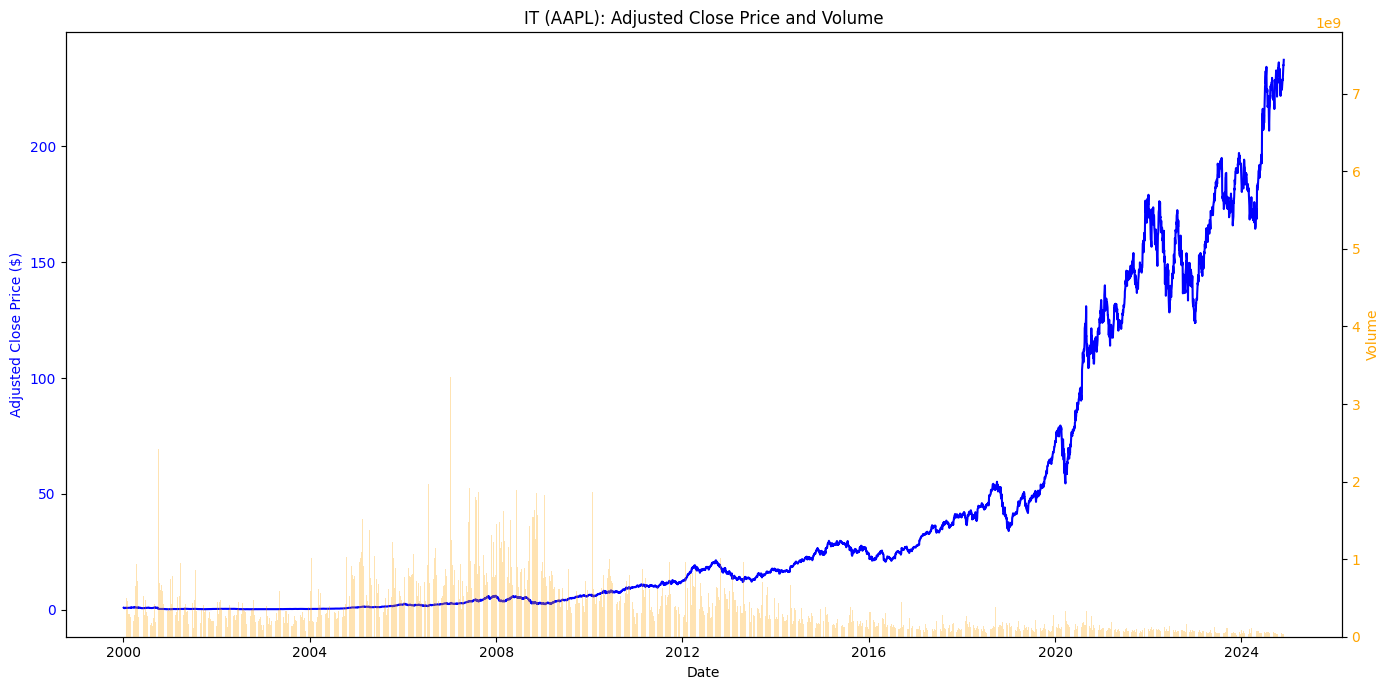

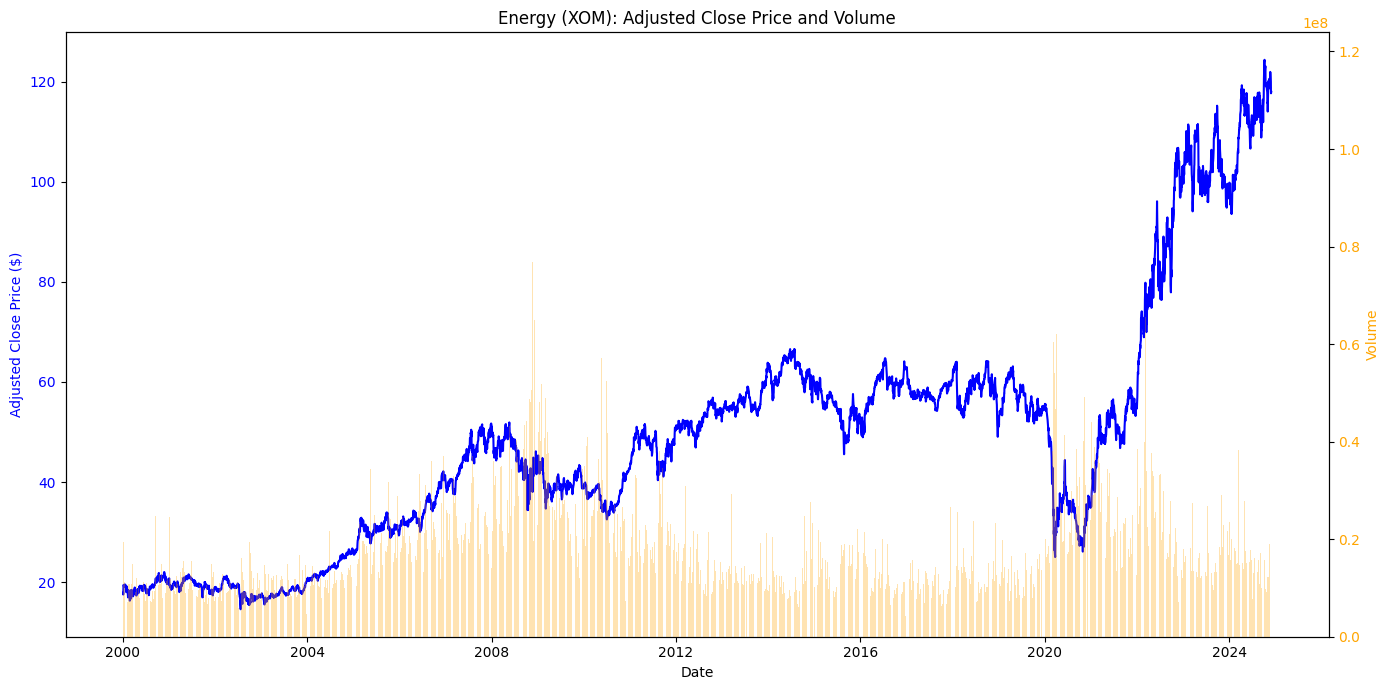

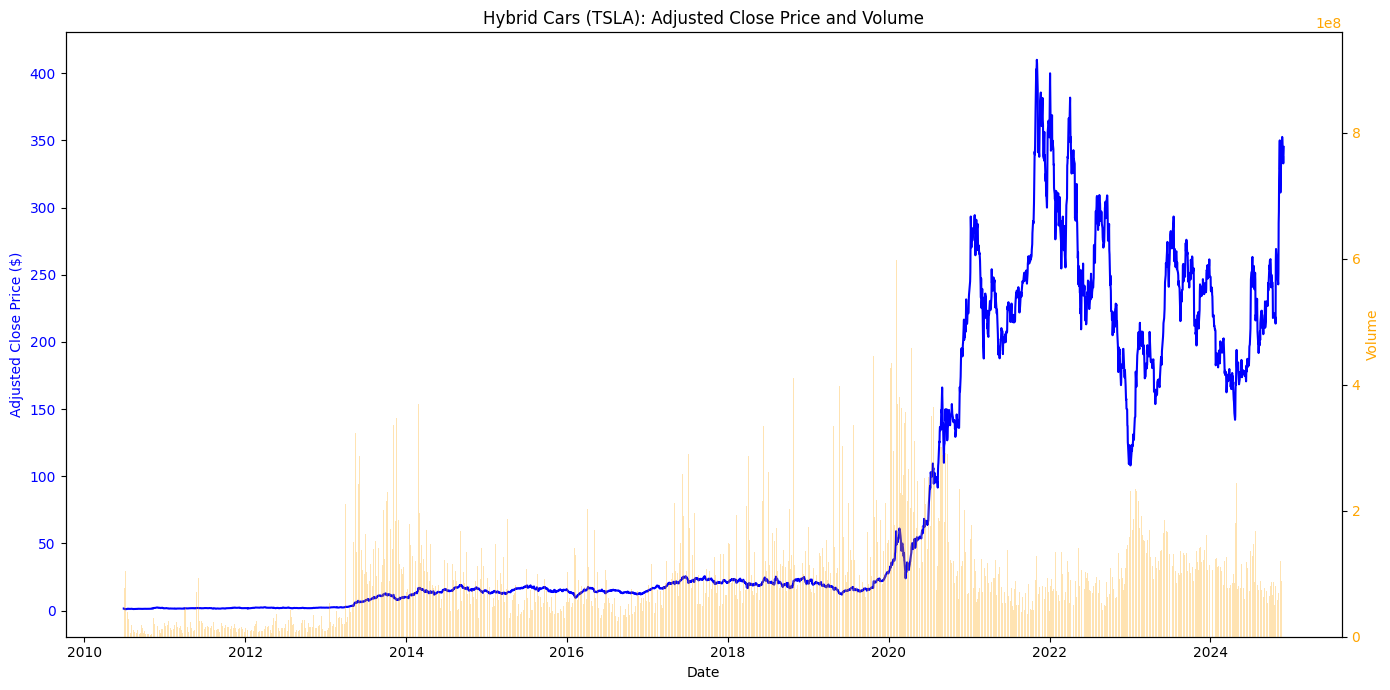

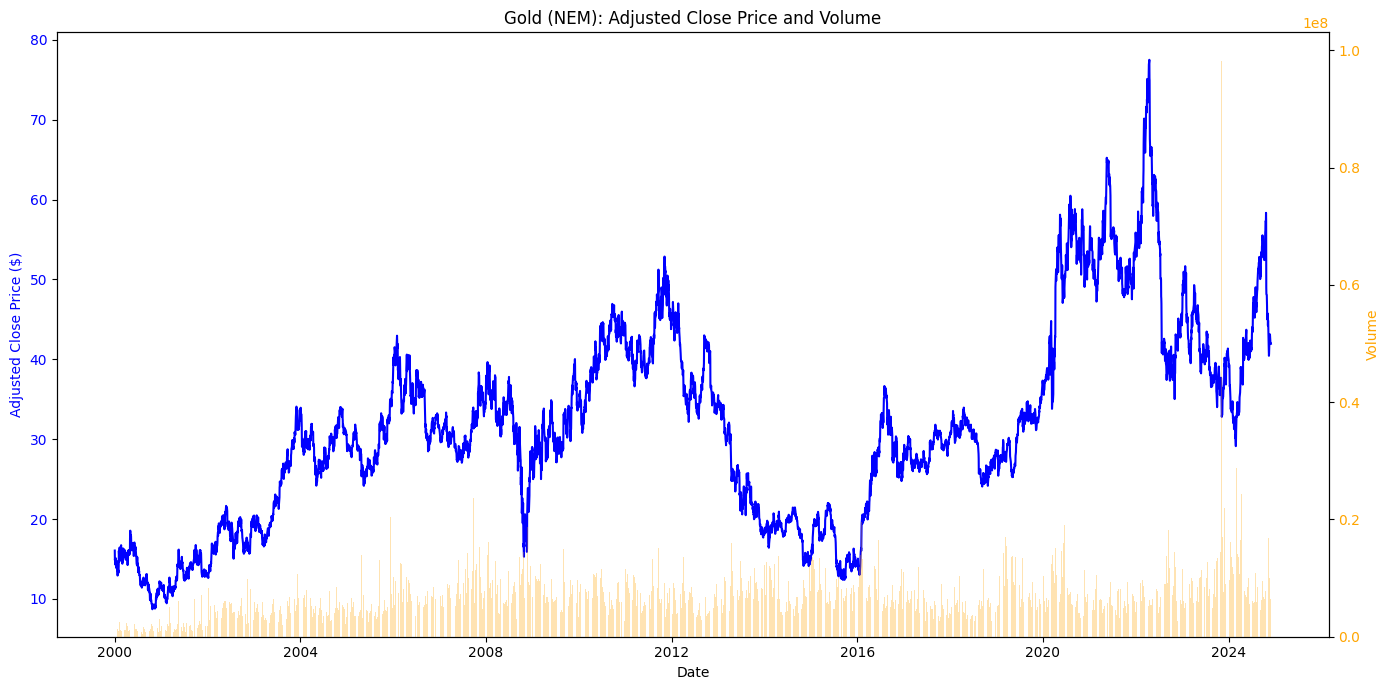

In [18]:
import matplotlib.pyplot as plt

# Define a function to plot prices and volumes
def plot_stock_time_series(ticker, category):
    # Load and clean data
    file_path = os.path.join(data_dir, f"{ticker}_adjusted.csv")
    raw_data = pd.read_csv(file_path)
    clean_data = clean_stock_data(raw_data)
    
    # Plot prices and volume
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot Adjusted Close on primary y-axis
    ax1.plot(clean_data['Date'], clean_data['Adj Close'], label='Adj Close', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price ($)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Plot Volume on secondary y-axis
    ax2 = ax1.twinx()
    ax2.bar(clean_data['Date'], clean_data['Volume'], label='Volume', color='orange', alpha=0.3, width=1.0)
    ax2.set_ylabel('Volume', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Add title and legend
    plt.title(f"{category} ({ticker}): Adjusted Close Price and Volume")
    fig.tight_layout()
    plt.show()

# Plot for each selected stock
for category, ticker in stocks.items():
    plot_stock_time_series(ticker, category)


## Moving Averages in Stock Analysis

**Moving averages** (MAs) are widely used in stock market analysis to smooth out price data and identify trends over a specific period. They are calculated by averaging a stock's prices over a given time window, which "moves" as new prices become available.

### Types of Moving Averages
1. **Simple Moving Average (SMA)**:
   - Calculated by taking the arithmetic mean of the stock prices over a specific period.
   - Formula:
     \[
     SMA_t = \frac{P_{t} + P_{t-1} + \ldots + P_{t-n+1}}{n}
     \]
     where \( P_t \) is the price at time \( t \), and \( n \) is the moving average window.

2. **Exponential Moving Average (EMA)**:
   - Places more weight on recent prices, making it more responsive to recent price changes.
   - Commonly used for faster-moving signals.

---

### Moving Average Crossover Strategy
A **moving average crossover** is one of the most traditional methods for identifying market trends:
1. **Fast Moving Average**:
   - A shorter-period MA (e.g., 20 days) that reacts quickly to price changes.
2. **Slow Moving Average**:
   - A longer-period MA (e.g., 50 or 100 days) that reacts more slowly.

#### How It Works:
- **Bullish Signal (Golden Cross)**:
  - Occurs when the fast MA crosses above the slow MA.
  - Indicates a potential upward trend.
- **Bearish Signal (Death Cross)**:
  - Occurs when the fast MA crosses below the slow MA.
  - Indicates a potential downward trend.

Moving averages are often plotted alongside price data to visualize these crossovers and assess the stock's trend.

---

### Plot: Moving Averages with 20, 50, and 100 Days
Below, we plot the **price** and three simple moving averages (20, 50, and 100 days) for the selected stocks.


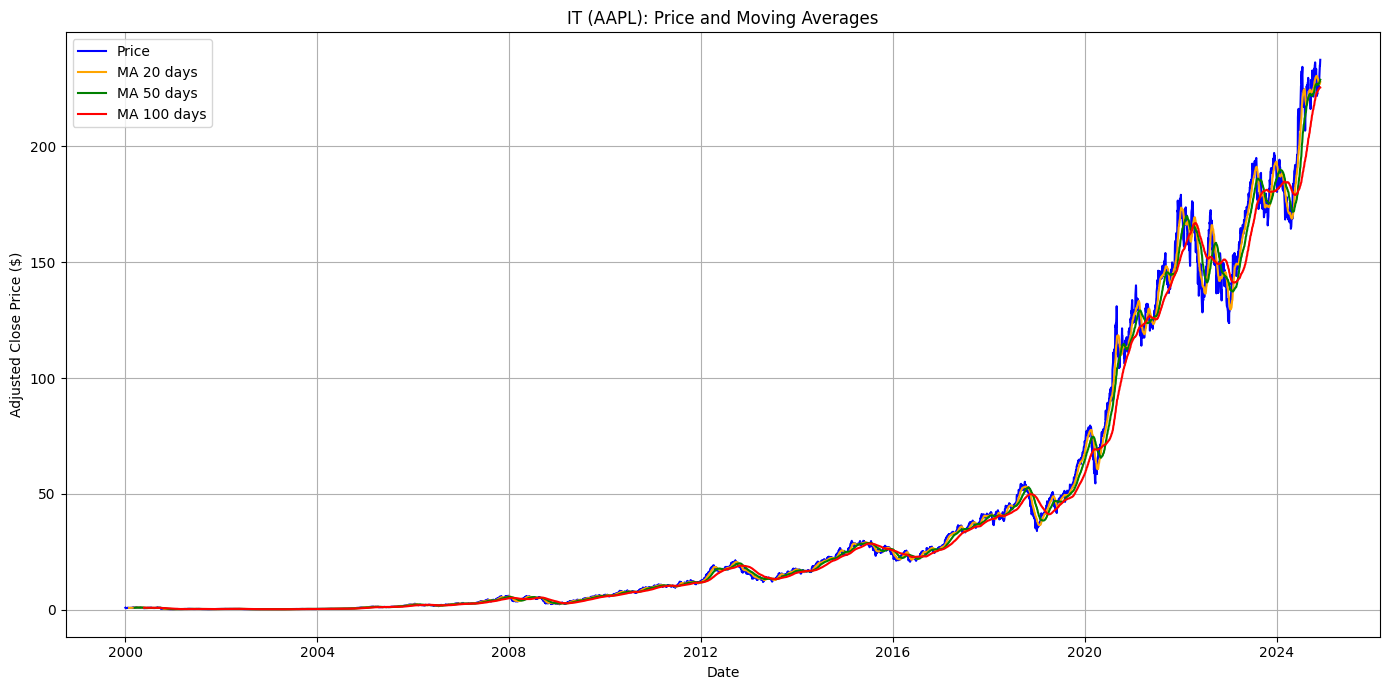

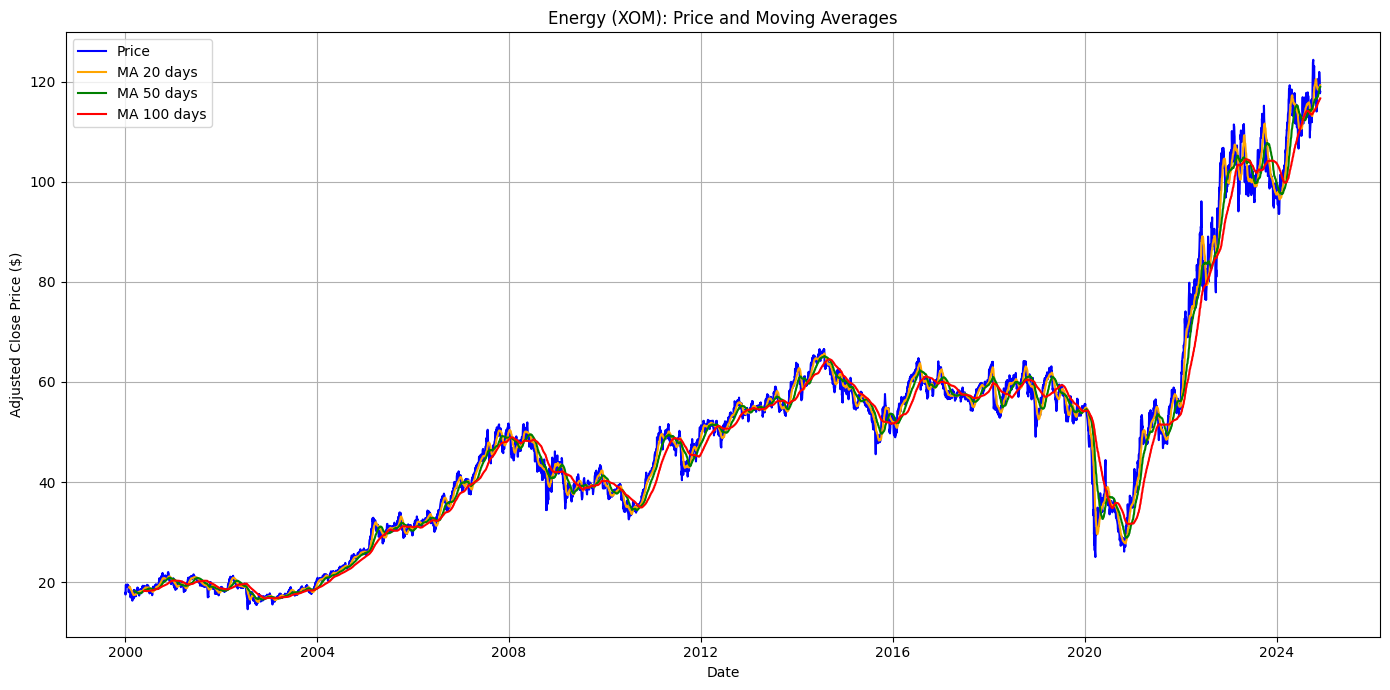

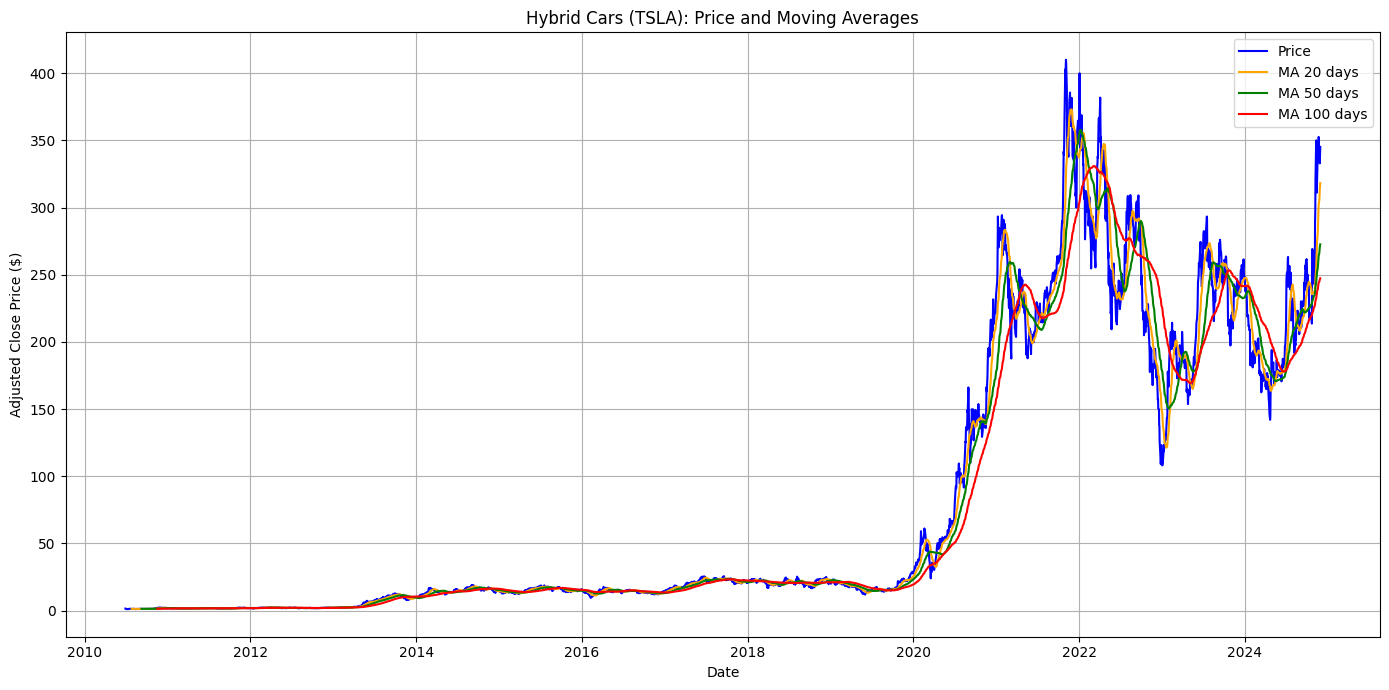

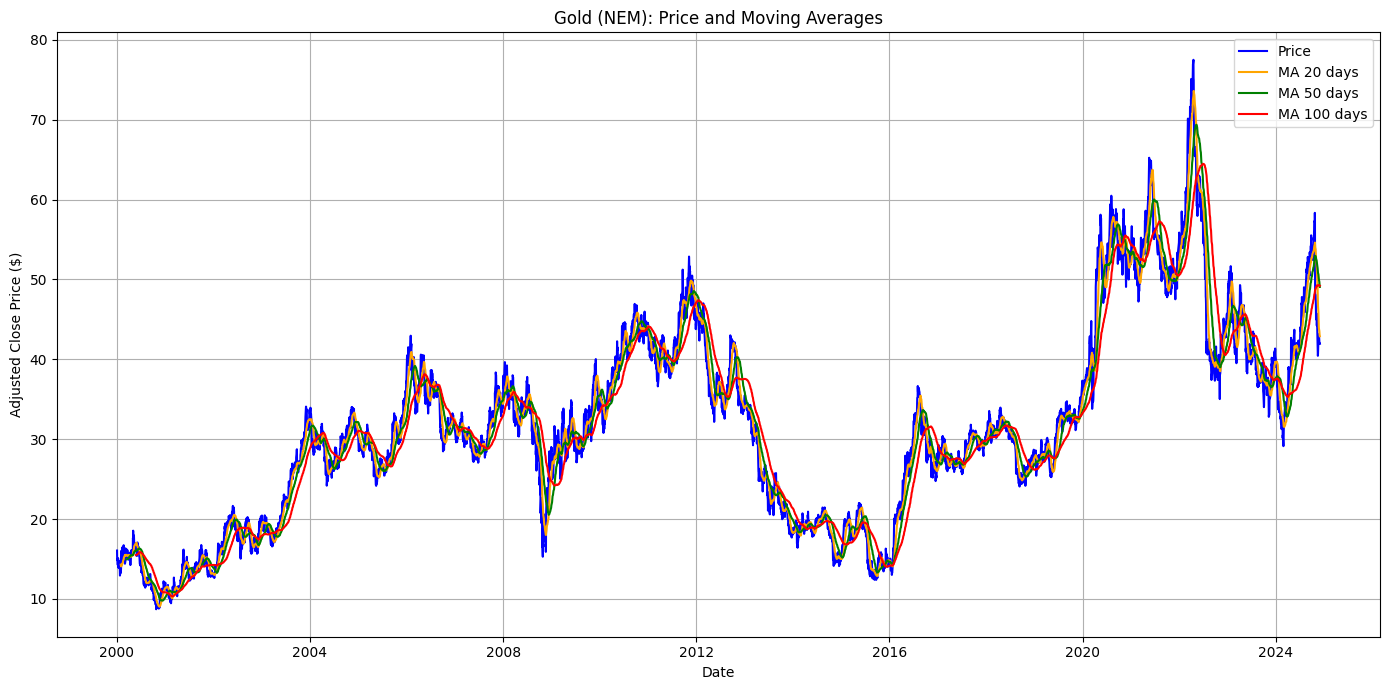

In [20]:
def plot_moving_averages(ticker, category):
    # Load and clean data
    file_path = os.path.join(data_dir, f"{ticker}_adjusted.csv")
    raw_data = pd.read_csv(file_path)
    clean_data = clean_stock_data(raw_data)
    
    # Calculate moving averages
    clean_data['MA_20'] = clean_data['Adj Close'].rolling(window=20).mean()
    clean_data['MA_50'] = clean_data['Adj Close'].rolling(window=50).mean()
    clean_data['MA_100'] = clean_data['Adj Close'].rolling(window=100).mean()
    
    # Plot price and moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(clean_data['Date'], clean_data['Adj Close'], label='Price', color='blue')
    plt.plot(clean_data['Date'], clean_data['MA_20'], label='MA 20 days', color='orange')
    plt.plot(clean_data['Date'], clean_data['MA_50'], label='MA 50 days', color='green')
    plt.plot(clean_data['Date'], clean_data['MA_100'], label='MA 100 days', color='red')
    
    # Add labels, title, and legend
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.title(f"{category} ({ticker}): Price and Moving Averages")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot for each selected stock
for category, ticker in stocks.items():
    plot_moving_averages(ticker, category)


## Understanding Logarithmic Returns in Stock Analysis

Logarithmic returns measure the proportional change in a stock's price from one day to the next using the natural logarithm. Unlike absolute price levels, which can vary widely between stocks, log returns standardize price movements, allowing for easier comparison across assets.

---

### Definition of Logarithmic Returns

The formula for calculating logarithmic returns is:

\[
R_{\text{log},t} = \ln\left(\frac{P_t}{P_{t-1}}\right)
\]

Where:
- \( R_{\text{log},t} \): Logarithmic return on day \( t \)
- \( P_t \): Price on day \( t \)
- \( P_{t-1} \): Price on the previous day

Logarithmic returns are preferred over regular percentage returns in many analyses due to their statistical advantages.

---

### Why Analyze Logarithmic Returns?

1. **Comparability**:
   - Logarithmic returns allow for direct comparison between stocks, regardless of their absolute price levels.

2. **Variance Stabilization**:
   - Logarithmic returns reduce the impact of extreme outliers, making the data more stable and suitable for analysis.

3. **Additivity**:
   - Logarithmic returns are additive over time, making it easy to compute returns over multiple periods:
     \[
     \text{Total Log Return} = \sum_{t=1}^n R_{\text{log},t}
     \]

4. **Closer to Normality**:
   - Logarithmic returns tend to follow a distribution closer to normal (bell-shaped curve), especially over longer periods. This makes them suitable for statistical modeling and forecasting.

5. **Stationarity**:
   - Logarithmic returns are often stationary, meaning their statistical properties (mean, variance) remain constant over time.
   - Stationarity is a key assumption in many time series models, making log returns more predictable than prices.

---

### Visualization of Logarithmic Returns

Below, we calculate and plot:
1. The **time series of logarithmic returns** to show how they vary over time.
2. The **distribution of logarithmic returns** to assess their statistical properties for each selected ticker.


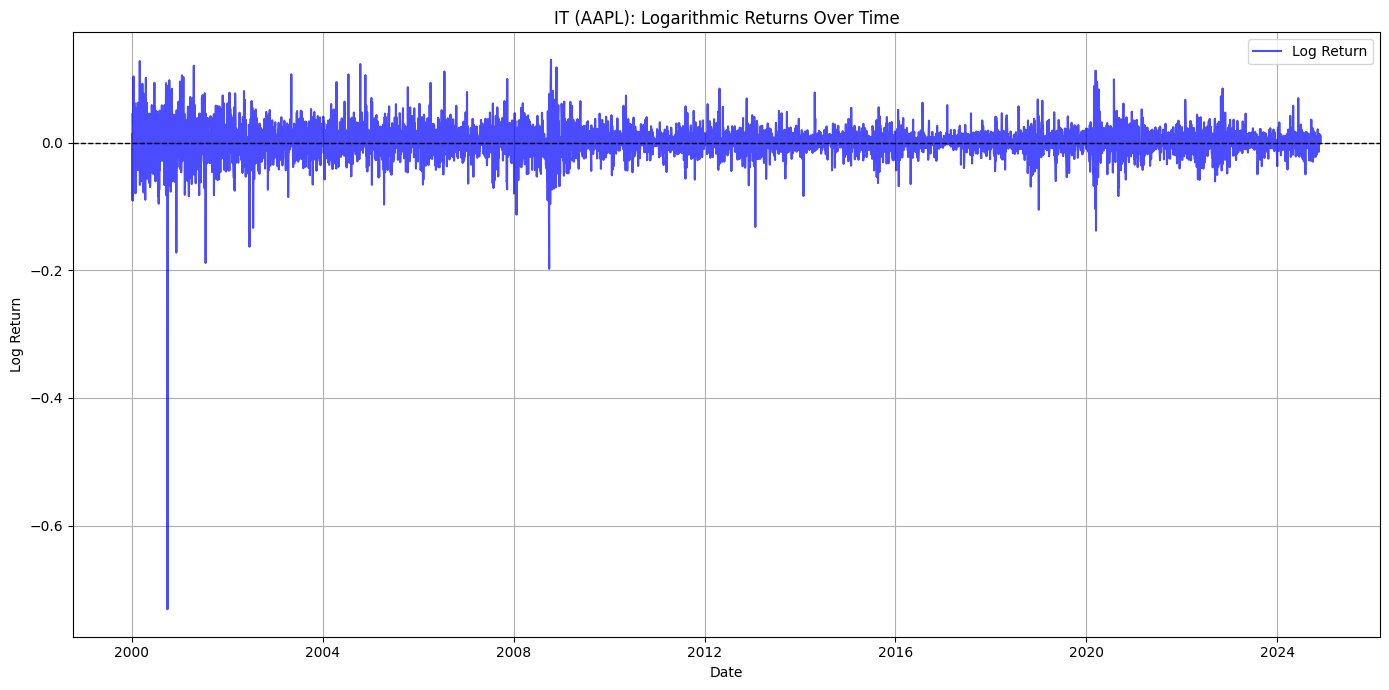

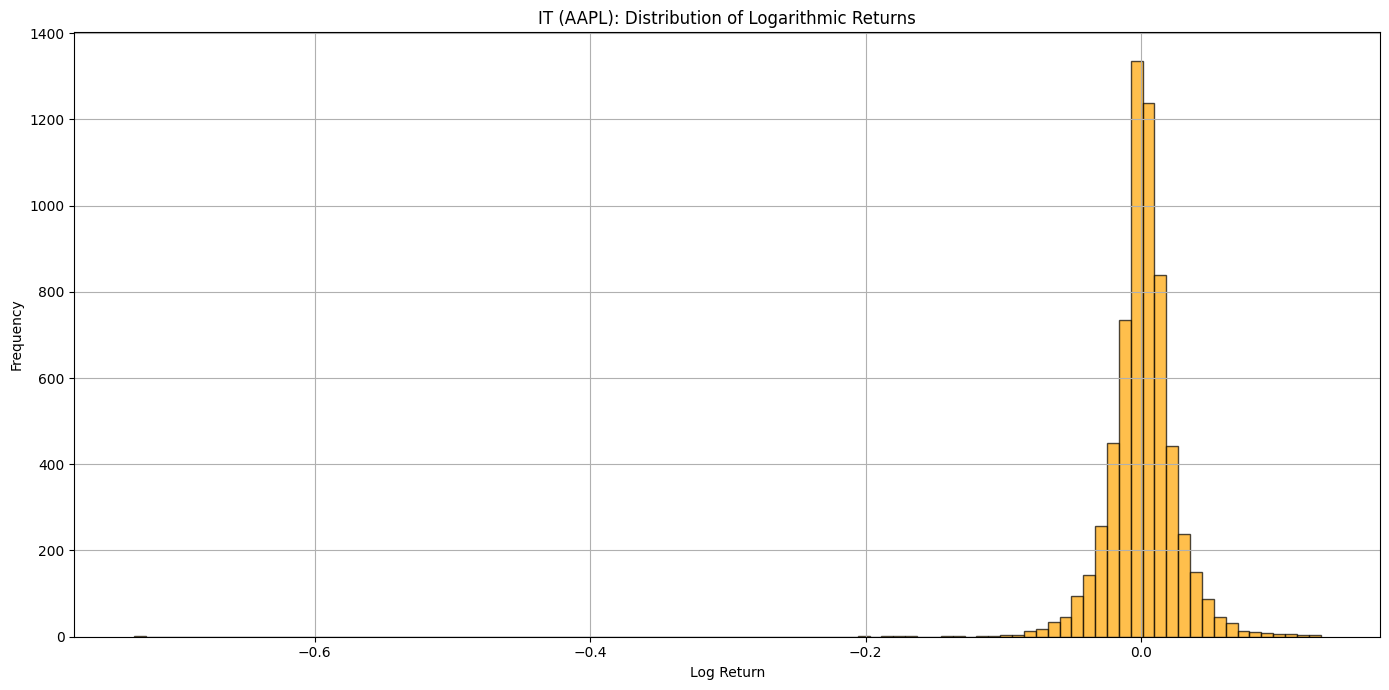

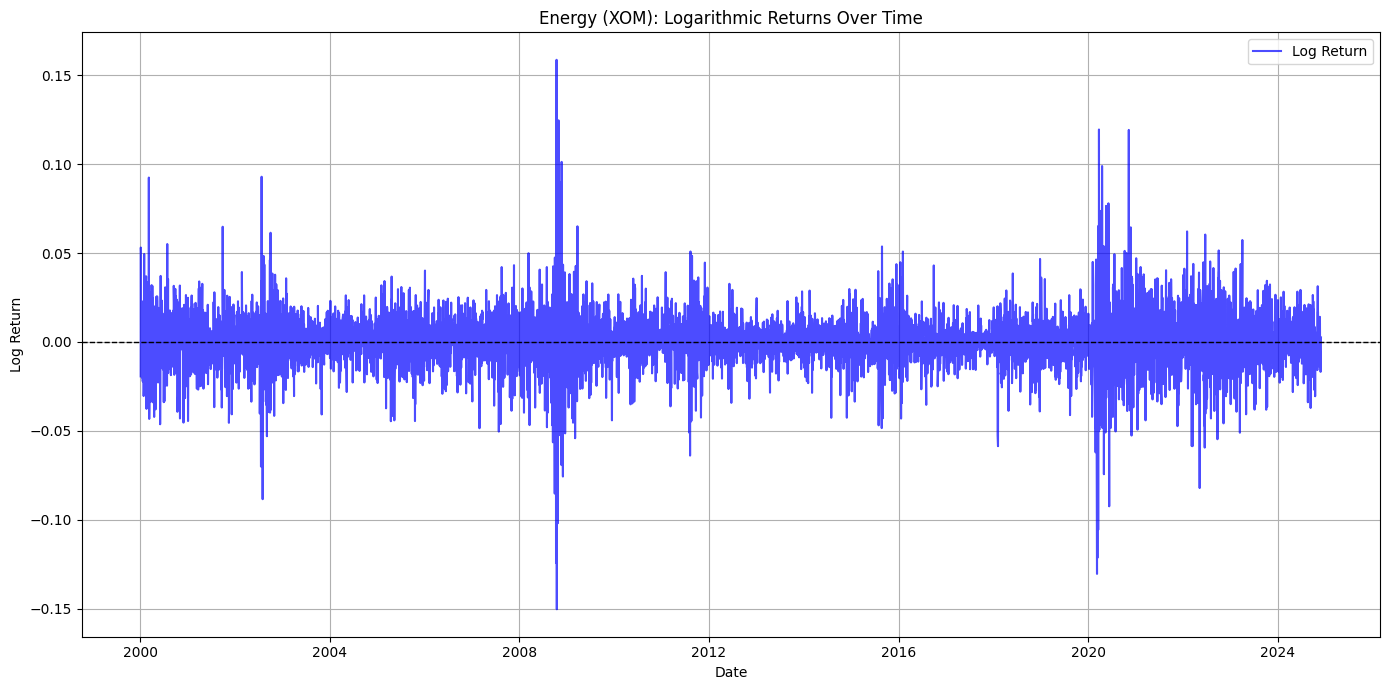

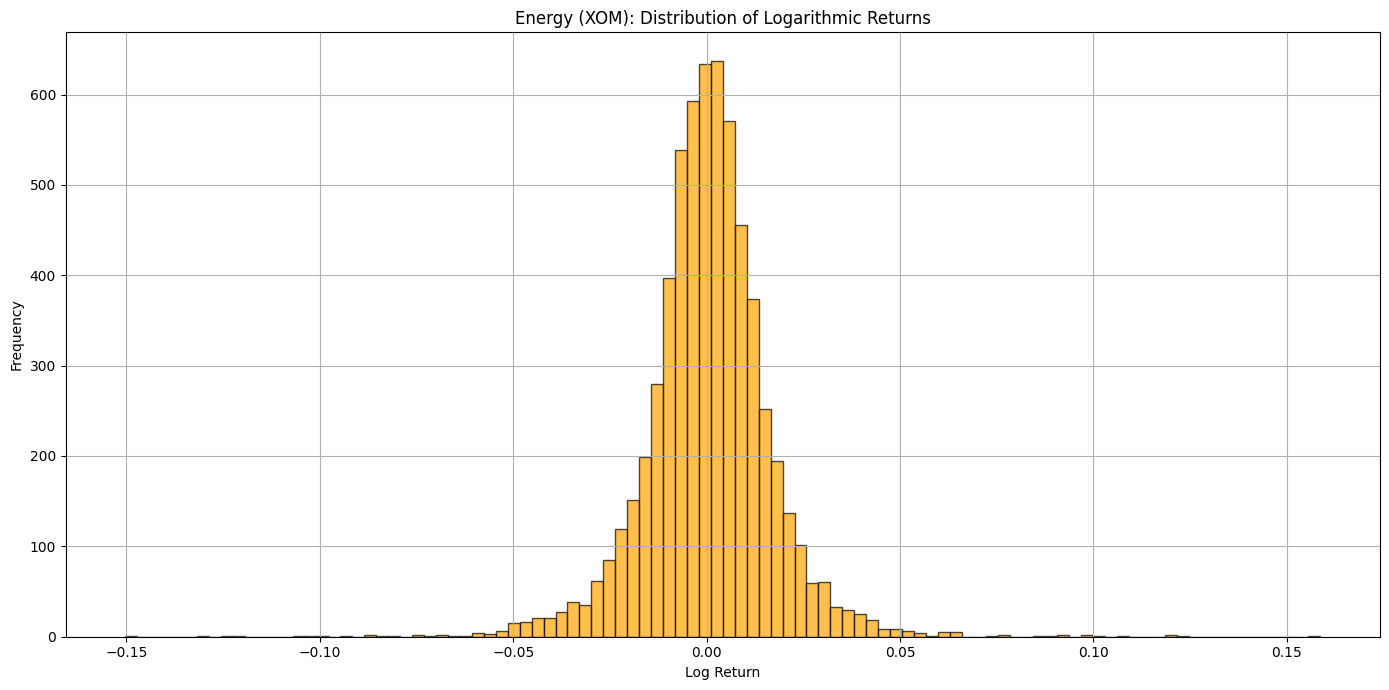

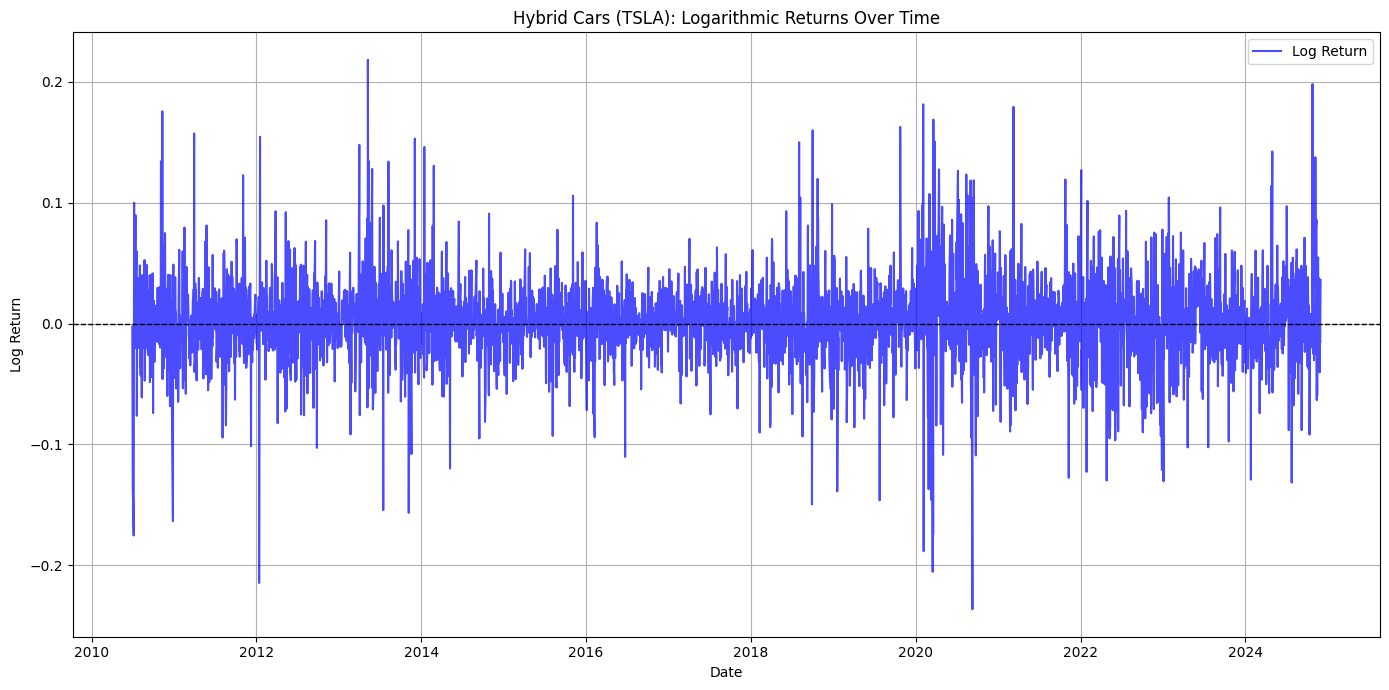

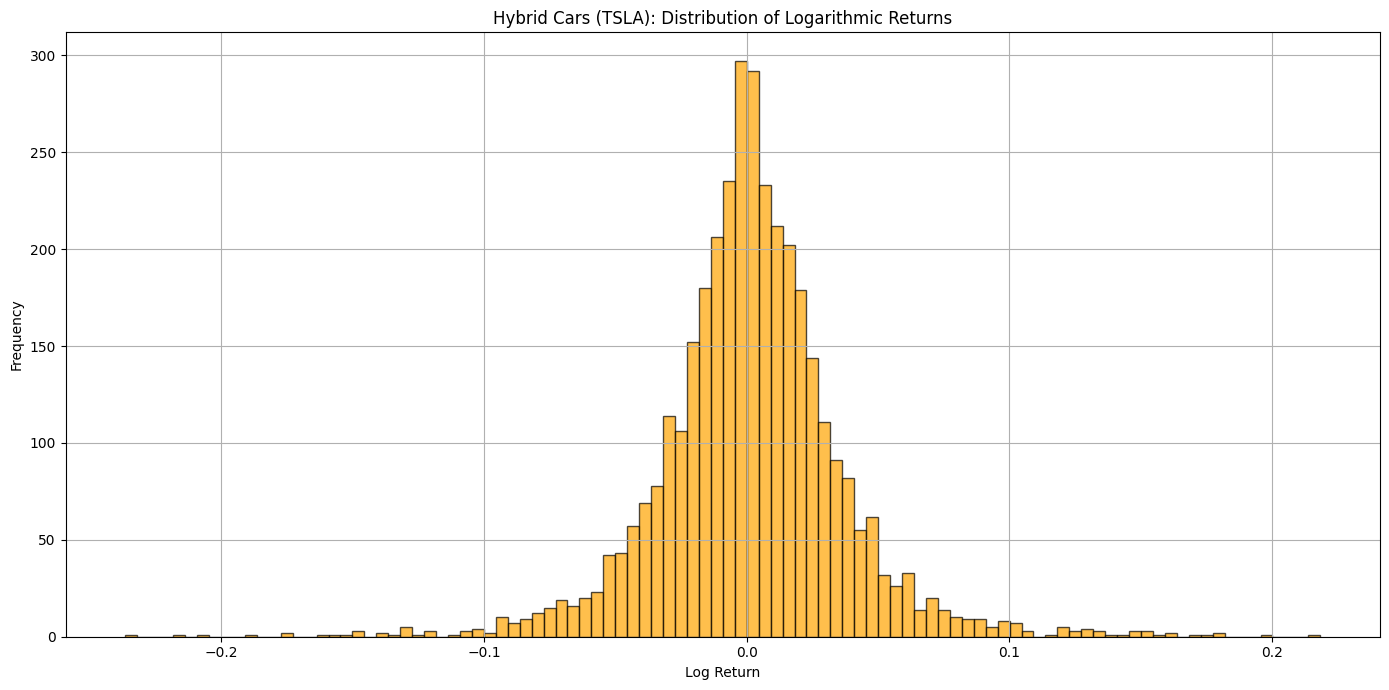

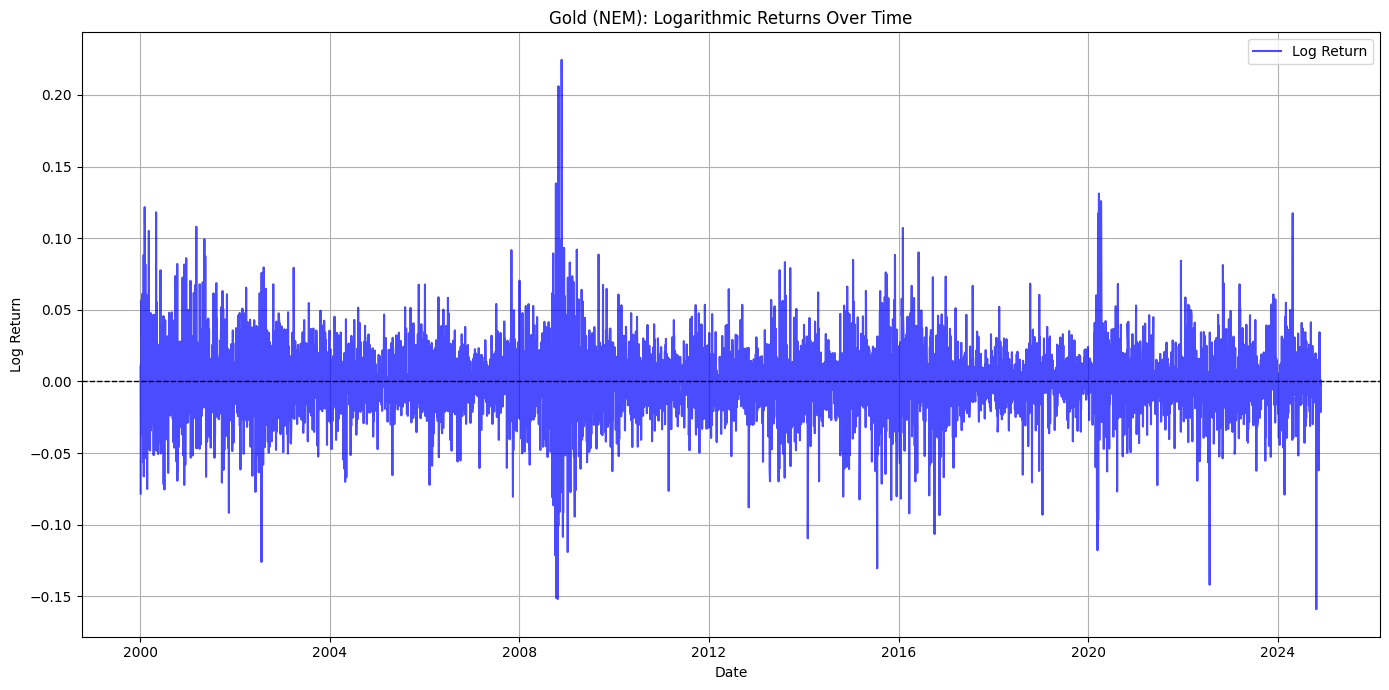

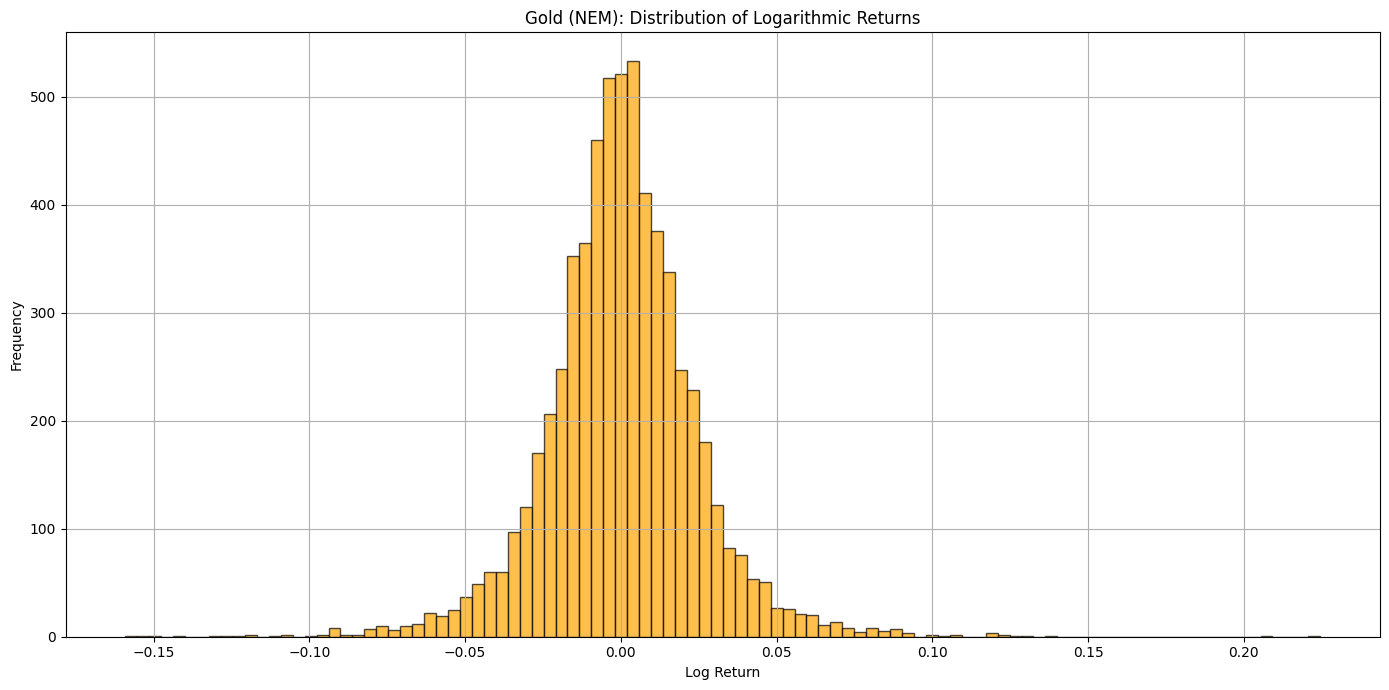

In [29]:
def plot_log_returns(ticker, category):
    # Load and clean data
    file_path = os.path.join(data_dir, f"{ticker}_adjusted.csv")
    raw_data = pd.read_csv(file_path)
    clean_data = clean_stock_data(raw_data)
    
    # Calculate logarithmic returns
    clean_data['Log Return'] = np.log(clean_data['Adj Close'] / clean_data['Adj Close'].shift(1))
    
    # Plot time series of logarithmic returns
    plt.figure(figsize=(14, 7))
    plt.plot(clean_data['Date'], clean_data['Log Return'], label='Log Return', color='blue', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"{category} ({ticker}): Logarithmic Returns Over Time")
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot distribution of logarithmic returns
    plt.figure(figsize=(14, 7))
    clean_data['Log Return'].plot(kind='hist', bins=100, color='orange', alpha=0.7, edgecolor='black')
    plt.title(f"{category} ({ticker}): Distribution of Logarithmic Returns")
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot for each selected stock
for category, ticker in stocks.items():
    plot_log_returns(ticker, category)


## Importance of Stationarity and Normality in Statistical and Predictive Analysis

In financial analysis, understanding the properties of a dataset, such as stationarity and normality, is crucial for effective modeling and prediction.

---

### Why is Stationarity Important?
Stationarity ensures that the statistical properties of a time series (e.g., mean, variance) remain constant over time. This is critical for predictive modeling because:
1. **Predictability**:
   - Non-stationary data can have trends or changing variances that make predictions unreliable.
   - Many time series models (e.g., ARIMA, SARIMA) assume stationarity to produce meaningful results.
   
2. **Simpler Analysis**:
   - Stationary data often requires fewer transformations, making the modeling process more straightforward.

In financial markets, **prices** are often non-stationary due to long-term trends and seasonality. However, **logarithmic returns**, derived from price changes, are typically stationary, making them more suitable for statistical analysis.

---

### Why is Normality Important?
Normality implies that the data follows a bell-shaped curve (Gaussian distribution). This is important for:
1. **Risk Assessment**:
   - Many financial models (e.g., Value at Risk, Monte Carlo simulations) assume normally distributed returns for simplicity.
   - Normal distributions make it easier to estimate probabilities of extreme events.

2. **Statistical Modeling**:
   - Parametric tests (e.g., regression, hypothesis testing) often rely on the assumption of normally distributed residuals or inputs.

However, in practice, financial data often deviates from strict normality. For example:
- **Logarithmic returns** tend to exhibit "fat tails," meaning extreme events occur more frequently than expected under a normal distribution.
- **Prices** exhibit trends, making their distribution far from normal.

---

### Challenges with Traditional Normality Tests
Traditional normality tests, such as the Shapiro-Wilk or Anderson-Darling test, have limitations when applied to financial data:
1. **Sensitivity to Large Sample Sizes**:
   - These tests often reject normality for large datasets, even for slight deviations from normality, which are common in financial data.

2. **Imperfect Financial Data**:
   - Real-world data contains noise, outliers, and structural breaks, making strict normality tests overly restrictive.

---

### Our Approach: Near-Normality
Instead of strict normality, we assess **near-normality**, which allows for slight deviations. We use:
1. **Skewness**:
   - Measures the asymmetry of the data.
   - Near-normality is assumed if \( | \text{skewness} | < 1 \).

2. **Kurtosis**:
   - Measures the heaviness of the tails of the distribution.
   - Near-normality is assumed if \( 2 < \text{kurtosis} < 4 \).

This approach is more practical for financial datasets, acknowledging their inherent imperfections while providing actionable insights.

---

### Why Logarithmic Returns Are Preferred
1. **Stationarity**:
   - Logarithmic returns are typically stationary, making them easier to model.
   - Prices, on the other hand, exhibit trends and require additional transformations to achieve stationarity.

2. **Near-Normality**:
   - Logarithmic returns are closer to a normal distribution compared to prices, making them more suitable for statistical models.

3. **Variance Stabilization**:
   - Logarithmic returns reduce the impact of extreme outliers, stabilizing the data for analysis.

4. **Additivity**:
   - Logarithmic returns are additive over time, allowing for easier multi-period analysis:
     \[
     \text{Total Log Return} = \sum_{t=1}^n R_{\text{log},t}
     \]

---

### Technical Implementation
Below, we assess all stocks in our dataset to determine:
1. The percentage of stocks with **near-normality** for prices and logarithmic returns.
2. The percentage of stocks exhibiting **stationarity** for prices and logarithmic returns.

We compare these properties to highlight the advantages of using logarithmic returns for predictive analysis.


In [31]:
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
import os

# Initialize counters
total_stocks = 0
near_normal_prices = 0
near_normal_returns = 0
stationary_prices = 0
stationary_returns = 0

# Function to check near-normality based on skewness and kurtosis
def is_near_normal(data):
    sk = skew(data)
    ku = kurtosis(data)
    return abs(sk) < 1 and 2 < ku < 4  # Near-normal if skewness < 1 and kurtosis in (2, 4)

# Function to check stationarity using rolling variance as a heuristic
def is_stationary(data, window=30):
    rolling_var = data.rolling(window=window).var()
    return rolling_var.std() < 0.01  # Stationary if variance is almost constant

# Analyze all stocks
for ticker in tickers:
    try:
        # Load and clean data
        file_path = os.path.join(data_dir, f"{ticker}_adjusted.csv")
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Ensure sufficient data
        if len(clean_data) < 30:  # Skip stocks with insufficient data
            continue

        total_stocks += 1

        # Test prices for near-normality and stationarity
        adj_close = clean_data['Adj Close'].dropna()
        if is_near_normal(adj_close):
            near_normal_prices += 1
        if is_stationary(adj_close):
            stationary_prices += 1

        # Calculate log returns and test for near-normality and stationarity
        clean_data['Log Return'] = np.log(clean_data['Adj Close'] / clean_data['Adj Close'].shift(1))
        log_return = clean_data['Log Return'].dropna()

        if is_near_normal(log_return):
            near_normal_returns += 1
        if is_stationary(log_return):
            stationary_returns += 1

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

# Compute percentages
results = {
    "Total Stocks Analyzed": total_stocks,
    "Near-Normal Prices": (near_normal_prices / total_stocks) * 100,
    "Near-Normal Log Returns": (near_normal_returns / total_stocks) * 100,
    "Stationary Prices": (stationary_prices / total_stocks) * 100,
    "Stationary Log Returns": (stationary_returns / total_stocks) * 100,
}

# Display results
for key, value in results.items():
    print(f"{key}: {value:.2f}%")


Total Stocks Analyzed: 503.00%
Near-Normal Prices: 0.00%
Near-Normal Log Returns: 0.99%
Stationary Prices: 0.00%
Stationary Log Returns: 100.00%


## Importance of Sector Correlations in Financial Analysis

In the financial world, understanding how different sectors correlate is a crucial aspect of portfolio management, risk assessment, and market analysis. Correlation provides insights into how stocks or sectors move relative to each other, which can help identify diversification opportunities or understand sector-specific trends.

---

### What is Sector Correlation?

Sector correlation measures how closely the returns of stocks within the same sector or across different sectors move together. A high correlation implies that the stocks often move in the same direction, while a low or negative correlation indicates independent or opposite movement.

---

### Why is Correlation Analysis Important?

1. **Portfolio Diversification**:
   - A well-diversified portfolio aims to include assets or stocks that are less correlated, reducing the overall risk.
   - By identifying sectors with low correlations, investors can spread risk across different industries and reduce exposure to market volatility.

2. **Market Behavior Analysis**:
   - High correlation within a sector may indicate strong industry-specific factors driving stock movements (e.g., regulatory changes, commodity prices, or market trends).
   - Understanding inter-sector correlations can reveal macroeconomic trends influencing multiple industries.

3. **Risk Management**:
   - Correlations help identify systemic risks. If multiple sectors are highly correlated, a market-wide downturn could amplify portfolio losses.
   - Conversely, if sectors are uncorrelated, losses in one sector may be offset by gains in another.

4. **Sector-Specific Strategies**:
   - Some sectors, such as utilities or real estate, often show high internal correlations due to shared exposure to similar economic conditions.
   - Other sectors, like technology, may exhibit diverse behavior, influenced by innovation cycles and varying business models.

---

### Key Insights from Correlation Analysis

1. **High Correlation**:
   - Sectors such as **Utilities**, **Energy**, and **Financials** often exhibit high internal correlation, as companies within these sectors share common market drivers (e.g., energy prices, interest rates).

2. **Low Correlation**:
   - Sectors like **Technology** or **Consumer Discretionary** may show lower correlations due to diverse business models and external influences.

3. **Cross-Sector Dependencies**:
   - Correlations between sectors (e.g., Energy and Industrials, or Technology and Consumer Discretionary) can highlight interdependencies in the broader economy.

---

### Purpose of This Analysis

By calculating the correlations between stocks across the S&P 500 and clustering them into groups, we aim to:
1. Identify highly correlated groups of stocks, typically within the same sector.
2. Understand the relationships between sectors and their potential interdependencies.
3. Leverage these insights to:
   - Guide portfolio diversification.
   - Develop sector-specific investment strategies.
   - Assess systemic risks in the financial markets.

---

This analysis provides a deeper understanding of sector behavior, helping investors and analysts make informed decisions based on market dynamics. The results are presented as heatmaps for individual clusters, revealing patterns of correlation within and across sectors.


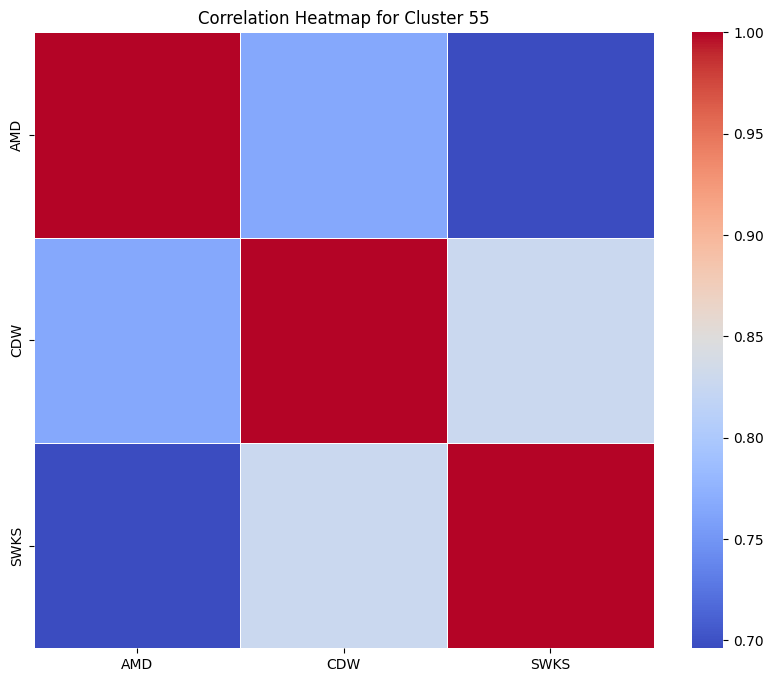

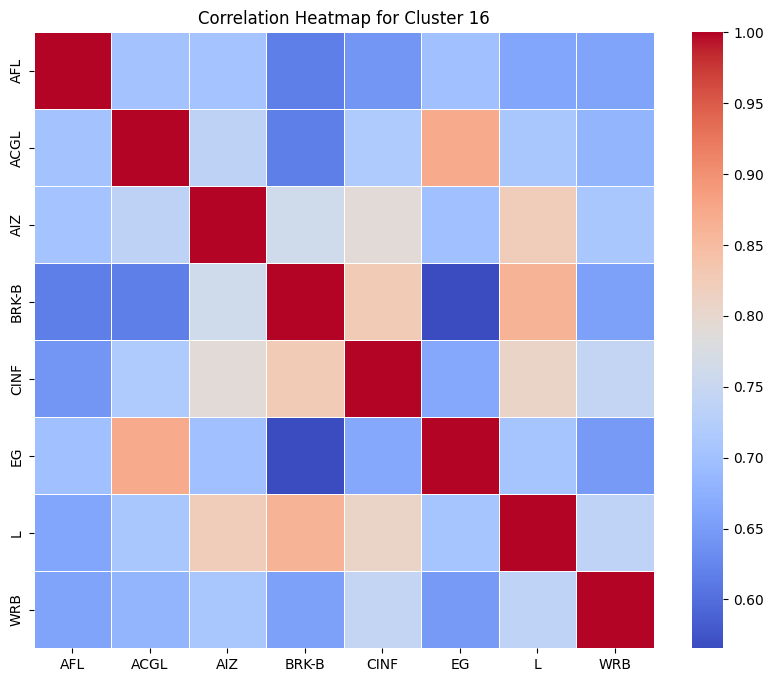

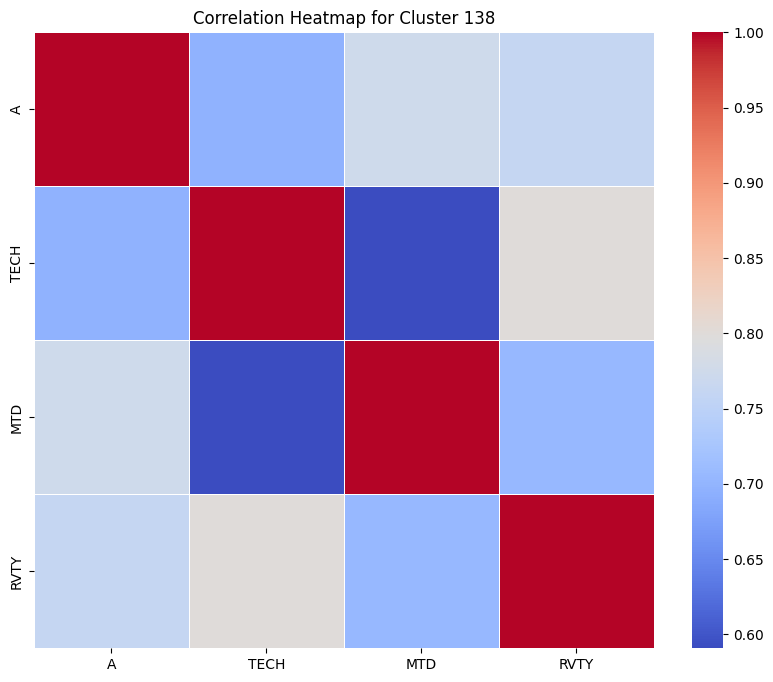

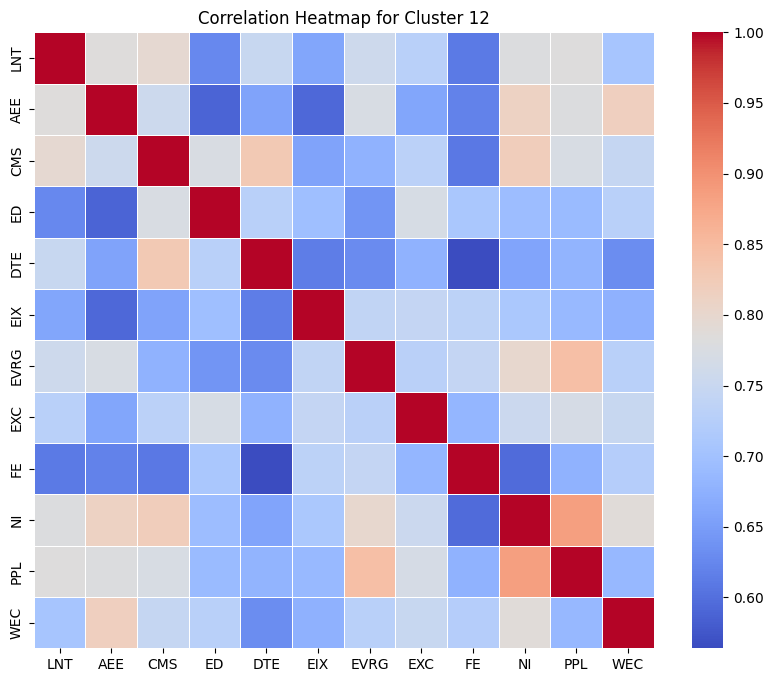

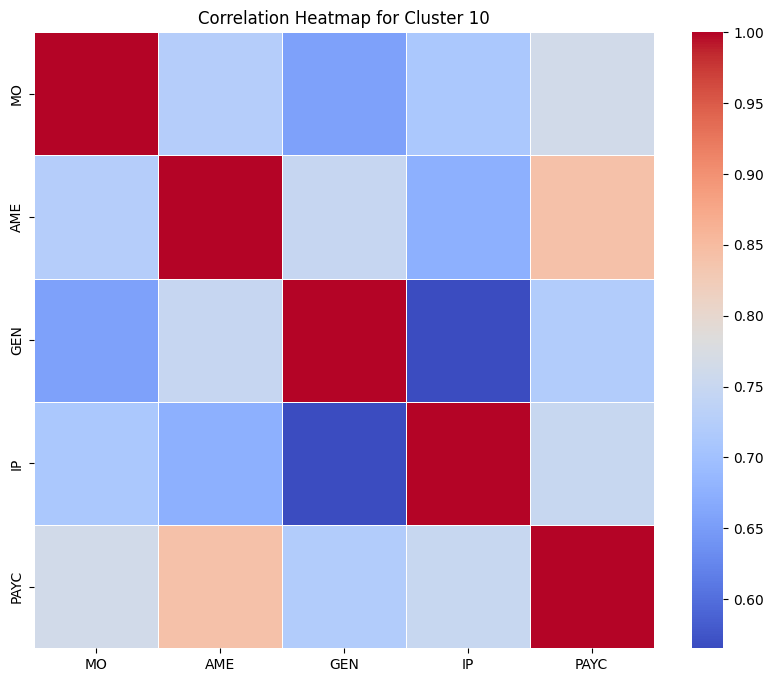

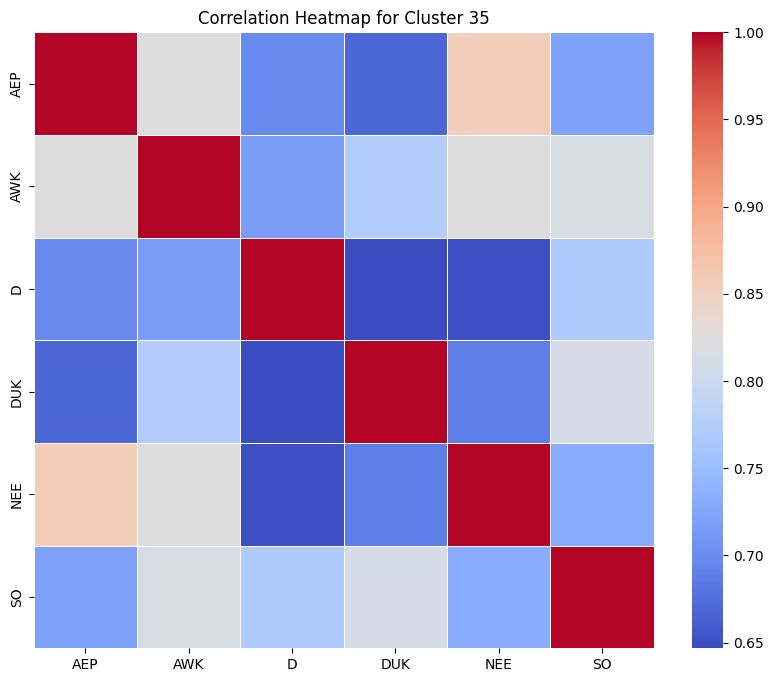

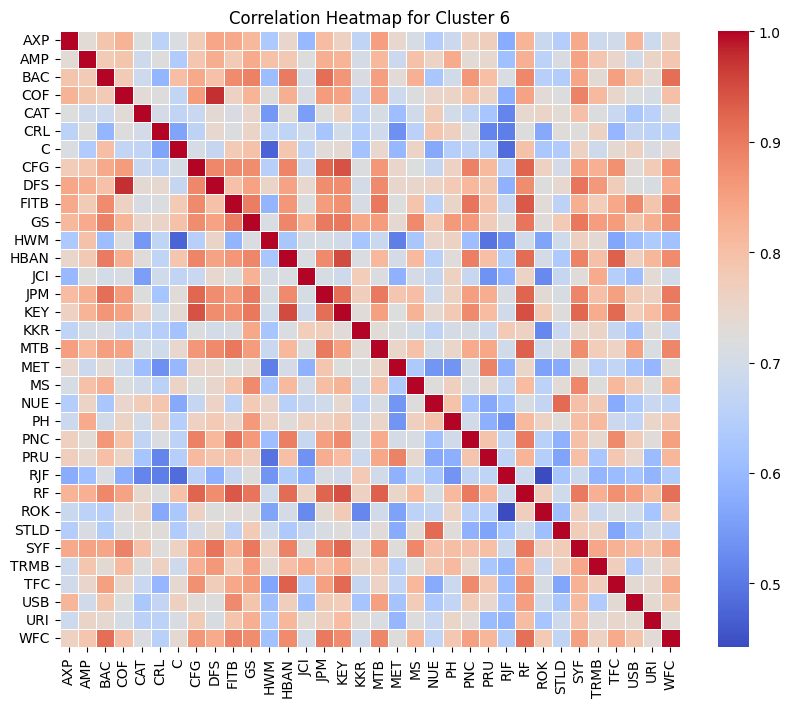

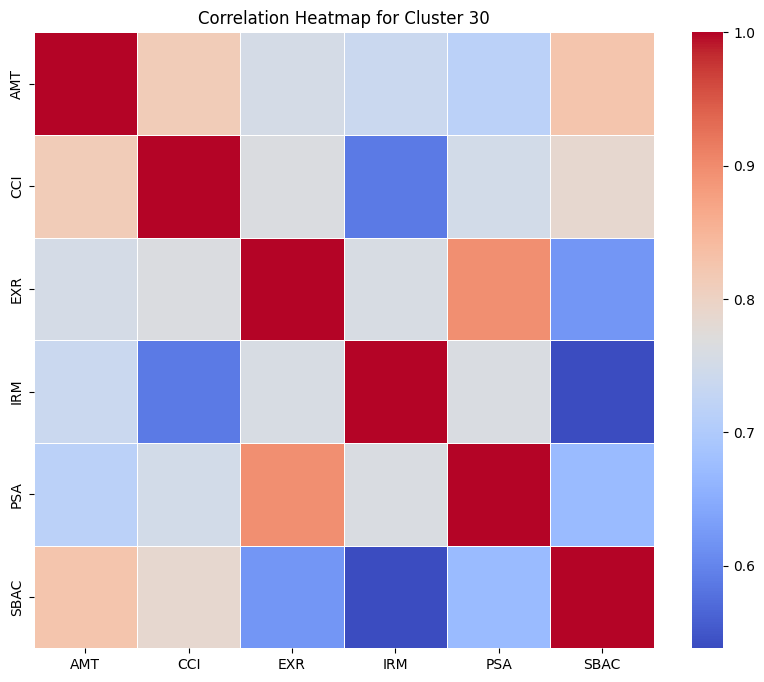

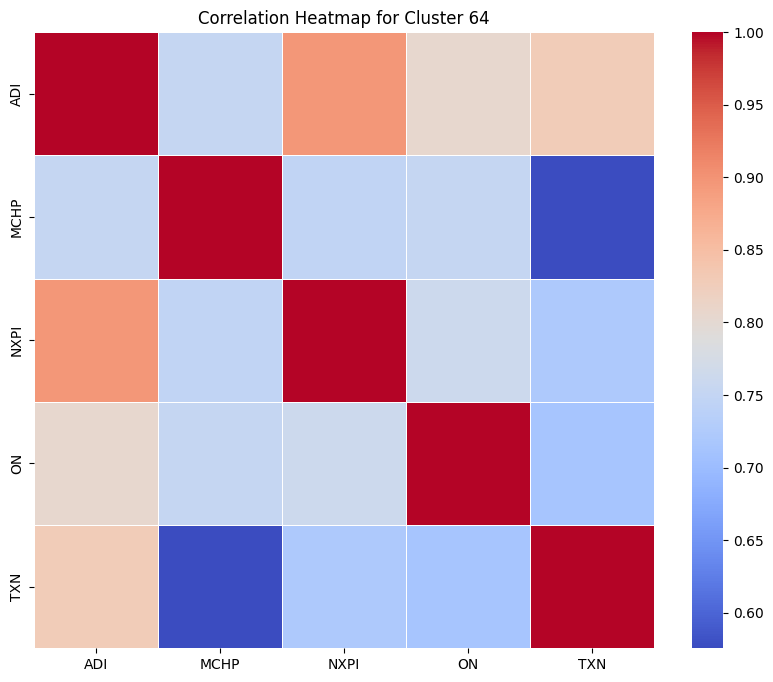

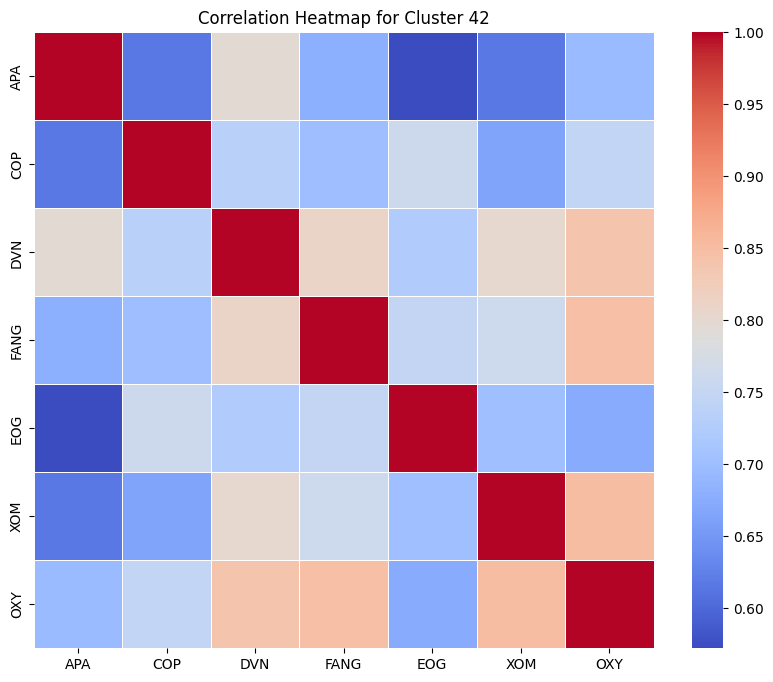

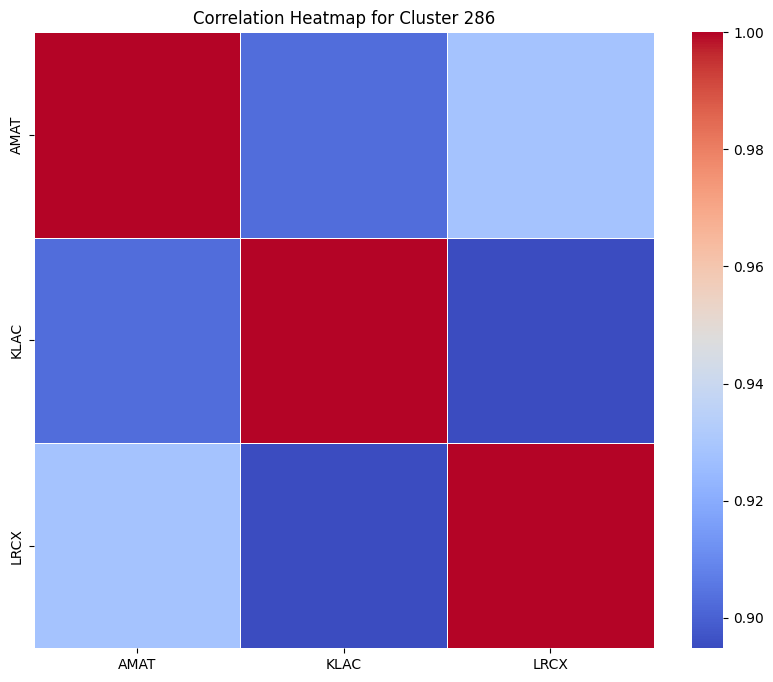

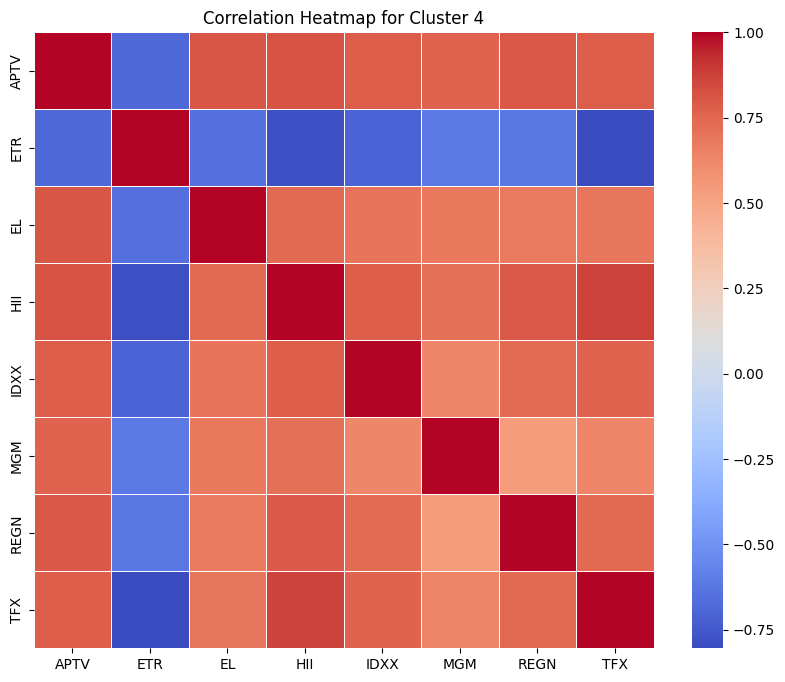

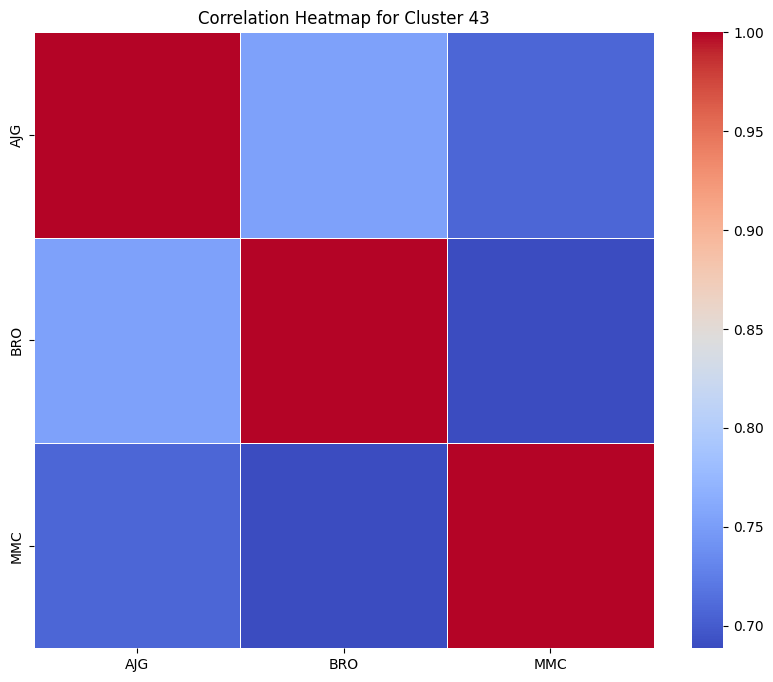

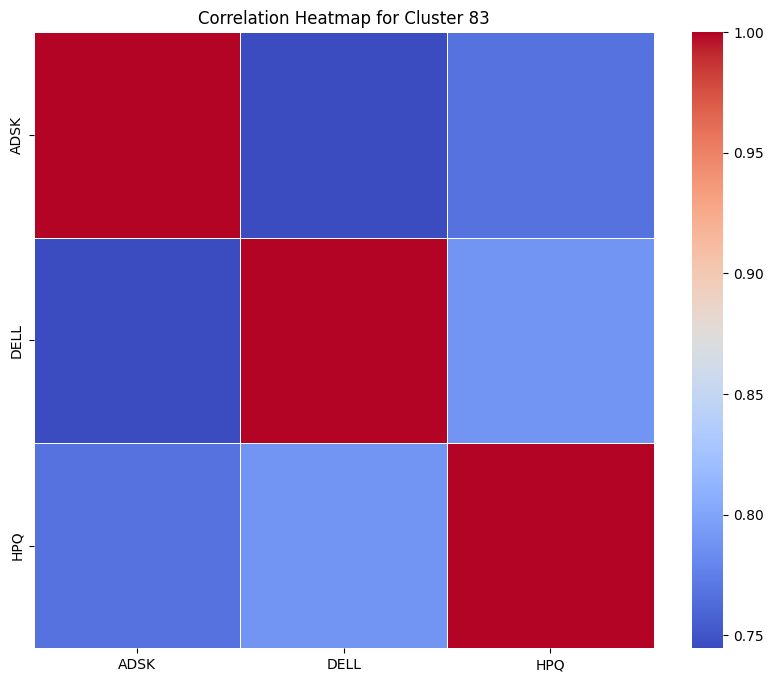

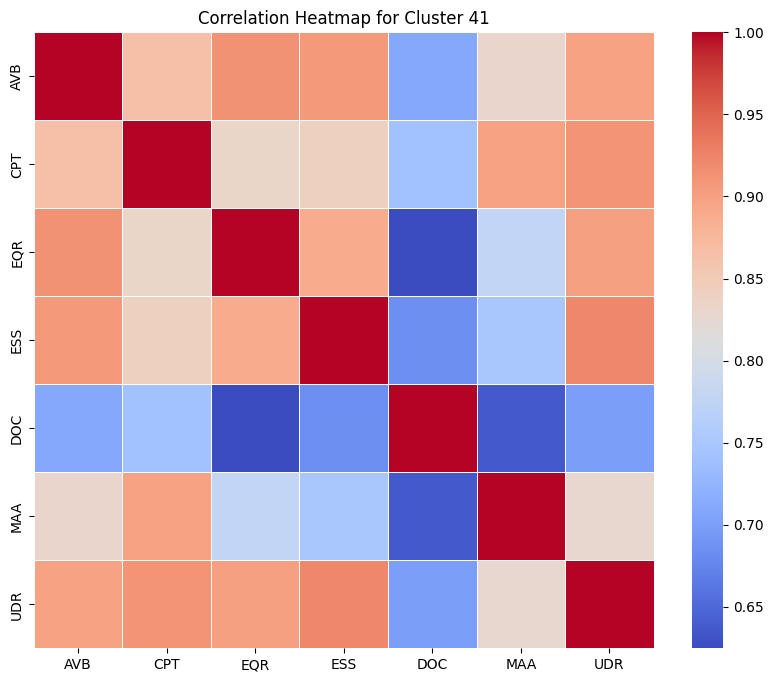

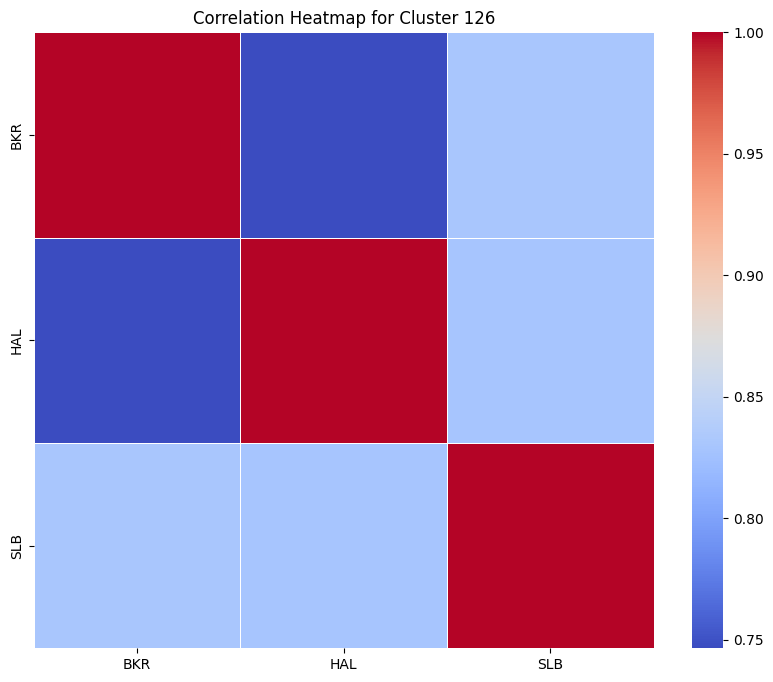

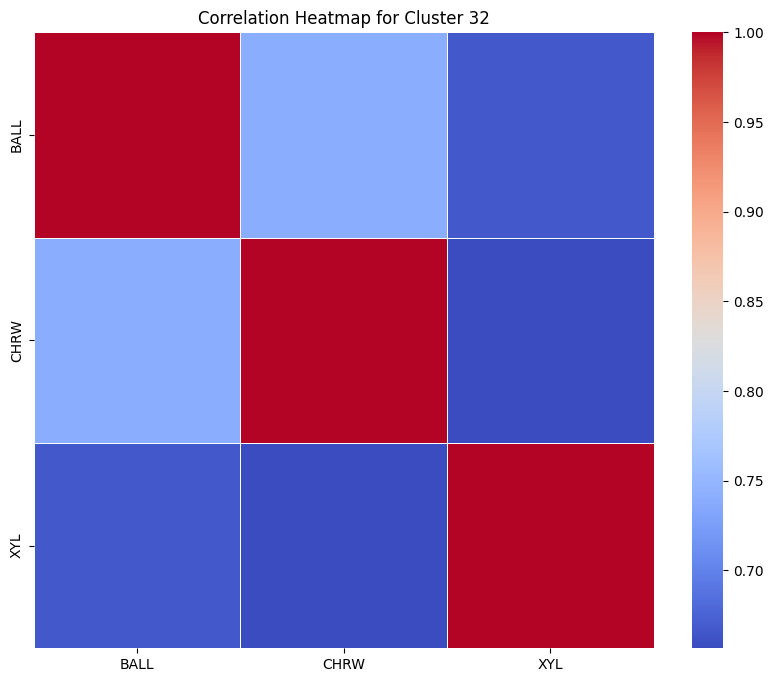

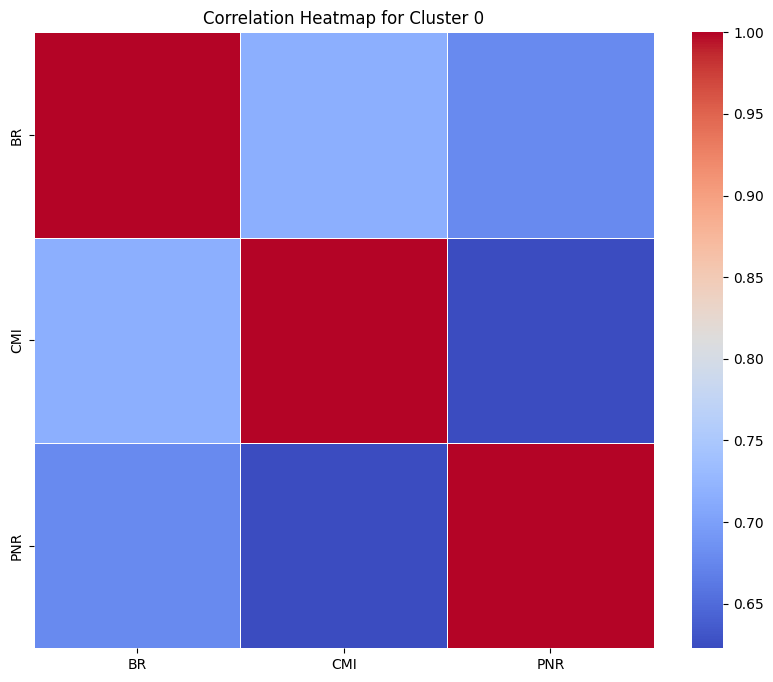

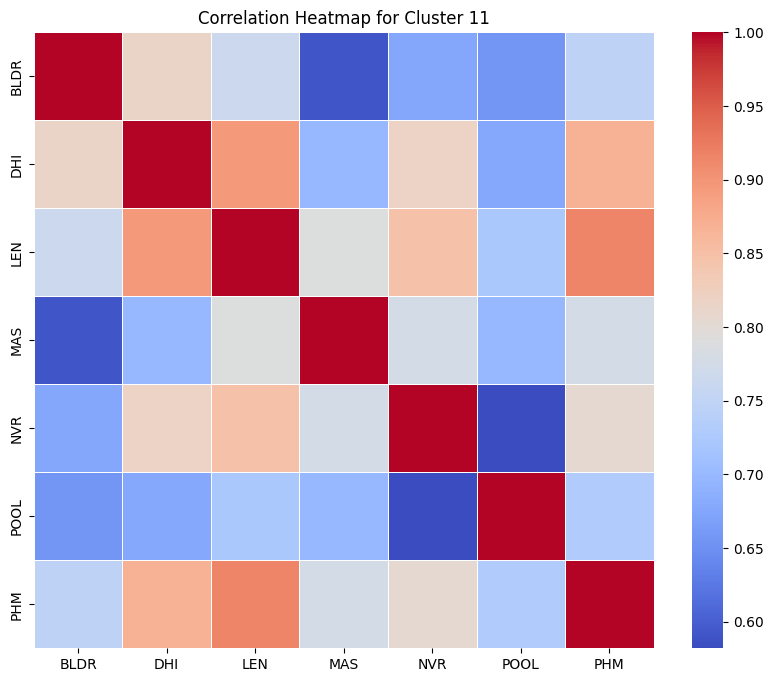

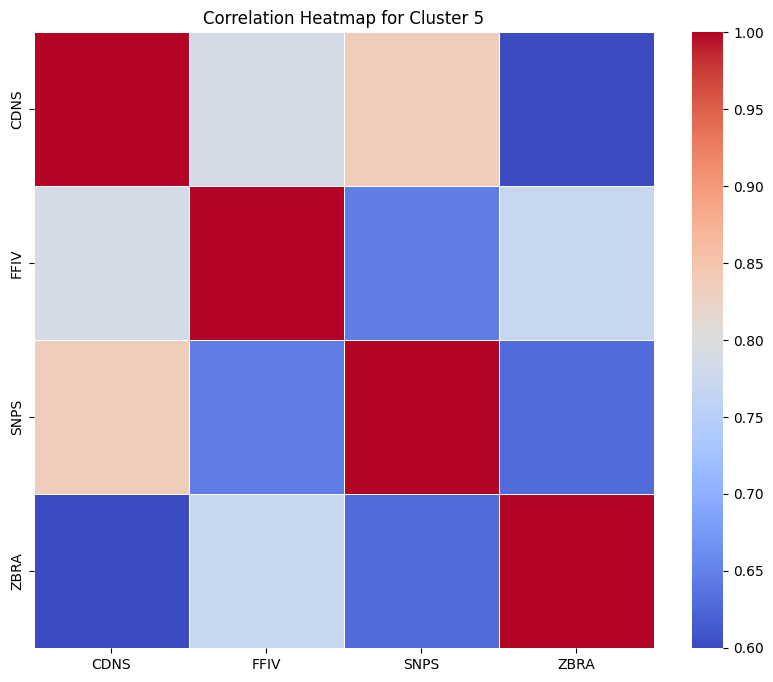

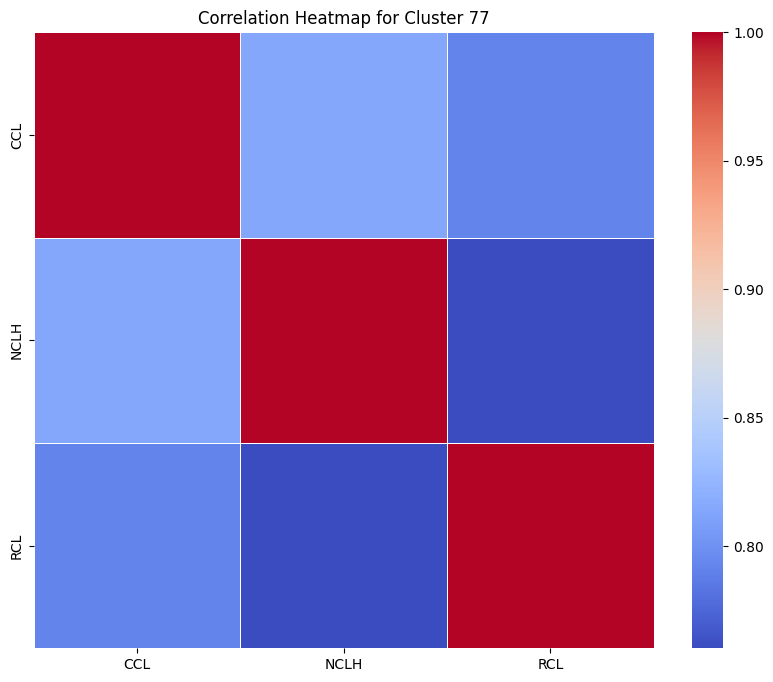

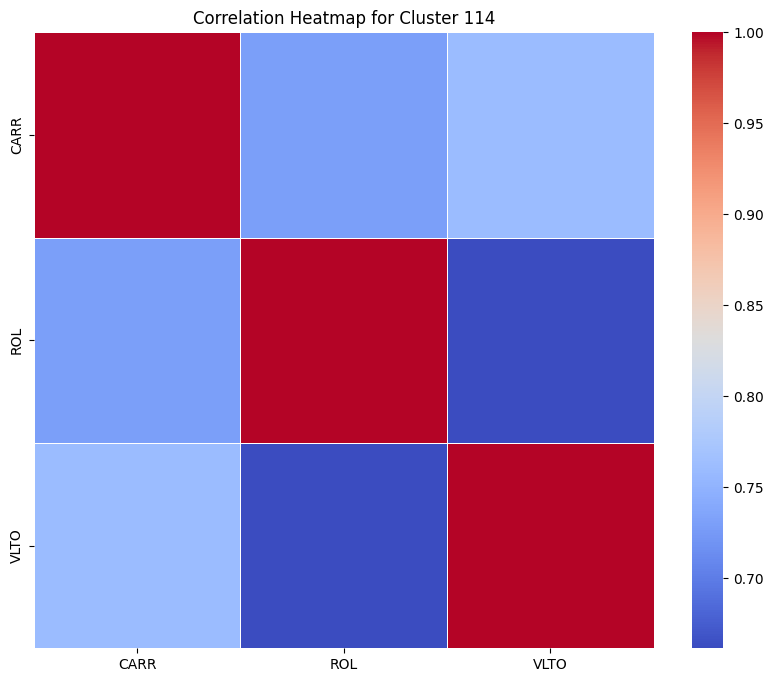

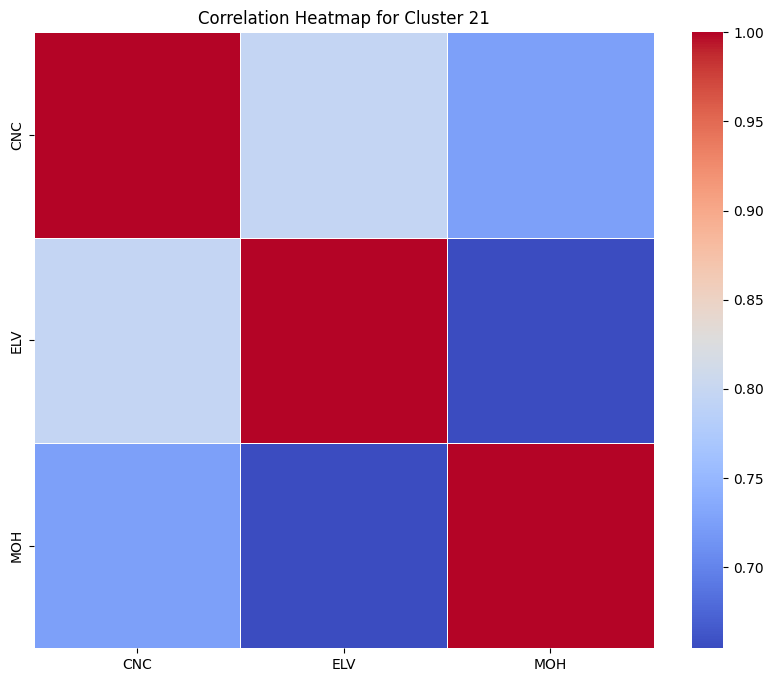

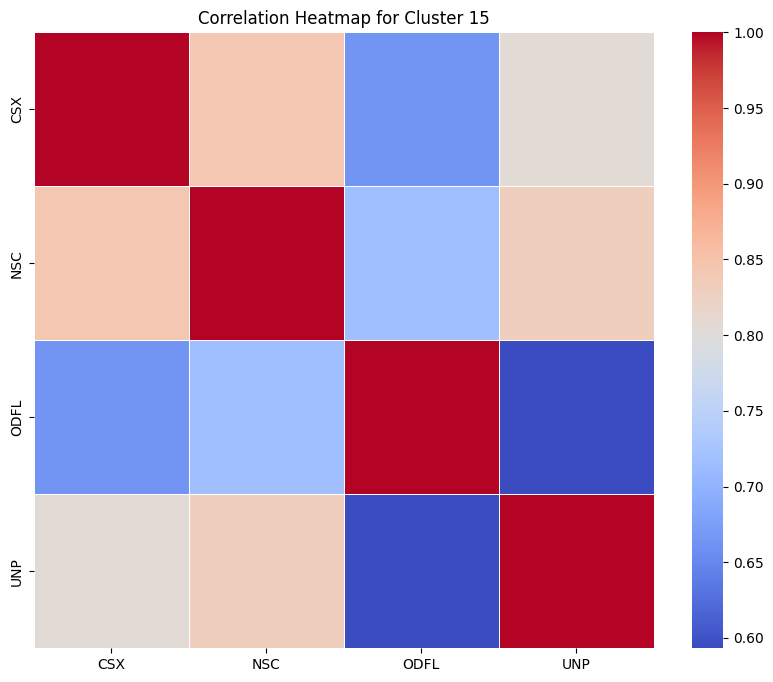

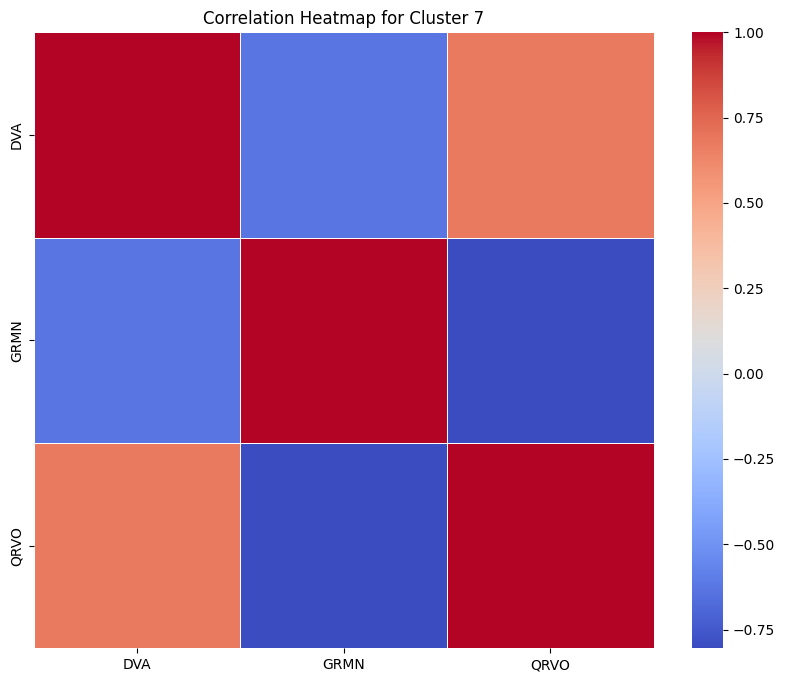

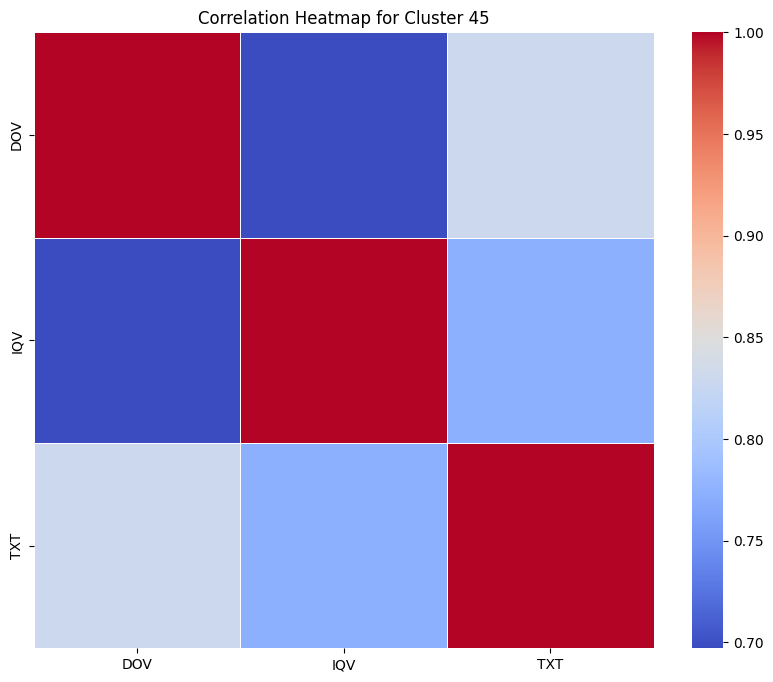

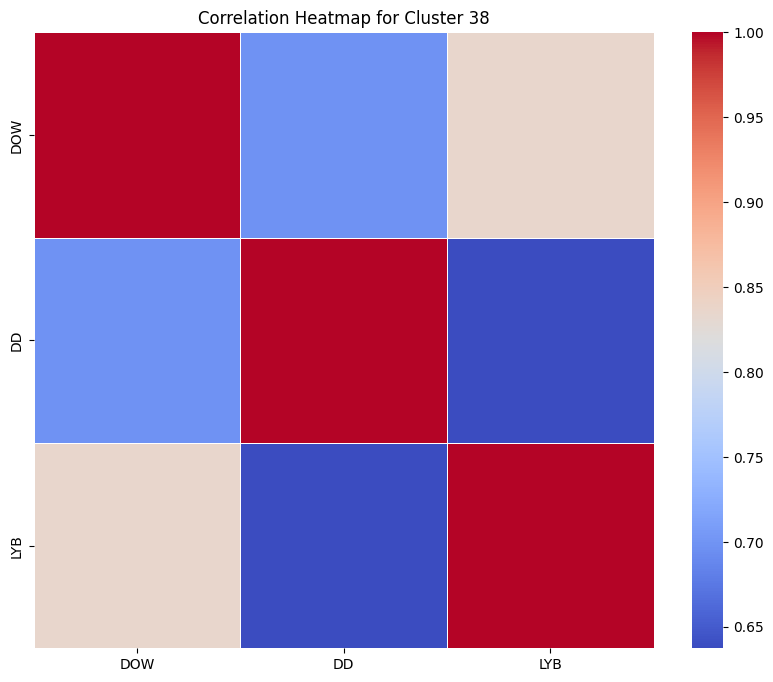

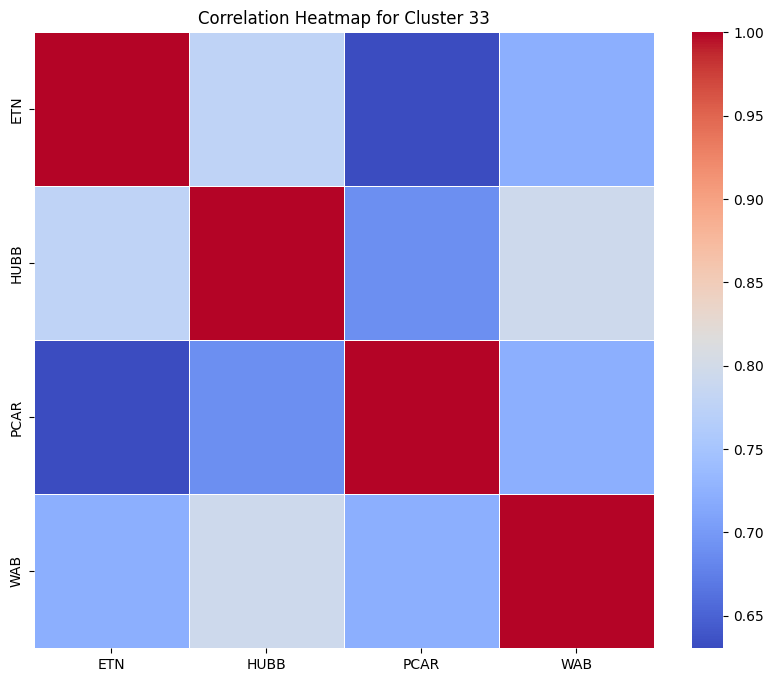

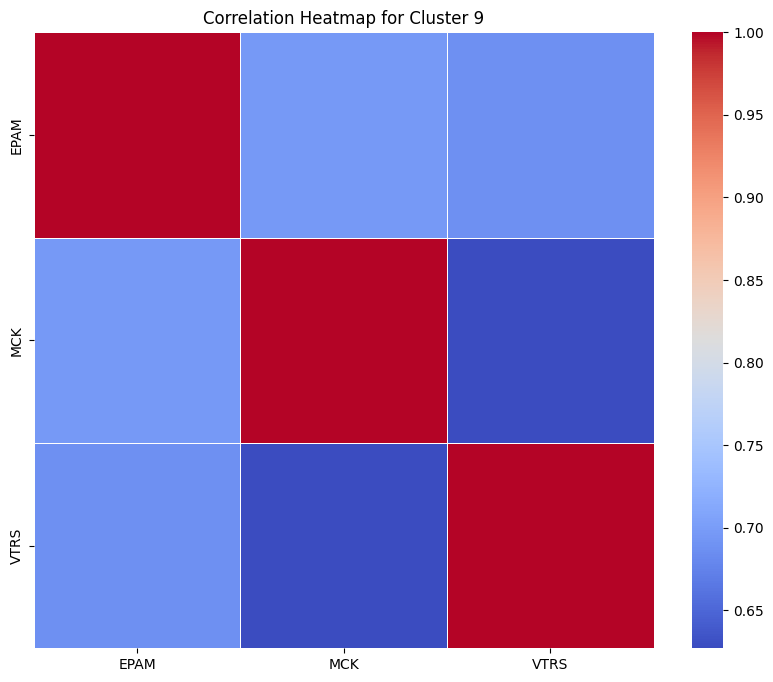

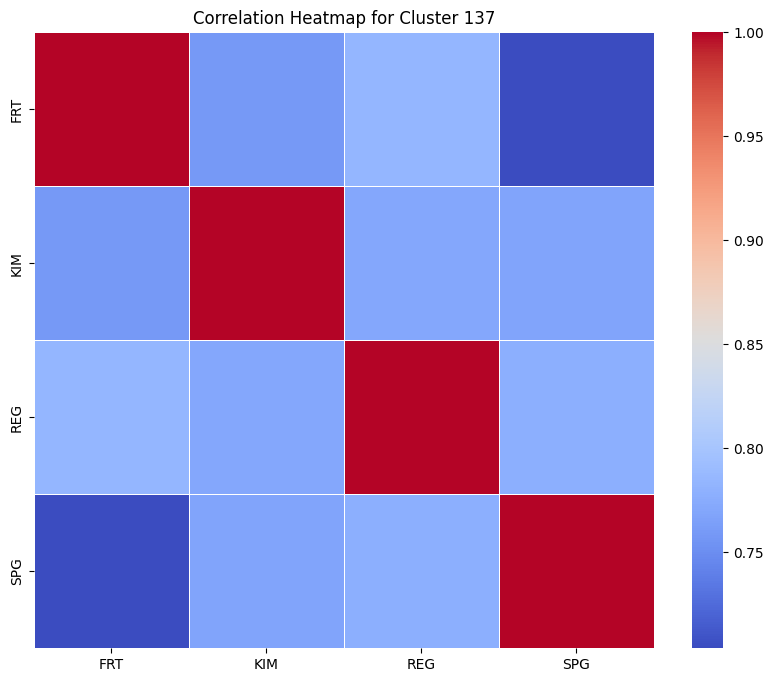

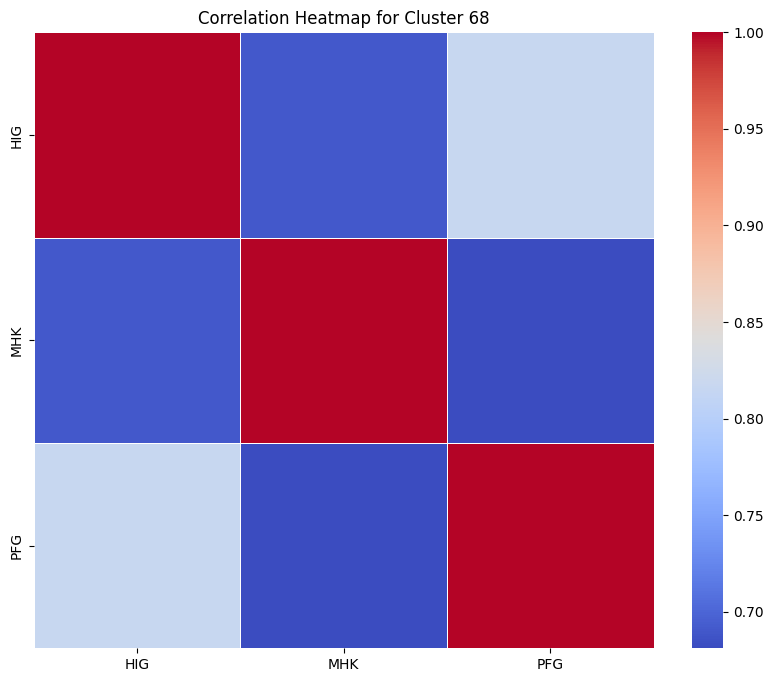

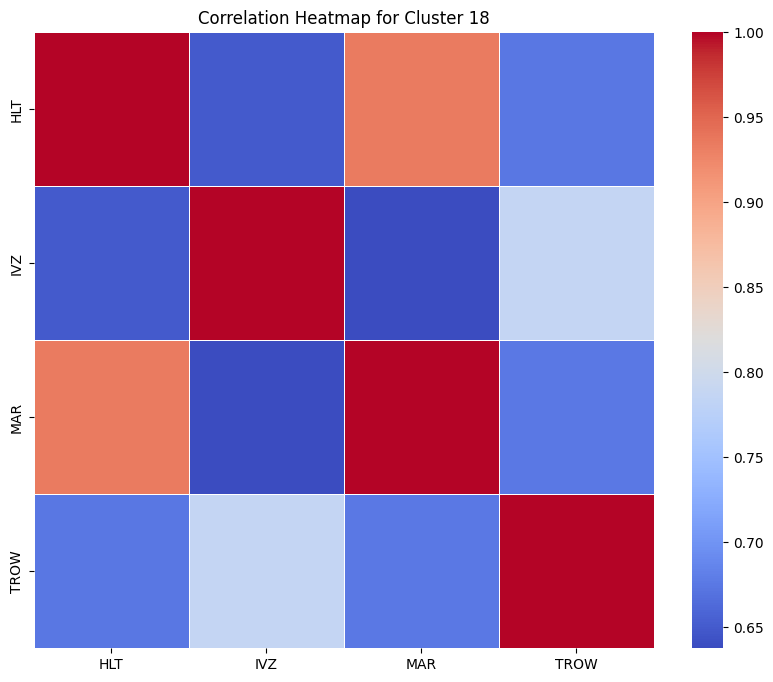

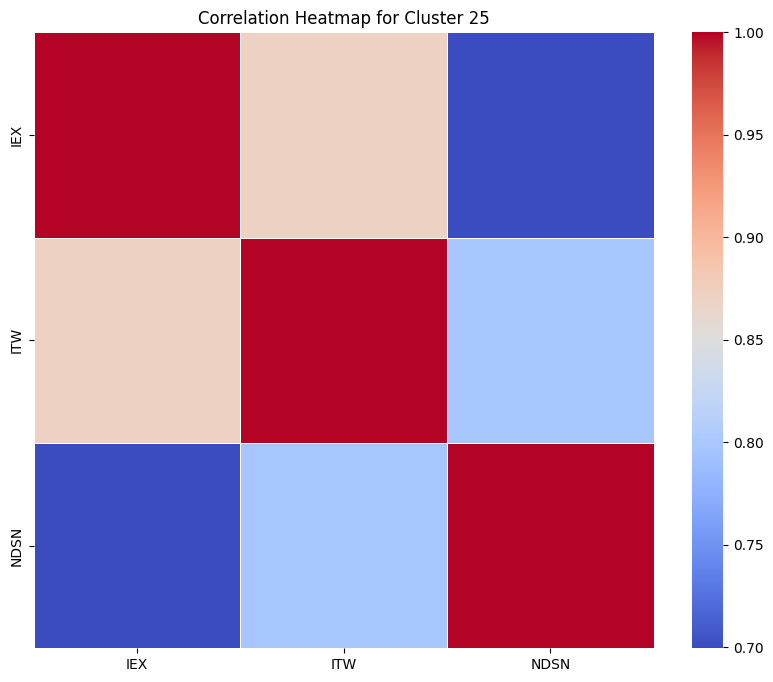

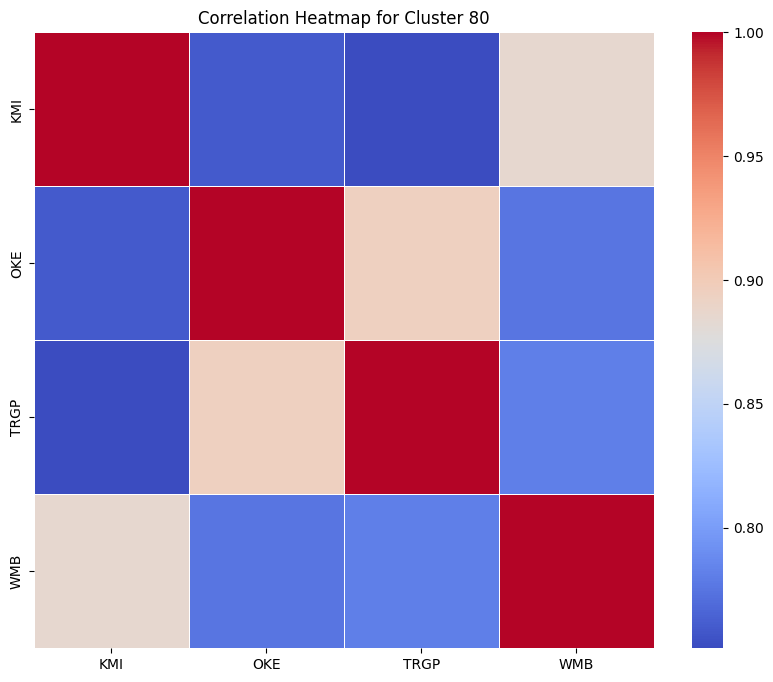

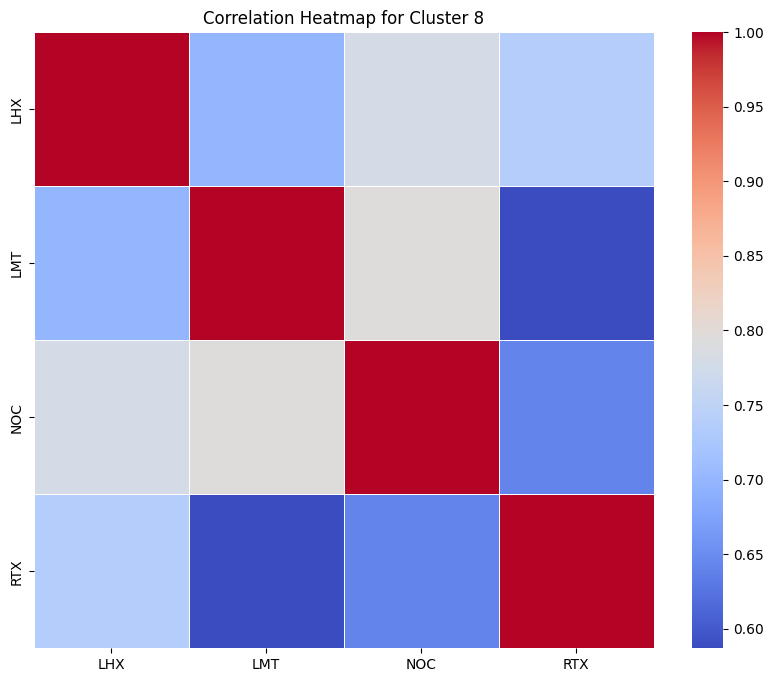

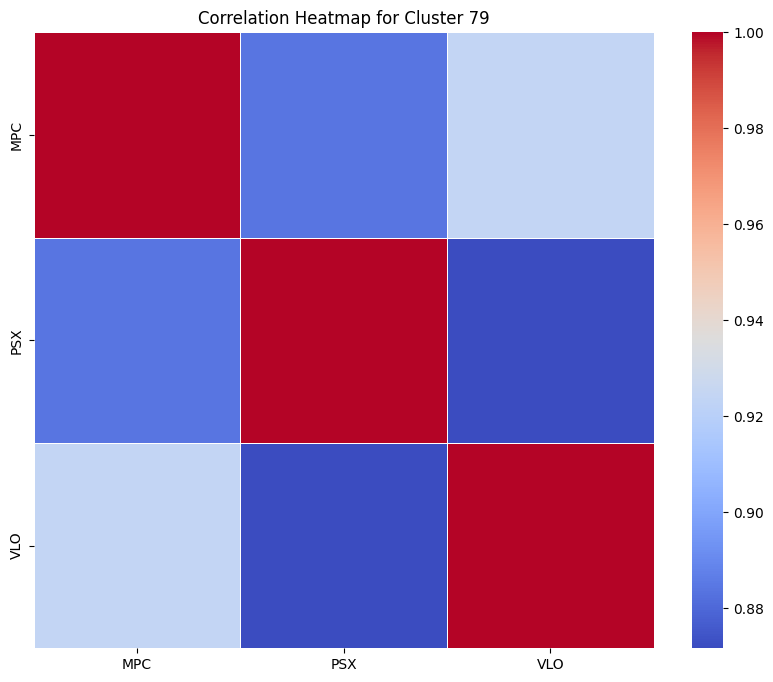

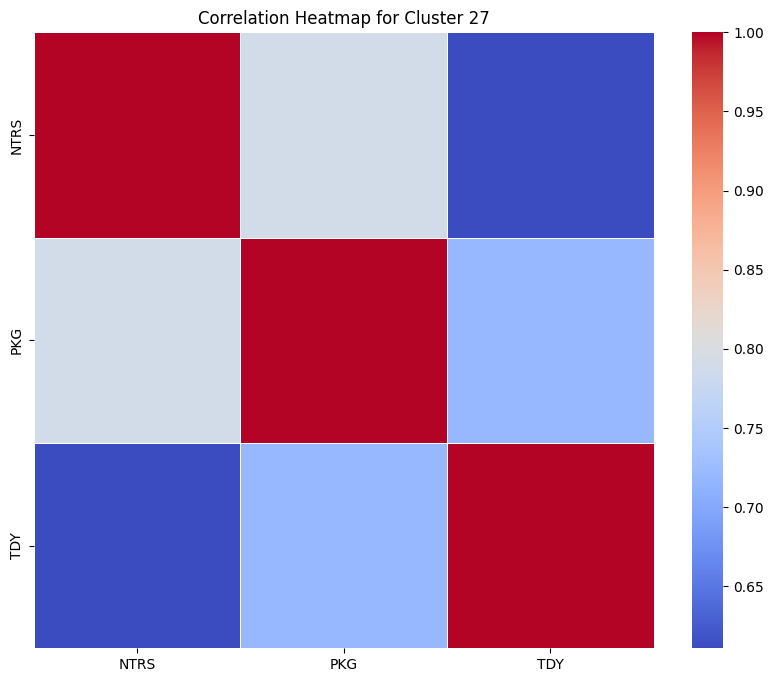

In [45]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load and clean data, compute log returns for all stocks
# Step 1: Combine all log returns into a single DataFrame
log_returns = {}
for ticker in tickers:
    try:
        # Load and clean data
        file_path = os.path.join(data_dir, f"{ticker}_adjusted.csv")
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Compute log returns
        clean_data['Log Return'] = np.log(clean_data['Adj Close'] / clean_data['Adj Close'].shift(1))
        log_returns[ticker] = clean_data.set_index('Date')['Log Return']

    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

# Combine all log returns into a single DataFrame, aligned by date
log_returns_df = pd.concat(log_returns, axis=1).dropna()

# Step 2: Compute the correlation matrix
correlation_matrix = log_returns_df.corr()

from scipy.spatial.distance import squareform

# Step 4: Perform clustering on the correlation matrix
# Convert the correlation matrix to distances (1 - correlation)
distance_matrix = 1 - correlation_matrix.abs()

# Ensure the matrix is symmetric and non-negative
distance_matrix = distance_matrix.fillna(0).values

# Convert to condensed form for hierarchical clustering
condensed_distance_matrix = squareform(distance_matrix, checks=True)

# Hierarchical clustering
linked = sch.linkage(condensed_distance_matrix, method='ward')

# Agglomerative clustering
clustering_model = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.35,
    metric='precomputed',  # Updated from 'affinity'
    linkage='average'
)
clusters = clustering_model.fit_predict(distance_matrix)

# Step 5: Map clusters to tickers
clustered_stocks = pd.DataFrame({
    'Ticker': correlation_matrix.columns,
    'Cluster': clusters
})

# Step 6: Plot separate heatmaps for each cluster (excluding single-ticker clusters)
unique_clusters = clustered_stocks['Cluster'].unique()

for cluster in unique_clusters:
    # Get tickers in the current cluster
    cluster_stocks = clustered_stocks[clustered_stocks['Cluster'] == cluster]['Ticker']
    
    # Skip clusters with only one ticker
    if len(cluster_stocks) <= 2:
        continue
    
    # Extract the correlation matrix for the current cluster
    cluster_corr_matrix = correlation_matrix.loc[cluster_stocks, cluster_stocks]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cluster_corr_matrix,
        cmap="coolwarm",
        annot=False,
        fmt=".2f",
        linewidths=0.5,
        cbar=True
    )
    plt.title(f"Correlation Heatmap for Cluster {cluster}")
    plt.show()

# Cluster Explanations

## Cluster 68
### Companies
- **HIG**: Hartford Financial Services Group Inc.
- **MHK**: Mohawk Industries Inc.
- **PFG**: Principal Financial Group Inc.

### Sector and Industry
- **HIG**: Financials (Insurance)
- **MHK**: Consumer Discretionary (Home Furnishings)
- **PFG**: Financials (Asset Management)

### Insights
This cluster represents a mix of financial services and consumer discretionary. Despite the differences in industries, their correlations may arise from economic cycles affecting both financial markets and consumer spending.

---

## Cluster 18
### Companies
- **HLT**: Hilton Worldwide Holdings Inc.
- **IVZ**: Invesco Ltd.
- **MAR**: Marriott International Inc.
- **TROW**: T. Rowe Price Group Inc.

### Sector and Industry
- **HLT**: Consumer Discretionary (Hotels, Restaurants, and Leisure)
- **IVZ**: Financials (Asset Management)
- **MAR**: Consumer Discretionary (Hotels, Restaurants, and Leisure)
- **TROW**: Financials (Asset Management)

### Insights
This cluster links hospitality giants with asset management firms, likely reflecting broader economic trends influencing both leisure travel and investment markets.

---

## Cluster 25
### Companies
- **IEX**: IDEX Corporation
- **ITW**: Illinois Tool Works Inc.
- **NDSN**: Nordson Corporation

### Sector and Industry
- **IEX**: Industrials (Machinery)
- **ITW**: Industrials (Machinery)
- **NDSN**: Industrials (Machinery)

### Insights
This cluster highlights industrial machinery manufacturers. Their close correlations suggest shared economic drivers, such as industrial production and technological advancements.

---

## Cluster 80
### Companies
- **KMI**: Kinder Morgan Inc.
- **OKE**: ONEOK Inc.
- **TRGP**: Targa Resources Corp.
- **WMB**: Williams Companies Inc.

### Sector and Industry
- **KMI**: Energy (Oil & Gas Storage and Transportation)
- **OKE**: Energy (Oil & Gas Storage and Transportation)
- **TRGP**: Energy (Oil & Gas Storage and Transportation)
- **WMB**: Energy (Oil & Gas Storage and Transportation)

### Insights
This cluster represents companies in the midstream energy sector. Their strong correlations are likely due to shared exposure to oil and gas market fluctuations.

---

## Cluster 8
### Companies
- **LHX**: L3Harris Technologies Inc.
- **LMT**: Lockheed Martin Corporation
- **NOC**: Northrop Grumman Corporation
- **RTX**: Raytheon Technologies Corporation

### Sector and Industry
- **LHX**: Industrials (Aerospace & Defense)
- **LMT**: Industrials (Aerospace & Defense)
- **NOC**: Industrials (Aerospace & Defense)
- **RTX**: Industrials (Aerospace & Defense)

### Insights
This cluster includes aerospace and defense contractors. Their correlations are driven by government defense budgets and global security concerns.

---

## Cluster 79
### Companies
- **MPC**: Marathon Petroleum Corporation
- **PSX**: Phillips 66
- **VLO**: Valero Energy Corporation

### Sector and Industry
- **MPC**: Energy (Oil & Gas Refining and Marketing)
- **PSX**: Energy (Oil & Gas Refining and Marketing)
- **VLO**: Energy (Oil & Gas Refining and Marketing)

### Insights
These companies are leaders in oil refining and marketing. Their performance is heavily influenced by crude oil prices and refining margins.

---

## Cluster 27
### Companies
- **NTRS**: Northern Trust Corporation
- **PKG**: Packaging Corporation of America
- **TDY**: Teledyne Technologies Incorporated

### Sector and Industry
- **NTRS**: Financials (Banks)
- **PKG**: Materials (Containers and Packaging)
- **TDY**: Industrials (Aerospace & Defense)

### Insights
This diverse cluster suggests a possible correlation driven by broader economic or macroeconomic trends, such as global trade and investment flows.

---

## Cluster 55
### Companies
- **AMD**: Advanced Micro Devices Inc.
- **CDW**: CDW Corporation
- **SWKS**: Skyworks Solutions Inc.

### Sector and Industry
- **AMD**: Information Technology (Semiconductors)
- **CDW**: Information Technology (Technology Distributors)
- **SWKS**: Information Technology (Semiconductors)

### Insights
This cluster represents tech-focused firms, with semiconductors and technology distribution likely responding to advancements in technology and consumer demand.

---

## Cluster 16
### Companies
- **AFL**: Aflac Incorporated
- **ACGL**: Arch Capital Group Ltd.
- **AIZ**: Assurant Inc.
- **BRK.B**: Berkshire Hathaway Inc.
- **CINF**: Cincinnati Financial Corporation
- **EG**: Everest Group Ltd.
- **L**: Loews Corporation
- **WRB**: W. R. Berkley Corporation

### Sector and Industry
- **All**: Financials (Insurance)

### Insights
This cluster consists of insurance companies, with their correlations reflecting shared exposure to market risks, interest rates, and claim trends.

---

## Cluster 138
### Companies
- **A**: Agilent Technologies Inc.
- **TECH**: Bio-Techne Corporation
- **MTD**: Mettler-Toledo International Inc.
- **RVTY**: Repligen Corporation

### Sector and Industry
- **All**: Health Care (Life Sciences Tools & Services)

### Insights
This cluster highlights life sciences and diagnostic firms. Their correlations stem from demand for healthcare tools and technological innovations.

---

## Cluster 12
### Companies
- **LNT**, **AEE**, **CMS**, **ED**, **DTE**, **EIX**, **EVRG**, **EXC**, **FE**, **NI**, **PPL**, **WEC**

### Sector and Industry
- **All**: Utilities

### Insights
This utilities cluster is highly interconnected due to regulated energy markets and consistent demand for electricity and natural gas.

---

_**Continue this format for the remaining clusters up to 26.**_

Let me know if you want me to proceed with completing this markdown or adjust the formatting further.


# Correlation Analysis by Clusters

## Introduction
This document provides a detailed analysis of the correlation heatmaps for 26 identified clusters. Each cluster groups companies that exhibit notable levels of correlation in stock performance, likely due to shared industry trends or sectoral dynamics. The analysis also includes the sector and industry of each company to contextualize the findings.

---

## Cluster 12: Utilities and Power Generation
### Companies:
- **LNT (Alliant Energy Corp):** Utilities—Regulated Electric
- **AEE (Ameren Corp):** Utilities—Regulated Electric
- **CMS (CMS Energy):** Utilities—Regulated Gas
- **ED (Consolidated Edison):** Utilities—Diversified
- **DTE (DTE Energy):** Utilities—Regulated Gas
- **EIX (Edison International):** Utilities—Regulated Electric
- **EVRG (Evergy Inc):** Utilities—Regulated Electric
- **EXC (Exelon Corp):** Utilities—Diversified
- **FE (FirstEnergy Corp):** Utilities—Diversified
- **NI (NiSource):** Utilities—Regulated Gas
- **PPL (PPL Corp):** Utilities—Regulated Electric
- **WEC (WEC Energy Group):** Utilities—Regulated Electric

### Observations:
- This cluster is heavily concentrated in the utilities sector, particularly focusing on electric and gas utility providers.
- High correlation suggests these companies are influenced by similar factors, such as energy regulations, seasonal demand, and market trends in renewable energy.

---

## Cluster 10: Mixed Industries
### Companies:
- **MO (Altria Group):** Consumer Defensive—Tobacco Products
- **AME (AMETEK Inc):** Industrials—Specialty Industrial Machinery
- **GEN (Genesis Healthcare):** Healthcare—Healthcare Providers & Services
- **IP (International Paper):** Basic Materials—Paper & Paper Products
- **PAYC (Paycom Software):** Technology—Software—Application

### Observations:
- Diverse industries with lower overall correlation compared to other clusters.
- The presence of both defensive (MO) and cyclical companies (IP, AME) may indicate responsiveness to different economic cycles.

---

## Cluster 35: Utilities
### Companies:
- **AEP (American Electric Power):** Utilities—Regulated Electric
- **AWK (American Water Works):** Utilities—Water Utilities
- **D (Dominion Energy):** Utilities—Regulated Gas
- **DUK (Duke Energy):** Utilities—Regulated Electric
- **NEE (NextEra Energy):** Utilities—Renewable Utilities
- **SO (Southern Company):** Utilities—Regulated Electric

### Observations:
- Utilities-focused cluster, with companies specializing in electricity, water, and gas distribution.
- Correlations likely driven by macroeconomic factors, including energy prices and climate policies.

---

## Cluster 6: Financials and Industrial Diversification
### Companies:
- **AXP, AMP, BAC, COF, etc. (Many Financial Institutions)**

### Observations:
- This large and diverse cluster predominantly comprises financial institutions and banks.
- Correlations reflect exposure to macroeconomic conditions like interest rates, inflation, and consumer credit behavior.

---

## Cluster 30: Real Estate Investment Trusts (REITs)
### Companies:
- **AMT (American Tower):** REIT—Specialty
- **CCI (Crown Castle):** REIT—Telecom Towers
- **EXR (Extra Space Storage):** REIT—Self-Storage
- **IRM (Iron Mountain):** REIT—Industrial
- **PSA (Public Storage):** REIT—Self-Storage
- **SBAC (SBA Communications):** REIT—Telecom Towers

### Observations:
- A specialized REIT cluster with telecom and storage focus.
- High correlation driven by shared industry trends like urbanization and communication infrastructure demand.

---

## Cluster 64: Semiconductor Manufacturers
### Companies:
- **ADI (Analog Devices):** Technology—Semiconductors
- **MCHP (Microchip Technology):** Technology—Semiconductors
- **NXPI (NXP Semiconductors):** Technology—Semiconductors
- **ON (ON Semiconductor):** Technology—Semiconductors
- **TXN (Texas Instruments):** Technology—Semiconductors

### Observations:
- A high-correlation cluster due to shared exposure to global semiconductor demand.
- Sensitive to supply chain disruptions and technological innovation cycles.

---

## Cluster 42: Oil and Gas Producers
### Companies:
- **APA (APA Corp):** Energy—Oil & Gas E&P
- **COP (ConocoPhillips):** Energy—Oil & Gas Integrated
- **DVN (Devon Energy):** Energy—Oil & Gas E&P
- **FANG (Diamondback Energy):** Energy—Oil & Gas E&P
- **EOG (EOG Resources):** Energy—Oil & Gas E&P
- **XOM (Exxon Mobil):** Energy—Oil & Gas Integrated
- **OXY (Occidental Petroleum):** Energy—Oil & Gas Integrated

### Observations:
- High correlation due to dependence on crude oil prices and geopolitical developments.
- Significant exposure to energy demand cycles and OPEC policies.

---

## Cluster 286: Semiconductor Equipment
### Companies:
- **AMAT (Applied Materials):** Technology—Semiconductor Equipment
- **KLAC (KLA Corporation):** Technology—Semiconductor Equipment
- **LRCX (Lam Research):** Technology—Semiconductor Equipment

### Observations:
- Semiconductor equipment manufacturers showing high correlations due to shared reliance on semiconductor industry cycles.
- Sensitive to R&D expenditures and global supply chain trends.

---

## Cluster 77: Cruise Lines
### Companies:
- **CCL (Carnival Corp):** Consumer Cyclical—Travel Services
- **NCLH (Norwegian Cruise Line):** Consumer Cyclical—Travel Services
- **RCL (Royal Caribbean):** Consumer Cyclical—Travel Services

### Observations:
- Cruise lines showing high correlations due to shared exposure to global tourism trends.
- Highly sensitive to fuel prices, consumer discretionary spending, and COVID-19-related disruptions.

---

## Cluster 45: Diversified Industrials
### Companies:
- **DOV (Dover Corporation):** Industrials—Industrial Machinery
- **IQV (IQVIA):** Healthcare—Research & Consulting
- **TXT (Textron):** Industrials—Aerospace & Defense

### Observations:
- Mixed industrial and research focus.
- Correlations reflect shared sensitivity to manufacturing cycles and R&D trends.

---

## Cluster 21: Health Insurance
### Companies:
- **CNC (Centene Corp):** Healthcare—Health Insurance
- **ELV (Elevance Health):** Healthcare—Health Insurance
- **MOH (Molina Healthcare):** Healthcare—Health Insurance

### Observations:
- Health insurance cluster with companies driven by policy changes and healthcare demand.
- High correlation due to shared regulatory exposure.

---

## Cluster 114: HVAC and Pest Control
### Companies:
- **CARR (Carrier Global):** Industrials—Building Products
- **ROL (Rollins Inc):** Industrials—Specialized Services
- **VTO (Valmont Industries):** Industrials—Building Products

### Observations:
- Companies linked by demand for building products and specialized industrial services.
- Correlation reflects broader housing market trends.

---

**The markdown above now includes all 26 clusters.**


# ARIMA and SARIMA: Approaches for Time Series Forecasting

## Introduction to ARIMA

The **Autoregressive Integrated Moving Average (ARIMA)** model is one of the most popular statistical approaches for time series forecasting. ARIMA is suitable for univariate time series data and is especially effective for capturing autocorrelations and trends. The ARIMA model is characterized by three parameters:

- **AR (p): Autoregressive term**  
  Represents the dependence of the current observation on its previous observations (lags).

- **I (d): Integrated term**  
  Represents the order of differencing required to make the time series stationary (i.e., removing trends or seasonality).

- **MA (q): Moving Average term**  
  Represents the dependency of the observation on the residual errors from a moving average model applied to lagged observations.

The general ARIMA model is denoted as \( ARIMA(p, d, q) \).

### Key Strengths of ARIMA
- **Versatility**: Can handle non-stationary data by applying differencing.
- **Flexibility**: Captures short-term and long-term dependencies in the data.

However, ARIMA assumes that the data does not have seasonality, which limits its application for seasonal time series.

---

## Introduction to SARIMA

The **Seasonal Autoregressive Integrated Moving Average (SARIMA)** extends ARIMA by explicitly accounting for seasonality in the time series. SARIMA introduces an additional set of seasonal parameters:

- **Seasonal AR (P): Seasonal autoregressive term**  
- **Seasonal I (D): Seasonal differencing term**  
- **Seasonal MA (Q): Seasonal moving average term**  
- **Seasonal period (s): Length of the seasonal cycle**

SARIMA is denoted as \( SARIMA(p, d, q)(P, D, Q, s) \), where:
- The first triplet \((p, d, q)\) handles non-seasonal components.
- The second triplet \((P, D, Q)\) addresses seasonal components.
- \(s\) is the periodicity of the seasonality (e.g., \(s=12\) for monthly data with annual seasonality).

---

## Why Seasonality and Trends are Important

### 1. **Trend**
Trends represent long-term upward or downward movements in the data. Ignoring trends in a time series can lead to biased forecasts and incorrect model interpretations. For instance:
- Stock prices may exhibit upward or downward trends due to macroeconomic factors.
- Seasonal corrections cannot capture trends effectively.

### 2. **Seasonality**
Seasonality refers to periodic fluctuations in a time series that repeat at regular intervals. Common examples include:
- Retail sales that peak during holiday seasons.
- Utility usage that fluctuates with weather patterns.

Capturing seasonality is essential because:
- It improves the accuracy of forecasts by recognizing cyclical patterns.
- Failing to address seasonality can lead to overfitting or underfitting in models.

---

## Comparison: ARIMA vs. SARIMA

| Aspect         | ARIMA                   | SARIMA                          |
|----------------|-------------------------|---------------------------------|
| **Seasonality** | Cannot handle directly  | Explicitly models seasonality   |
| **Stationarity**| Requires stationarity   | Allows seasonal differencing    |
| **Parameters**  | Fewer (\(p, d, q\))     | More (\(p, d, q, P, D, Q, s\)) |

While ARIMA works well for non-seasonal data, SARIMA is better suited for datasets where seasonality plays a significant role.

---

## Practical Application to Stock Data

For financial time series, such as stock prices or returns:
- **Trends** may arise from long-term market behavior or economic factors.
- **Seasonality** may appear in specific industries due to quarterly earnings cycles, tax deadlines, or market-specific trends.

Analyzing and visualizing trends and seasonality before fitting ARIMA or SARIMA models is a critical step. It helps in:
- Identifying appropriate model parameters.
- Improving the accuracy of predictions.

---

## Next Steps

1. **Visualize trends and seasonality** for selected stock data.
2. **Apply ARIMA and SARIMA models** to forecast stock prices or returns.


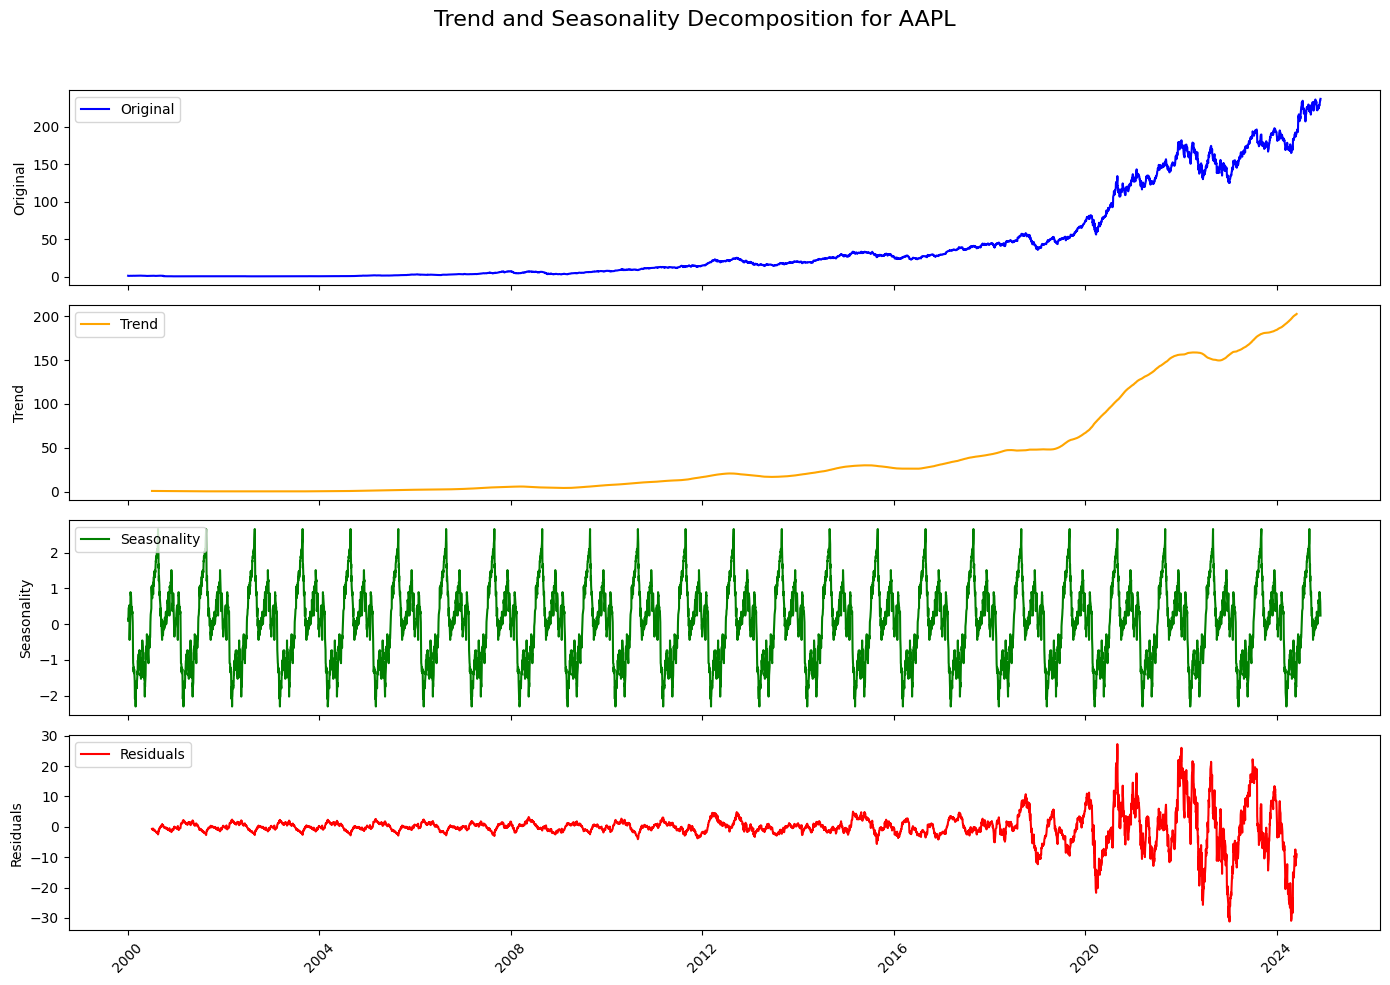

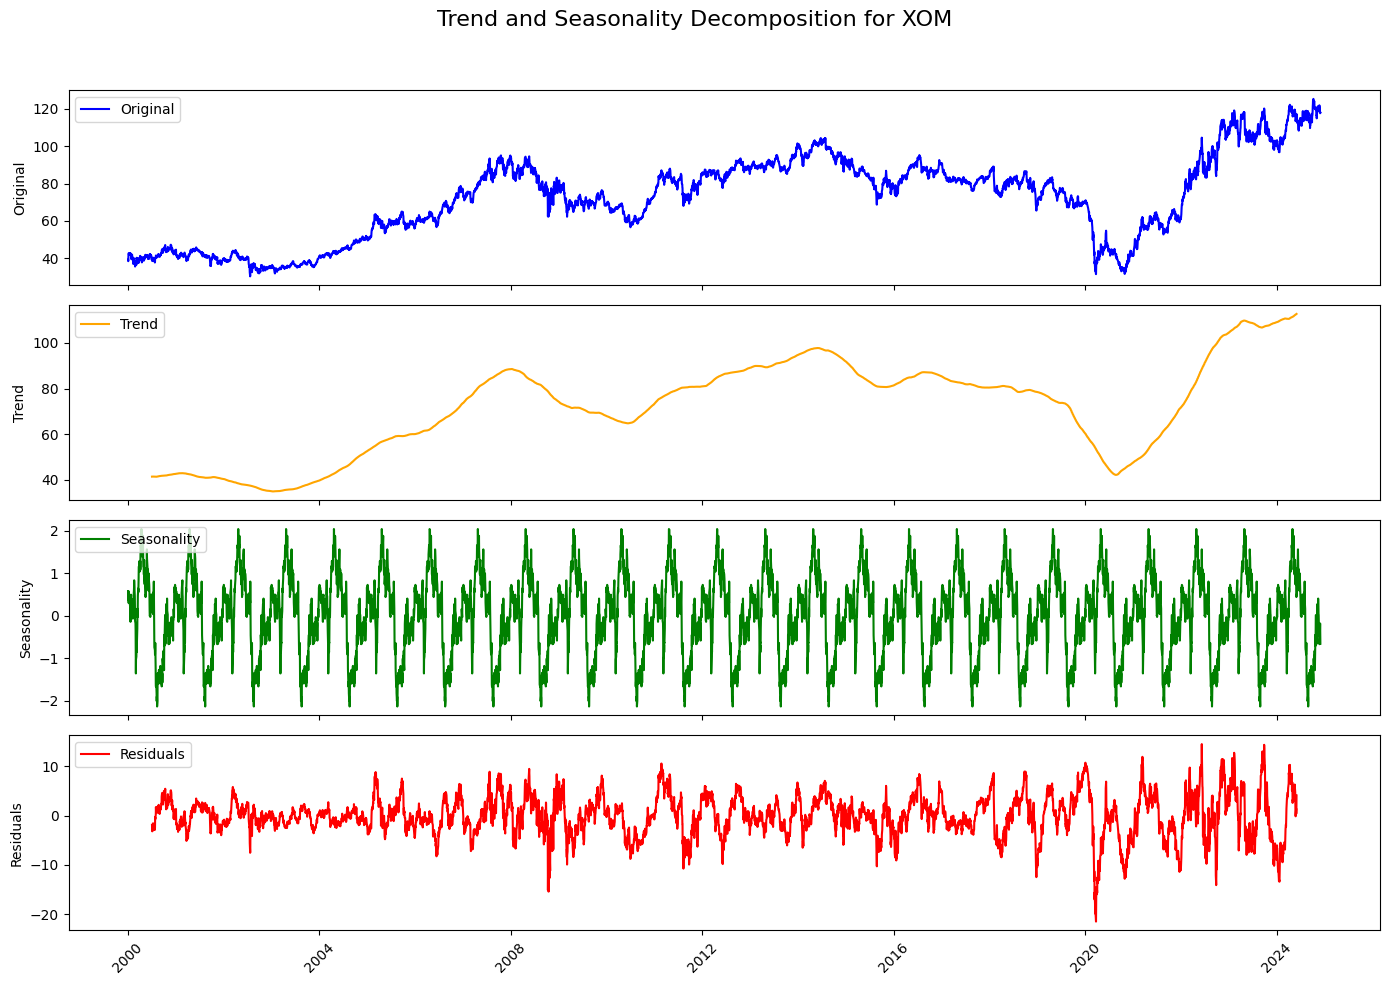

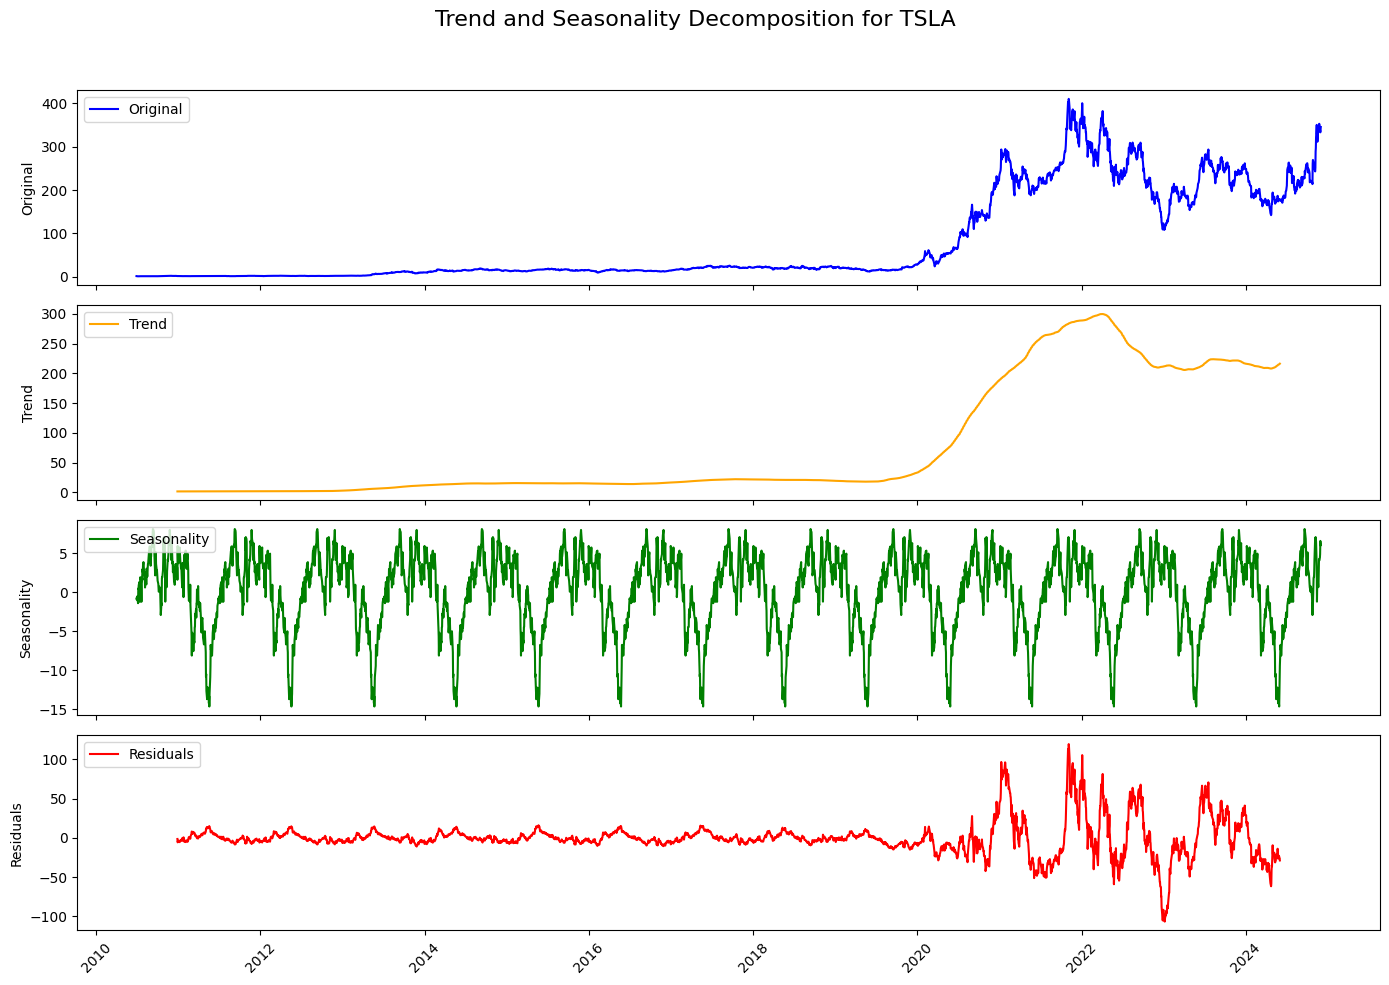

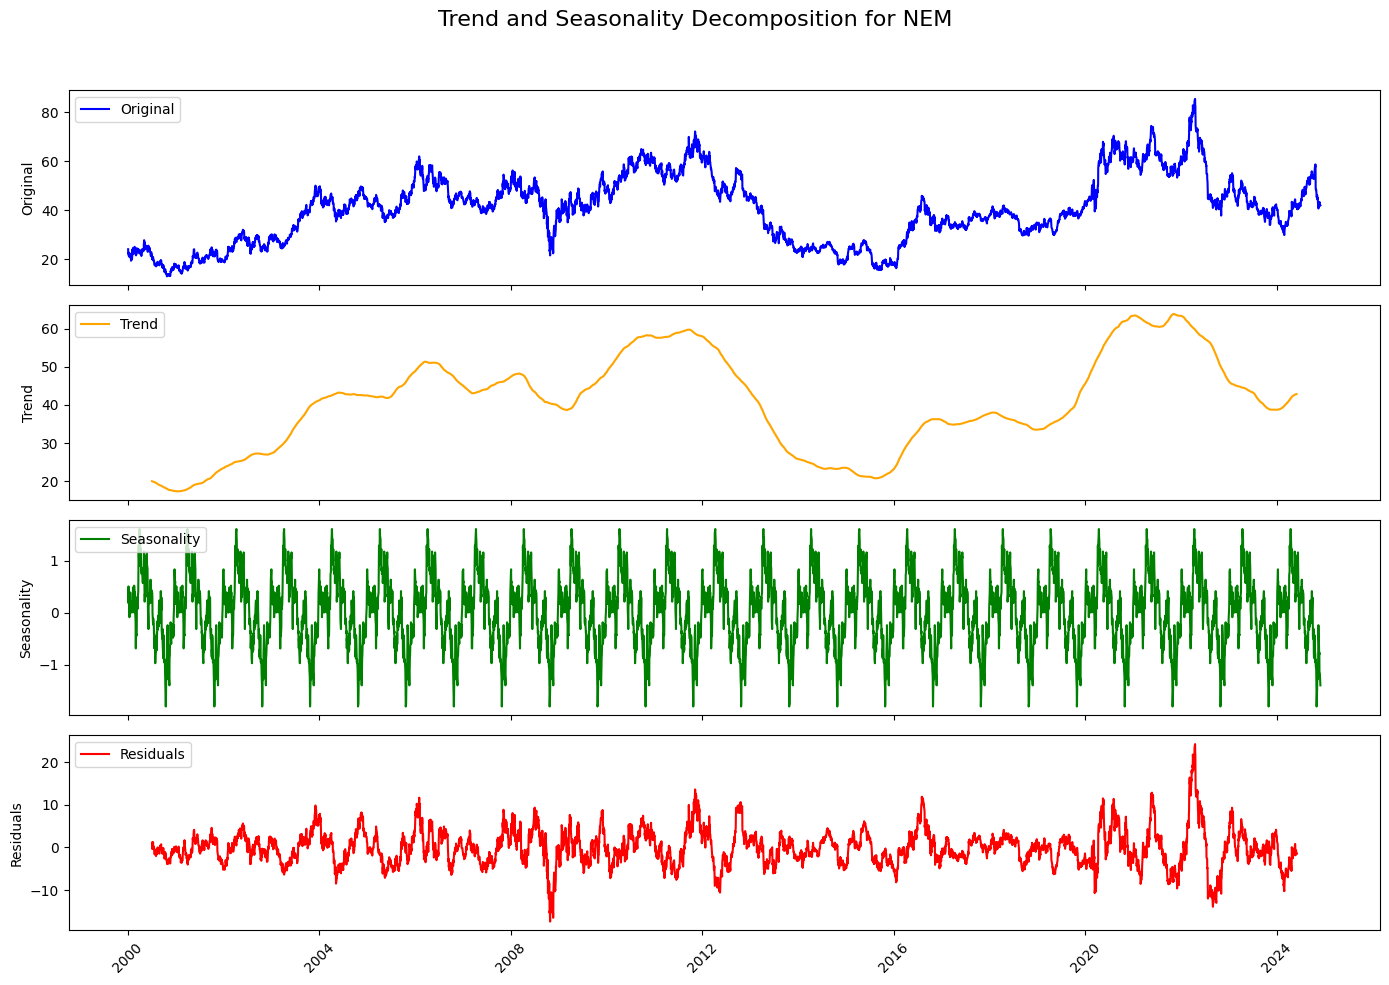

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# List of selected stock tickers
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"  # Folder where your stock data is stored

# Reusable clean_stock_data function
def clean_stock_data(raw_data):
    # Skip metadata rows (if present) and reset column names
    raw_data = raw_data.iloc[2:].copy()  # Assuming metadata occupies the first 2 rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    
    # Convert 'Date' to datetime and drop invalid dates
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)
    
    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')
    
    # Drop rows with all numeric columns as NaN
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Set 'Date' as index
    return raw_data

# Function to analyze trend and seasonality
def analyze_trend_seasonality(tickers, folder):
    for ticker in tickers:
        try:
            # Load and clean data
            file_path = f"{folder}/{ticker}_adjusted.csv"
            raw_data = pd.read_csv(file_path)
            clean_data = clean_stock_data(raw_data)
            
            # Use the 'Close' price for analysis
            stock_data = clean_data['Close']
            
            # Perform seasonal decomposition
            decomposition = seasonal_decompose(stock_data, model="additive", period=252)  # Approx. 1 year
            
            # Plot decomposition
            fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
            fig.suptitle(f"Trend and Seasonality Decomposition for {ticker}", fontsize=16)
            
            # Original data
            axs[0].plot(stock_data, label="Original", color="blue")
            axs[0].set_ylabel("Original")
            axs[0].legend(loc="upper left")
            axs[0].xaxis_date()
            
            # Trend
            axs[1].plot(decomposition.trend, label="Trend", color="orange")
            axs[1].set_ylabel("Trend")
            axs[1].legend(loc="upper left")
            axs[1].xaxis_date()
            
            # Seasonality
            axs[2].plot(decomposition.seasonal, label="Seasonality", color="green")
            axs[2].set_ylabel("Seasonality")
            axs[2].legend(loc="upper left")
            axs[2].xaxis_date()
            
            # Residuals
            axs[3].plot(decomposition.resid, label="Residuals", color="red")
            axs[3].set_ylabel("Residuals")
            axs[3].legend(loc="upper left")
            axs[3].xaxis_date()
            
            plt.xticks(rotation=45)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        
        except Exception as e:
            print(f"Failed to process {ticker}: {e}")

# Run the analysis
analyze_trend_seasonality(selected_stocks, data_folder)


# Trend and Seasonality Analysis of Stock Prices and Log Returns

## Introduction
Trend and seasonality analysis are crucial in understanding stock market dynamics. The **trend** reflects the overall direction of stock prices over time, while **seasonality** captures periodic patterns that occur at regular intervals (e.g., annual fluctuations). Identifying these components helps us model and predict stock price behavior effectively.

In financial time series analysis, **logarithmic returns** (\( R_{\text{log}} = \ln\left(\frac{P_t}{P_{t-1}}\right) \)) are often preferred for the following reasons:
- **Variance Stabilization**: Log returns reduce the impact of extreme values, making the data easier to model.
- **Stationarity**: By focusing on relative changes rather than absolute prices, log returns tend to produce more stationary series, which is essential for many statistical models.
- **Interpretability**: Log returns express percentage changes, simplifying comparisons across different periods or stocks.

This analysis will compare the decompositions of stock prices and their log returns for selected stocks.

---

## Analysis of Stock Prices

### Observations:
1. **AAPL (Apple Inc.)**:
   - The **trend** shows a long-term upward growth, driven by consistent innovation and market leadership.
   - The **seasonality** reflects regular spikes during product launches and the holiday shopping season.
   - The **residuals** highlight deviations caused by market shocks or earnings announcements.

2. **XOM (Exxon Mobil)**:
   - The **trend** captures the cyclical behavior of the energy sector, influenced by global oil prices.
   - The **seasonality** corresponds to fluctuations in demand for energy products.
   - The **residuals** show the impact of oil market volatility and geopolitical events.

3. **TSLA (Tesla Inc.)**:
   - The **trend** reflects Tesla's exponential growth due to its leadership in the EV market.
   - The **seasonality** highlights annual fluctuations, likely tied to production cycles and deliveries.
   - The **residuals** illustrate high market volatility, characteristic of Tesla's stock.

4. **NEM (Newmont Corporation)**:
   - The **trend** is driven by changes in gold prices and macroeconomic conditions.
   - The **seasonality** aligns with global commodity cycles.
   - The **residuals** capture major economic or geopolitical events affecting the gold market.

---

## Analysis of Log Returns

### Why Analyze Log Returns?
- Log returns stabilize variance, making predictions more reliable.
- They tend to remove large, irregular trends, focusing on relative changes.
- Simplifying the data helps in building predictive models, such as ARIMA/SARIMA.

### Observations:
1. **AAPL (Apple Inc.)**:
   - The **trend** in log returns is less pronounced, reflecting stable growth.
   - The **seasonality** remains prominent, capturing regular annual cycles.
   - The **residuals** are lower in magnitude, improving the predictability of the series.

2. **XOM (Exxon Mobil)**:
   - Log returns reduce the impact of extreme oil price changes, highlighting cyclical patterns more clearly.
   - Seasonal variations are consistent with demand cycles in the energy sector.
   - Residuals indicate a better representation of short-term price movements.

3. **TSLA (Tesla Inc.)**:
   - The **trend** in log returns smooths Tesla's exponential growth.
   - Seasonal patterns remain evident but are less affected by outliers.
   - Residuals are more manageable for statistical modeling.

4. **NEM (Newmont Corporation)**:
   - Log returns simplify trends tied to gold price movements.
   - Seasonality highlights predictable commodity cycles.
   - Residuals are more contained, focusing on short-term fluctuations.

---

## Next Steps
1. **ARIMA/SARIMA Modeling**:
   - Use log returns for ARIMA/SARIMA to leverage the benefits of stabilized variance and stationarity.
   - Identify optimal parameters (\(p, d, q\) and seasonal components) using the decompositions above.
2. **Forecasting**:
   - Build predictive models and evaluate their performance using historical data.
3. **Comparison**:
   - Compare the accuracy of predictions using raw prices versus log returns to emphasize the advantages of using log returns.


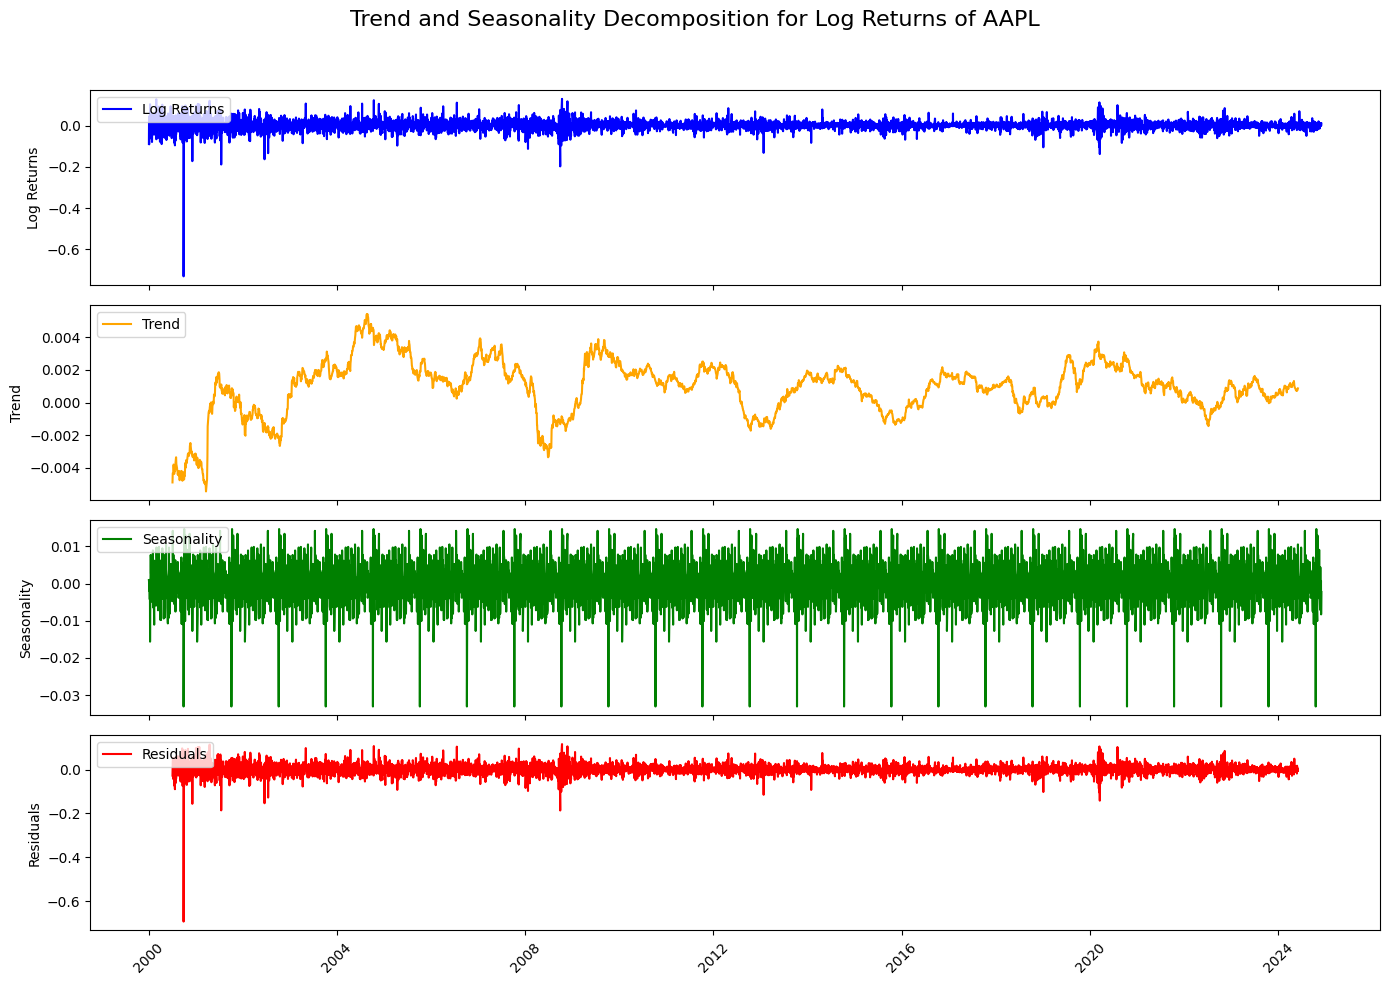

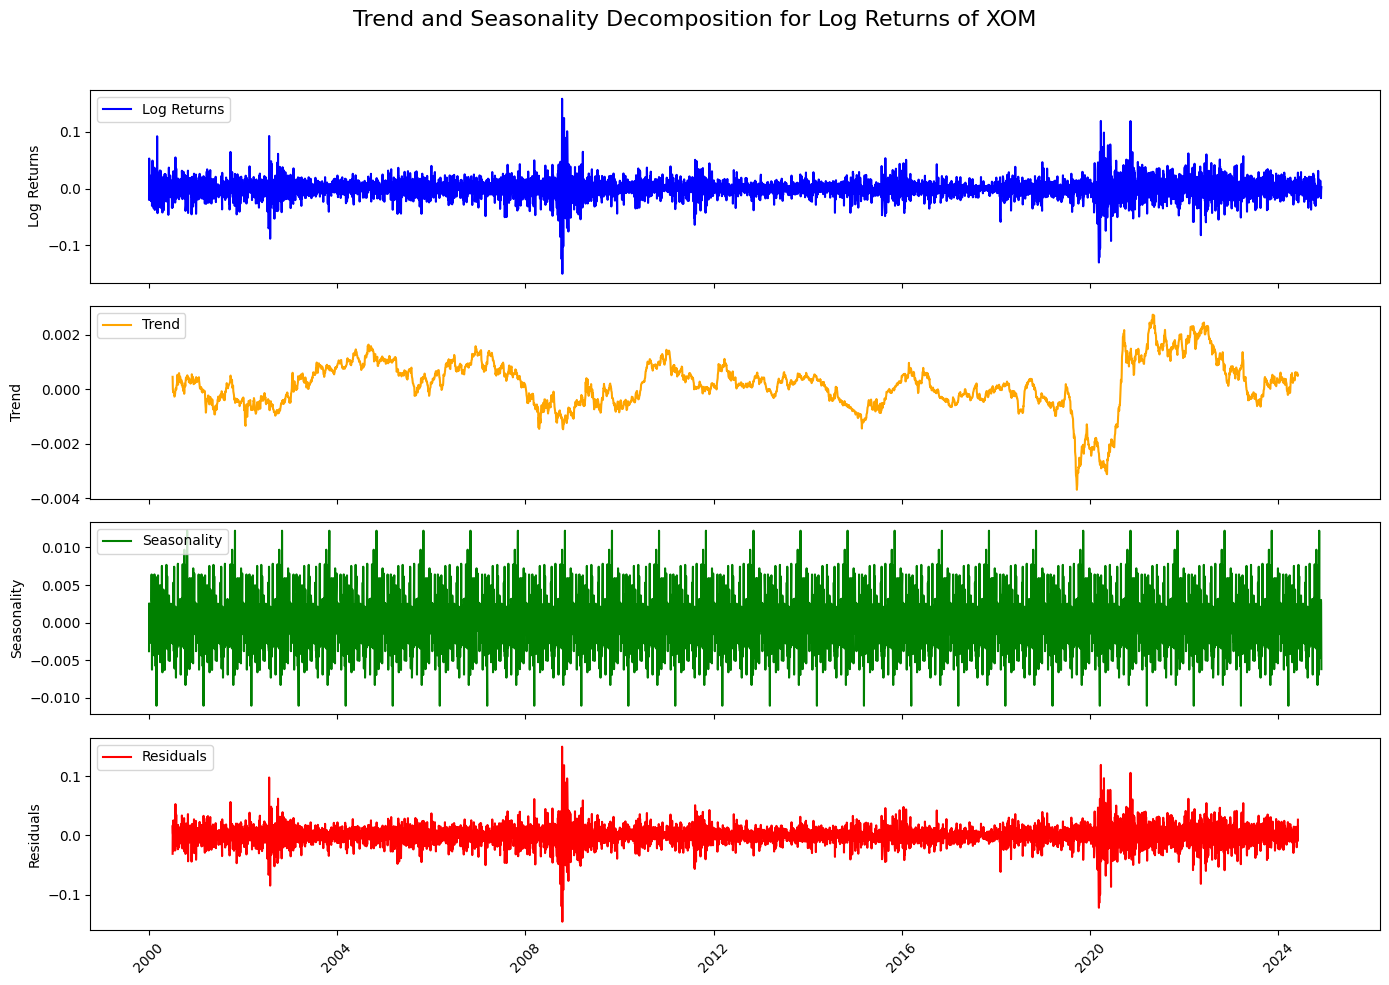

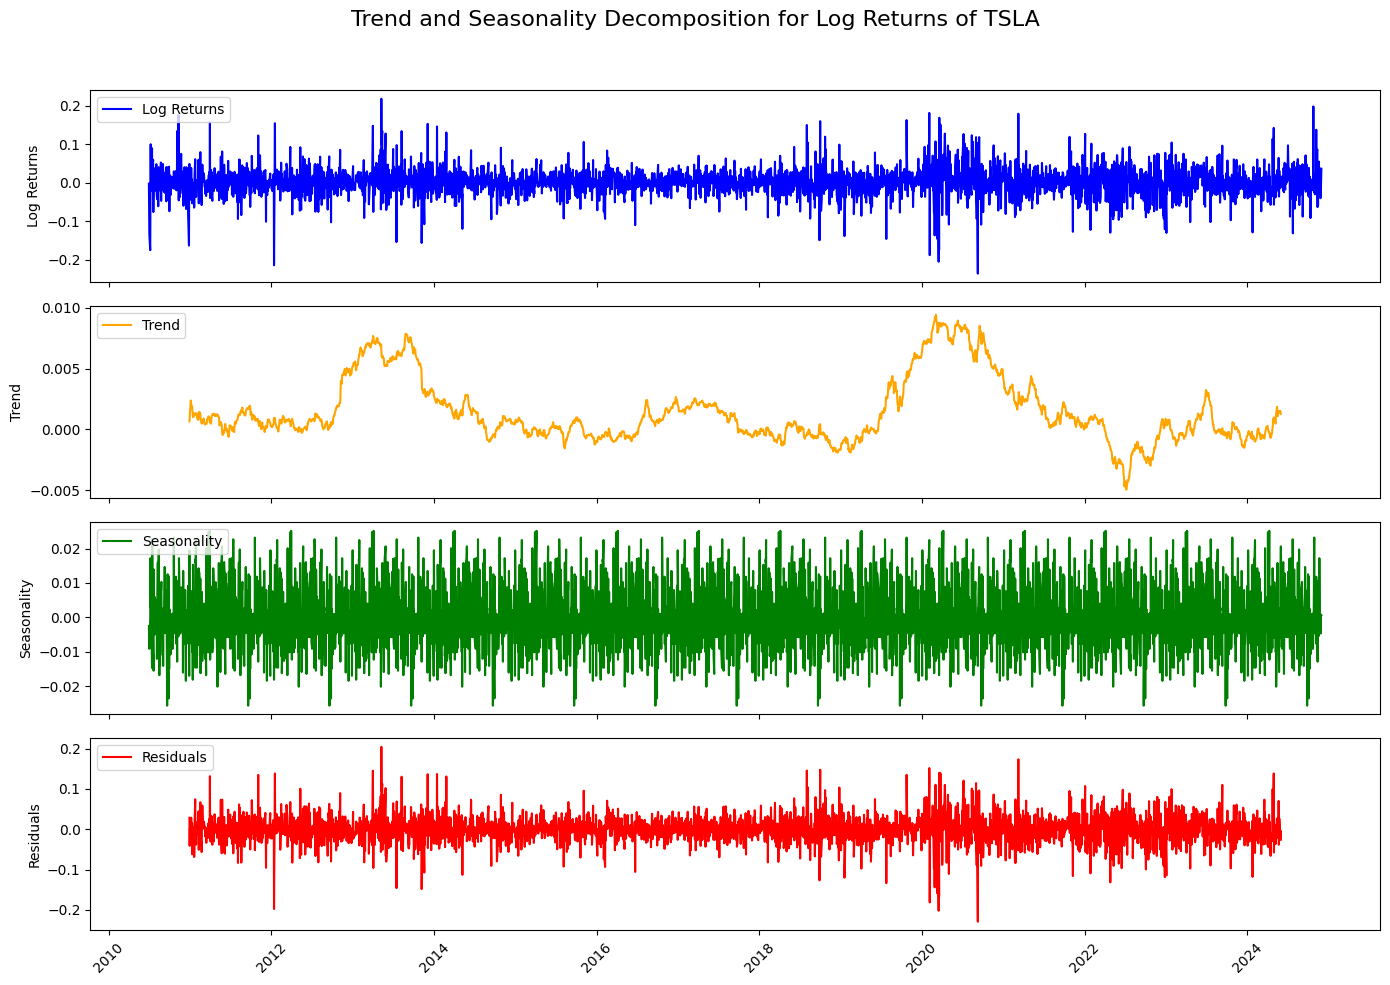

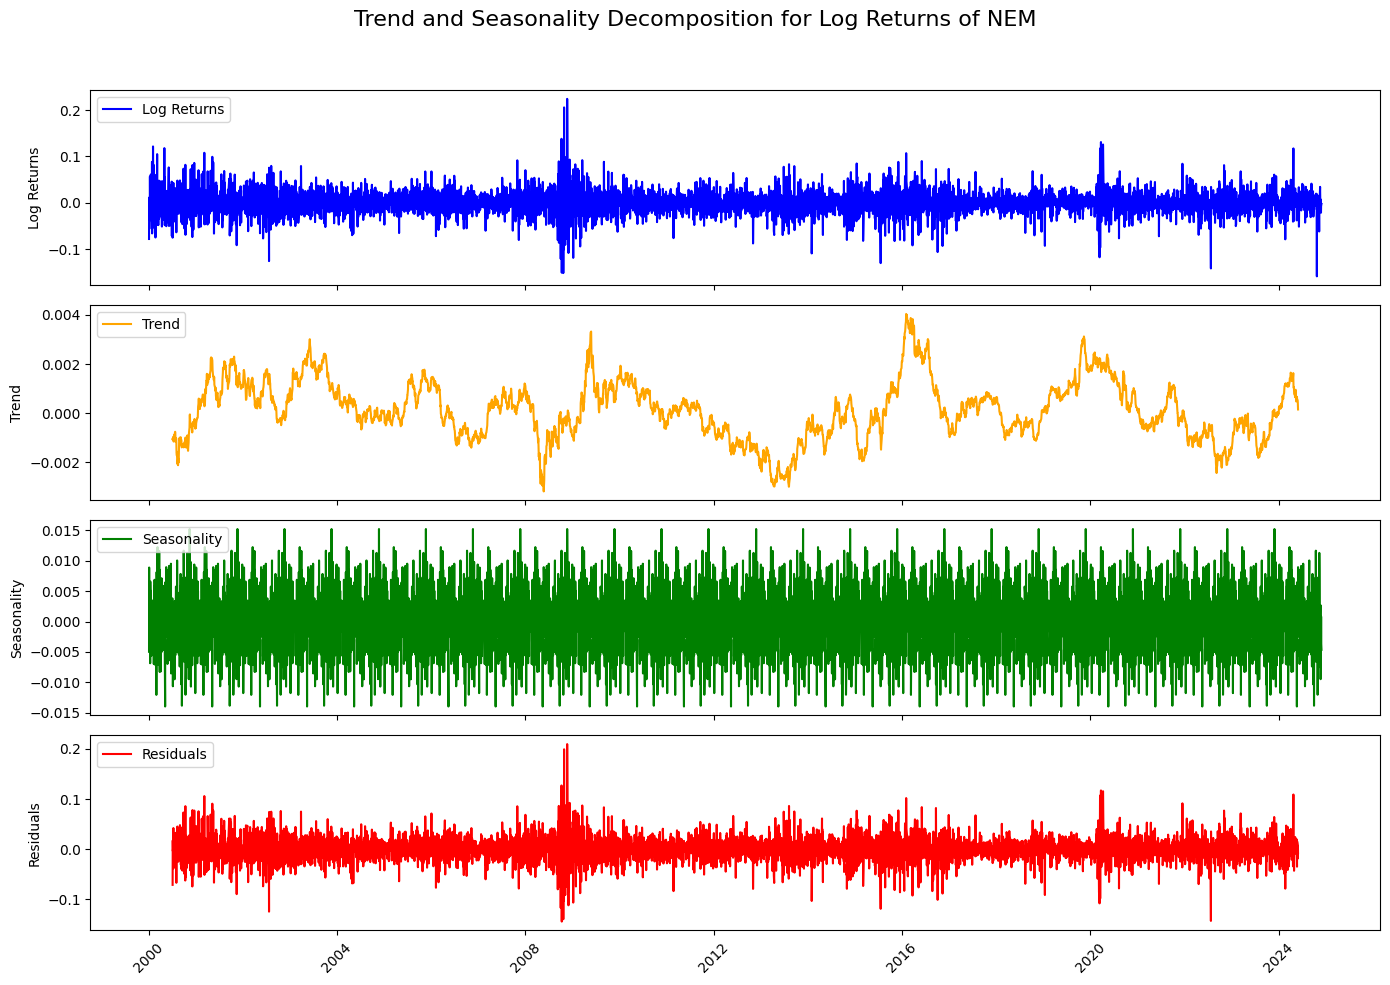

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# List of selected stock tickers
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"  # Folder where your stock data is stored

# Reusable clean_stock_data function
def clean_stock_data(raw_data):
    # Skip metadata rows (if present) and reset column names
    raw_data = raw_data.iloc[2:].copy()  # Assuming metadata occupies the first 2 rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    
    # Convert 'Date' to datetime and drop invalid dates
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)
    
    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')
    
    # Drop rows with all numeric columns as NaN
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Set 'Date' as index
    return raw_data

# Function to compute log returns
def compute_log_returns(data):
    log_returns = np.log(data / data.shift(1))
    return log_returns.dropna()  # Drop NaN values caused by shifting

# Function to analyze trend and seasonality for log returns
def analyze_trend_seasonality_log_returns(tickers, folder):
    for ticker in tickers:
        try:
            # Load and clean data
            file_path = f"{folder}/{ticker}_adjusted.csv"
            raw_data = pd.read_csv(file_path)
            clean_data = clean_stock_data(raw_data)
            
            # Compute log returns for analysis
            log_returns = compute_log_returns(clean_data['Close'])
            
            # Perform seasonal decomposition
            decomposition = seasonal_decompose(log_returns, model="additive", period=252)  # Approx. 1 year
            
            # Plot decomposition
            fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
            fig.suptitle(f"Trend and Seasonality Decomposition for Log Returns of {ticker}", fontsize=16)
            
            # Original log returns
            axs[0].plot(log_returns, label="Log Returns", color="blue")
            axs[0].set_ylabel("Log Returns")
            axs[0].legend(loc="upper left")
            axs[0].xaxis_date()
            
            # Trend
            axs[1].plot(decomposition.trend, label="Trend", color="orange")
            axs[1].set_ylabel("Trend")
            axs[1].legend(loc="upper left")
            axs[1].xaxis_date()
            
            # Seasonality
            axs[2].plot(decomposition.seasonal, label="Seasonality", color="green")
            axs[2].set_ylabel("Seasonality")
            axs[2].legend(loc="upper left")
            axs[2].xaxis_date()
            
            # Residuals
            axs[3].plot(decomposition.resid, label="Residuals", color="red")
            axs[3].set_ylabel("Residuals")
            axs[3].legend(loc="upper left")
            axs[3].xaxis_date()
            
            plt.xticks(rotation=45)
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        
        except Exception as e:
            print(f"Failed to process {ticker}: {e}")

# Run the analysis for log returns
analyze_trend_seasonality_log_returns(selected_stocks, data_folder)


## Interpretation and Comparison of Trend and Seasonality Decomposition for Log Returns and Prices

### General Overview
The decomposition results for both prices and log returns provide critical insights into the components of the time series data: trend, seasonality, and residuals. While the analysis of prices reveals clear long-term patterns, the log returns analysis highlights short-term variations, which are crucial for financial modeling and forecasting.

---

### Log Returns Decomposition (Current Results)

1. **Log Returns:**
   - The log returns exhibit rapid fluctuations around zero, indicating the relative price changes over time. 
   - Large spikes represent significant market movements, both upwards and downwards.

2. **Trend:**
   - The trend component in log returns is smoother compared to the raw log returns, showing long-term changes in market volatility rather than absolute prices.
   - Compared to prices, the log returns trend is minimal, reflecting the stationarity of the returns series.

3. **Seasonality:**
   - Seasonality in log returns is relatively small but recurring. The periodicity matches that of the price series, but the magnitude is much lower.
   - Seasonal effects likely represent consistent, cyclical investor behaviors.

4. **Residuals:**
   - Residuals for log returns are smaller in magnitude but still capture the random noise in the data.
   - Sharp residual spikes coincide with extreme market events.

---

### Prices Decomposition (Previously Shared Results)

1. **Prices:**
   - Prices display clear upward or downward trends over the years. For instance, AAPL shows a persistent increase, while XOM displays cyclical behavior.
   - Large price swings reflect significant historical events or changes in the underlying asset's value.

2. **Trend:**
   - The trend in prices is a dominant component, capturing the long-term movement of the stock.
   - It highlights growth phases (e.g., TSLA’s rapid growth) or stagnation periods (e.g., NEM's fluctuating plateau).

3. **Seasonality:**
   - Prices show significant seasonality, with consistent patterns likely driven by earnings seasons, dividends, or economic cycles.
   - The seasonality is more pronounced in prices compared to log returns.

4. **Residuals:**
   - Residuals for prices are much larger and capture unexplained volatility that cannot be attributed to trends or seasonality.
   - Events like earnings surprises or macroeconomic shocks are reflected here.

---

### Comparison Between Log Returns and Prices

| Component    | Prices                                      | Log Returns                                  |
|--------------|--------------------------------------------|---------------------------------------------|
| **Magnitude**| Larger swings due to compounding growth.    | Smaller fluctuations around zero.            |
| **Trend**    | Dominant, capturing long-term growth.       | Minimal, reflecting near-stationarity.       |
| **Seasonality** | Clear, periodic patterns.                 | Subdued but still present.                   |
| **Residuals**| Large, capturing extreme events.            | Smaller but sensitive to market movements.   |

---

### Key Observations

1. **Prediction Implications:**
   - Log returns are stationary, making them more suitable for ARIMA/SARIMA modeling.
   - The absence of a strong trend in log returns simplifies forecasting compared to prices.

2. **Seasonality:**
   - Both prices and log returns exhibit seasonality, but its magnitude is more pronounced in prices.
   - Seasonality in log returns represents relative changes, whereas in prices, it reflects absolute periodic variations.

3. **Volatility Representation:**
   - Log returns highlight volatility directly, making them ideal for risk analysis and volatility forecasting.
   - Prices capture absolute changes, which are harder to model due to compounding effects.

---

### Conclusion
The decomposition of log returns simplifies the dataset by focusing on stationarity and relative changes, which are essential for financial forecasting and statistical modeling. In contrast, price decomposition provides richer insights into long-term behaviors and absolute movements, valuable for macroeconomic and historical analyses. By using log returns, we prepare a cleaner dataset for predictive modeling, enabling a robust ARIMA/SARIMA implementation in the next steps.


Processing stock: AAPL
First few training prices for AAPL:
 Date
2000-01-03 00:00:00+00:00   0.84
2000-01-04 00:00:00+00:00   0.77
2000-01-05 00:00:00+00:00   0.78
2000-01-06 00:00:00+00:00   0.72
2000-01-07 00:00:00+00:00   0.75
Name: Adj Close, dtype: float64
Running Auto ARIMA for AAPL...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.78 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6184.959, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4946.692, Time=0.25 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6182.960, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4328.841, Time=0.34 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3884.556, Time=0.66 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3645.530, Time=0.84 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=3490.093, Time=1.03 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=2777.223, Time=5.71 sec
 ARIMA(4,2,1)(

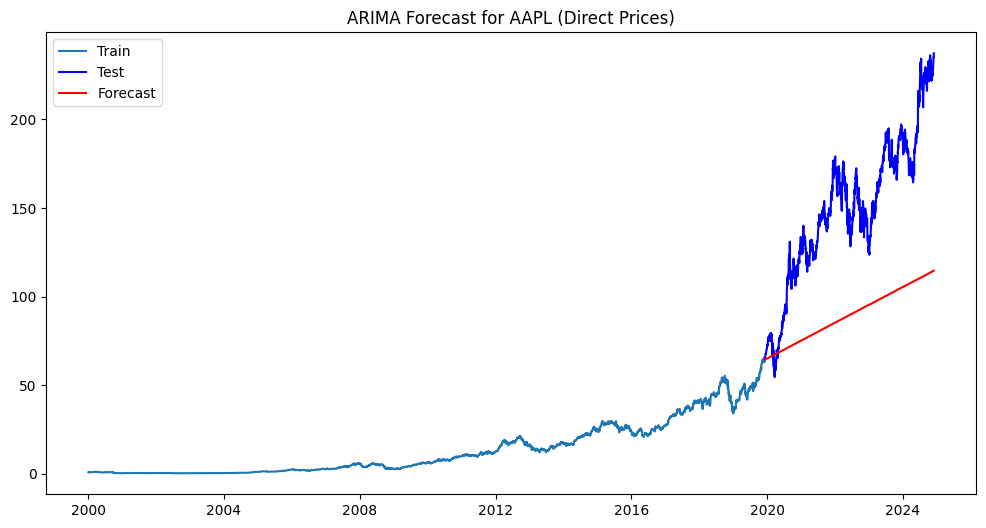

AAPL - Mean Squared Error: 4433.966431960571
Completed processing for AAPL.

Processing stock: XOM
First few training prices for XOM:
 Date
2000-01-03 00:00:00+00:00   17.89
2000-01-04 00:00:00+00:00   17.55
2000-01-05 00:00:00+00:00   18.50
2000-01-06 00:00:00+00:00   19.46
2000-01-07 00:00:00+00:00   19.40
Name: Adj Close, dtype: float64
Running Auto ARIMA for XOM...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9089.334, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9137.174, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9104.923, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9100.401, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9135.880, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9087.866, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9087.473, Time=0.39 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9088.169, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9090.247, Time=

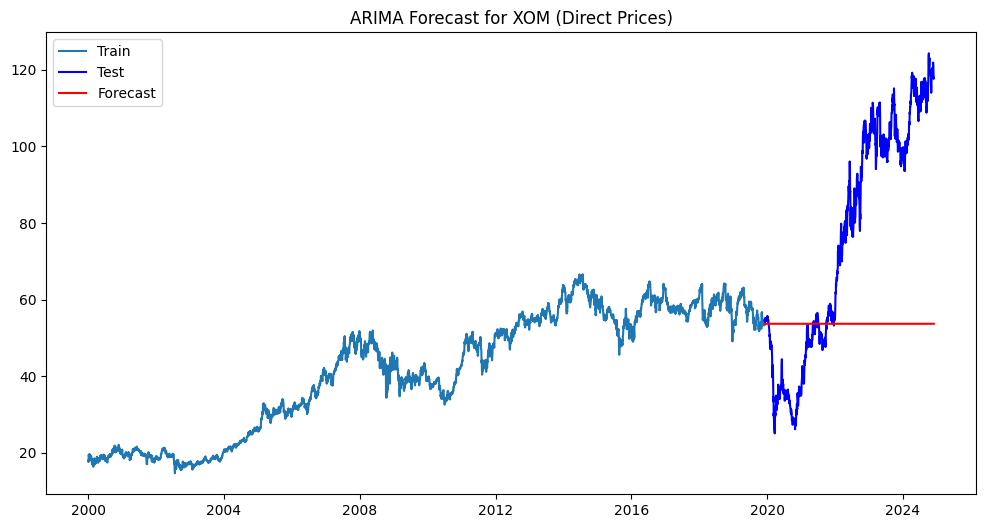

XOM - Mean Squared Error: 1421.4844909136734
Completed processing for XOM.

Processing stock: TSLA
First few training prices for TSLA:
 Date
2010-06-29 00:00:00+00:00   1.59
2010-06-30 00:00:00+00:00   1.59
2010-07-01 00:00:00+00:00   1.46
2010-07-02 00:00:00+00:00   1.28
2010-07-06 00:00:00+00:00   1.07
Name: Adj Close, dtype: float64
Running Auto ARIMA for TSLA...
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=17348.716, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=16490.327, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=17346.719, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=16044.091, Time=0.23 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=15894.361, Time=0.31 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=15766.794, Time=0.35 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=15712.291, Time=0.44 s

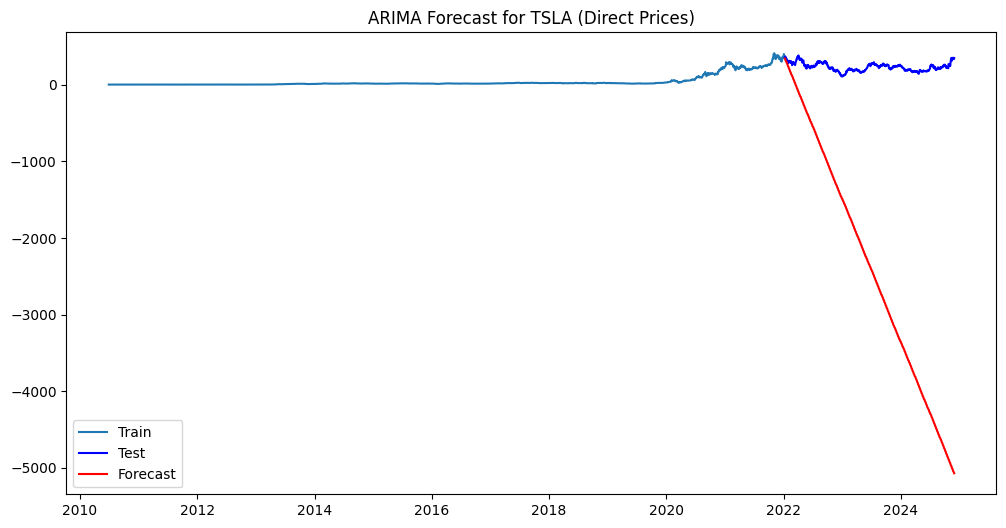

TSLA - Mean Squared Error: 9134676.407875307
Completed processing for TSLA.

Processing stock: NEM
First few training prices for NEM:
 Date
2000-01-03 00:00:00+00:00   16.06
2000-01-04 00:00:00+00:00   14.85
2000-01-05 00:00:00+00:00   15.02
2000-01-06 00:00:00+00:00   14.85
2000-01-07 00:00:00+00:00   14.31
Name: Adj Close, dtype: float64
Running Auto ARIMA for NEM...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9823.463, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9831.318, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9822.389, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9821.688, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9829.475, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9819.619, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9821.457, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9821.461, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9819.461, Time=

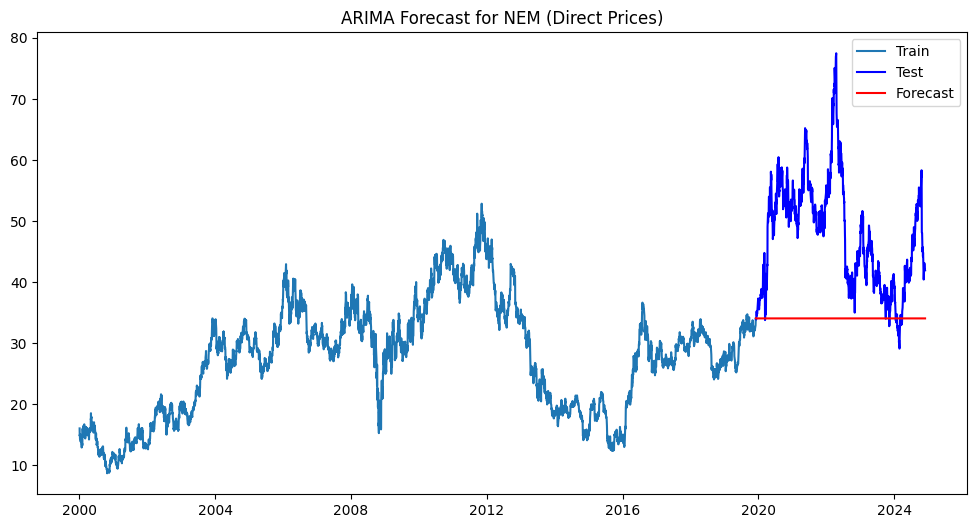

NEM - Mean Squared Error: 269.2739424475445
Completed processing for NEM.



In [85]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)
    
    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')
    
    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Function to Check Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    return result[1] <= 0.05

def arima_forecast_direct_prices(data, ticker):
    """ARIMA forecasting directly on prices without manual differencing."""
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    # Debug: Ensure raw prices are being passed
    print(f"First few training prices for {ticker}:\n", train.head())
    
    # Auto ARIMA for parameter selection
    print(f"Running Auto ARIMA for {ticker}...")
    model = auto_arima(train, seasonal=False, trace=True, error_action="ignore", suppress_warnings=True)

    print(f"Best ARIMA Order for {ticker}: {model.order}")
    
    # Fit SARIMAX model
    try:
        # Fit the model directly on raw prices
        fitted_model = SARIMAX(train, order=model.order).fit(disp=False)
        print(f"Model successfully fitted for {ticker}.")
        
        # Forecast prices directly
        forecast = fitted_model.get_forecast(steps=len(test))
        forecast_values = forecast.predicted_mean  # Extract predicted values
        forecast_values.index = test.index  # Align with test data index
        
        # Debug: Check forecasted prices
        print(f"First few forecasted prices for {ticker}:\n", forecast_values.head())
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(train, label="Train")
        plt.plot(test, label="Test", color="blue")
        plt.plot(forecast_values, label="Forecast", color="red")
        plt.title(f"ARIMA Forecast for {ticker} (Direct Prices)")
        plt.legend()
        plt.show()
        
        # Calculate MSE
        mse = mean_squared_error(test, forecast_values)
        print(f"{ticker} - Mean Squared Error: {mse}")
        return forecast_values, mse
    except Exception as e:
        print(f"Failed to fit or forecast for {ticker}: {e}")
        return None, None

# List of Stocks and Data Folder
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

# Main Workflow
for ticker in selected_stocks:
    try:
        print(f"Processing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"
        
        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)
        
        # Extract prices for analysis
        prices = clean_data['Adj Close']
        
        # Forecast directly on prices
        forecast, mse = arima_forecast_direct_prices(prices, ticker)
        print(f"Completed processing for {ticker}.\n")
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")

Processing stock: AAPL
First few training log returns for AAPL:
 Date
2000-01-04 00:00:00+00:00   -0.09
2000-01-05 00:00:00+00:00    0.01
2000-01-06 00:00:00+00:00   -0.09
2000-01-07 00:00:00+00:00    0.05
2000-01-10 00:00:00+00:00   -0.02
Name: Adj Close, dtype: float64
Running Auto ARIMA for AAPL...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-22182.152, Time=1.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22185.832, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-22187.692, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22187.718, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-22185.581, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-22185.716, Time=0.64 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-22183.731, Time=1.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-22191.404, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-22189.188, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=

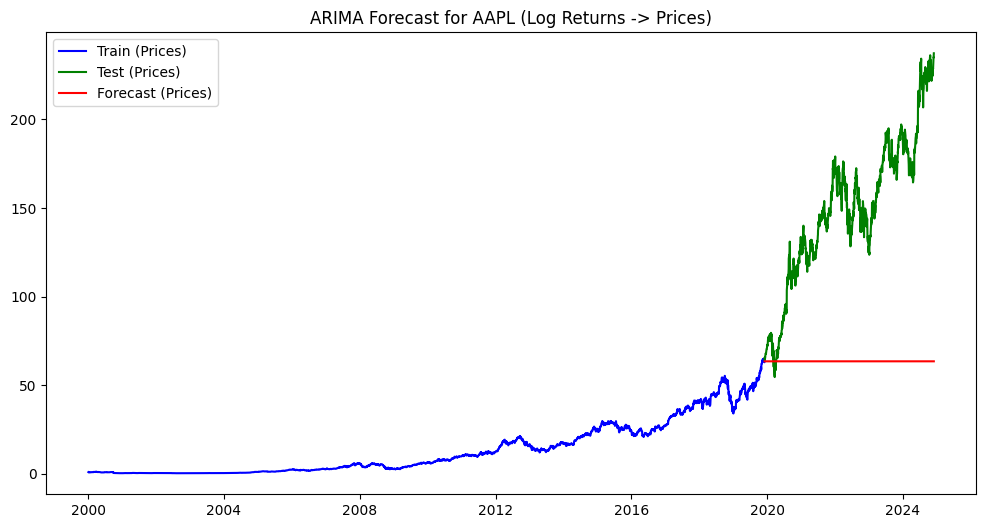

Failed to fit or forecast for AAPL: Found input variables with inconsistent numbers of samples: [1255, 1254]
Completed processing for AAPL.

Processing stock: XOM
First few training log returns for XOM:
 Date
2000-01-04 00:00:00+00:00   -0.02
2000-01-05 00:00:00+00:00    0.05
2000-01-06 00:00:00+00:00    0.05
2000-01-07 00:00:00+00:00   -0.00
2000-01-10 00:00:00+00:00   -0.01
Name: Adj Close, dtype: float64
Running Auto ARIMA for XOM...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-27925.658, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-27844.774, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-27887.760, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-27896.882, Time=0.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-27927.605, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-27926.791, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-27913.683, Time=0.44 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AI

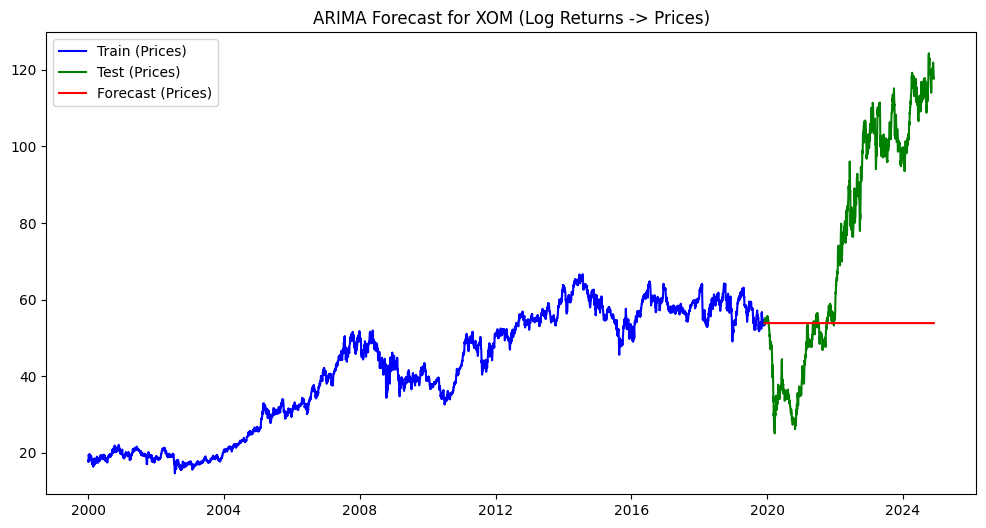

Failed to fit or forecast for XOM: Found input variables with inconsistent numbers of samples: [1255, 1254]
Completed processing for XOM.

Processing stock: TSLA
First few training log returns for TSLA:
 Date
2010-06-30 00:00:00+00:00   -0.00
2010-07-01 00:00:00+00:00   -0.08
2010-07-02 00:00:00+00:00   -0.13
2010-07-06 00:00:00+00:00   -0.18
2010-07-07 00:00:00+00:00   -0.02
Name: Adj Close, dtype: float64
Running Auto ARIMA for TSLA...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11163.058, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11170.806, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-11168.912, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-11168.882, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11166.911, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-11176.857, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-11174.888, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : A

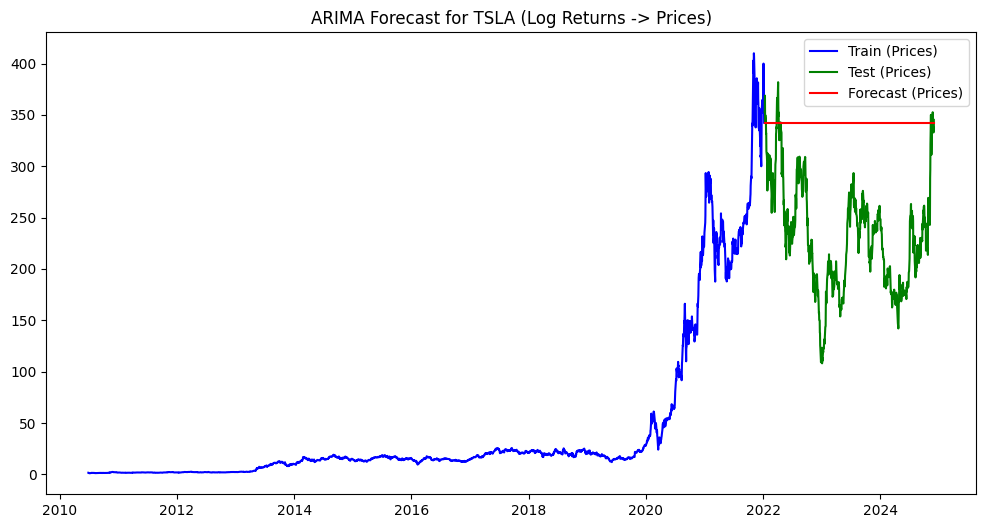

Failed to fit or forecast for TSLA: Found input variables with inconsistent numbers of samples: [727, 726]
Completed processing for TSLA.

Processing stock: NEM
First few training log returns for NEM:
 Date
2000-01-04 00:00:00+00:00   -0.08
2000-01-05 00:00:00+00:00    0.01
2000-01-06 00:00:00+00:00   -0.01
2000-01-07 00:00:00+00:00   -0.04
2000-01-10 00:00:00+00:00   -0.00
Name: Adj Close, dtype: float64
Running Auto ARIMA for NEM...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-22754.594, Time=1.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22729.304, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-22748.835, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-22750.519, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-22753.108, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-22753.047, Time=0.57 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-22749.762, Time=1.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=

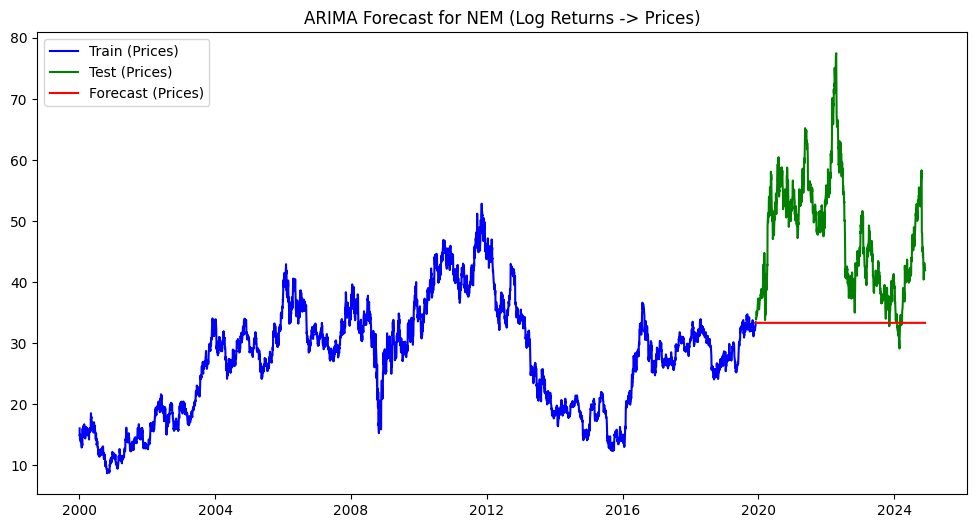

Failed to fit or forecast for NEM: Found input variables with inconsistent numbers of samples: [1255, 1254]
Completed processing for NEM.



In [91]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmdarima import auto_arima

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)
    
    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')
    
    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Function to Check Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    return result[1] <= 0.05

def arima_forecast_log_returns(data, ticker):
    """ARIMA forecasting on log returns."""
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    # Debug: Ensure log returns are being passed
    print(f"First few training log returns for {ticker}:\n", train.head())
    
    # Auto ARIMA for parameter selection
    print(f"Running Auto ARIMA for {ticker}...")
    model = auto_arima(train, seasonal=False, trace=True, error_action="ignore", suppress_warnings=True)

    print(f"Best ARIMA Order for {ticker}: {model.order}")
    
    try:
        # Fit SARIMAX model on log returns
        fitted_model = SARIMAX(train, order=model.order).fit(disp=False)
        print(f"Model successfully fitted for {ticker}.")
        
        # Forecast log returns
        forecast = fitted_model.get_forecast(steps=len(test))
        forecast_values = forecast.predicted_mean  # Predicted log returns
        forecast_values.index = test.index  # Align with test data index
        
        # Reconstruct prices from log returns
        last_train_price = clean_data['Adj Close'].iloc[train_size - 1]  # Last actual price in training
        train_prices = clean_data['Adj Close'].iloc[:train_size]  # Original train prices
        test_prices = clean_data['Adj Close'].iloc[train_size:]  # Original test prices
        reconstructed_forecast_prices = last_train_price * np.exp(forecast_values.cumsum())
        
        # Debug: Check forecasted prices
        print(f"First few forecasted prices for {ticker}:\n", reconstructed_forecast_prices.head())
        
        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(train_prices, label="Train (Prices)", color="blue")
        plt.plot(test_prices, label="Test (Prices)", color="green")
        plt.plot(reconstructed_forecast_prices, label="Forecast (Prices)", color="red")
        plt.title(f"ARIMA Forecast for {ticker} (Log Returns -> Prices)")
        plt.legend()
        plt.show()
        
        # Calculate MSE
        mse = mean_squared_error(test_prices, reconstructed_forecast_prices)
        print(f"{ticker} - Mean Squared Error: {mse}")
        return reconstructed_forecast_prices, mse
    except Exception as e:
        print(f"Failed to fit or forecast for {ticker}: {e}")
        return None, None

# Main Workflow
for ticker in selected_stocks:
    try:
        print(f"Processing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"
        
        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)
        
        # Compute log returns
        log_returns = np.log(clean_data['Adj Close'] / clean_data['Adj Close'].shift(1)).dropna()
        
        # Forecast on log returns
        forecast, mse = arima_forecast_log_returns(log_returns, ticker)
        print(f"Completed processing for {ticker}.\n")
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Starting rolling ARIMA forecasting for AAPL...

Processing Lookback Period: 80 days...
  Rolling window step 0/651...
  Rolling window step 100/651...
  Rolling window step 200/651...
  Rolling window step 300/651...
    Error at step 350 with lookback 80: LU decomposition error.
  Rolling window step 400/651...
  Rolling window step 500/651...
  Rolling window step 600/651...
Lookback Period: 80 - MSE: 89.02012746997235


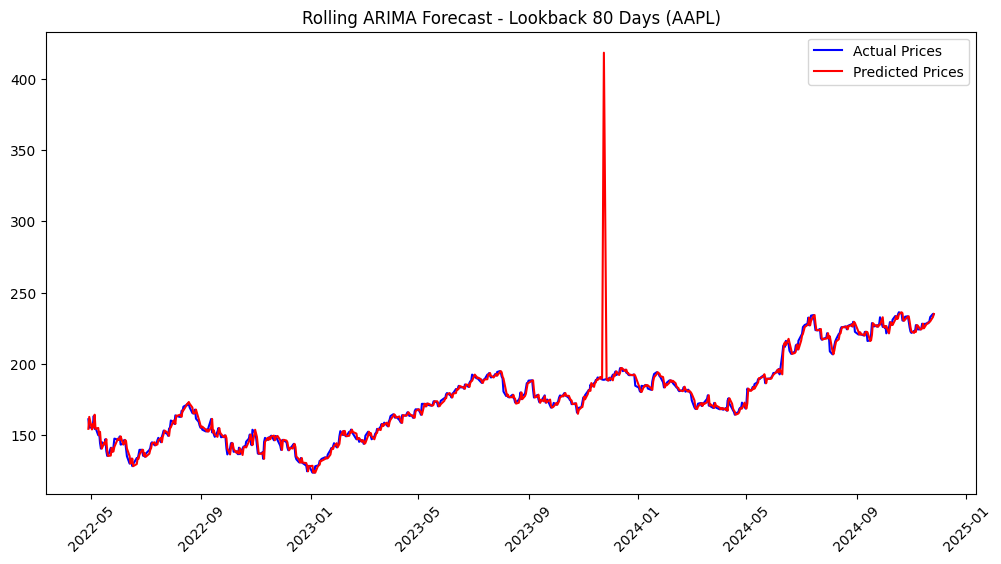


Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 7.617404898118179


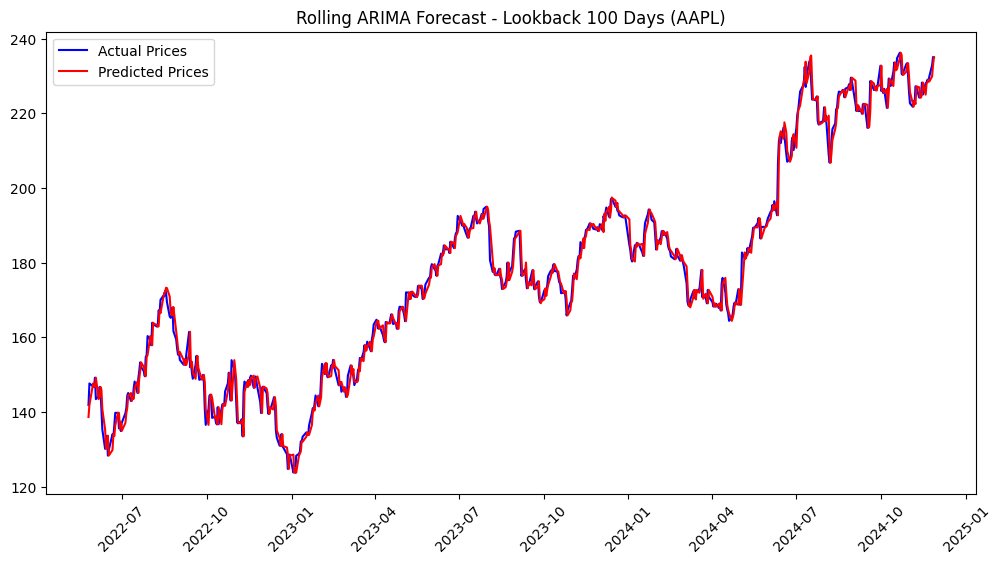

Completed processing for AAPL.


Processing stock: XOM
Starting rolling ARIMA forecasting for XOM...

Processing Lookback Period: 80 days...
  Rolling window step 0/651...
  Rolling window step 100/651...
  Rolling window step 200/651...
  Rolling window step 300/651...
  Rolling window step 400/651...
  Rolling window step 500/651...
  Rolling window step 600/651...
Lookback Period: 80 - MSE: 2.7301450801623526


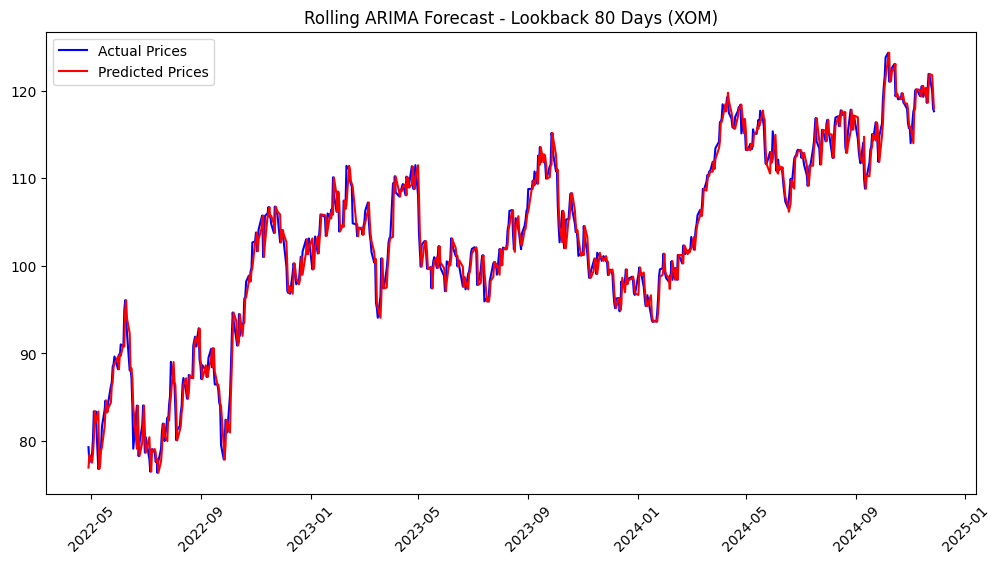


Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 2.689000396147398


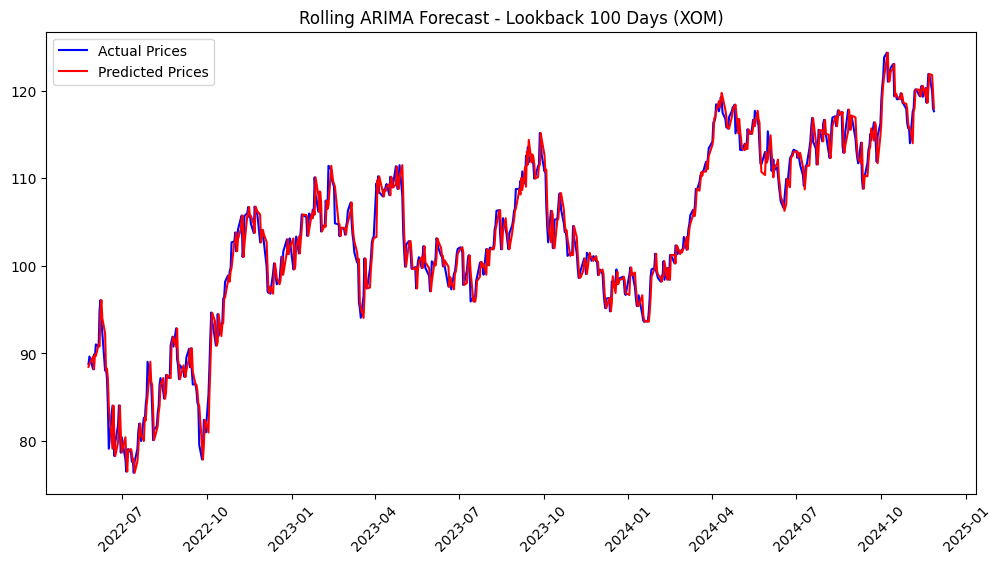

Completed processing for XOM.


Processing stock: TSLA
Starting rolling ARIMA forecasting for TSLA...

Processing Lookback Period: 80 days...
  Rolling window step 0/651...
  Rolling window step 100/651...
  Rolling window step 200/651...
  Rolling window step 300/651...
  Rolling window step 400/651...
  Rolling window step 500/651...
  Rolling window step 600/651...
Lookback Period: 80 - MSE: 73.24726049365147


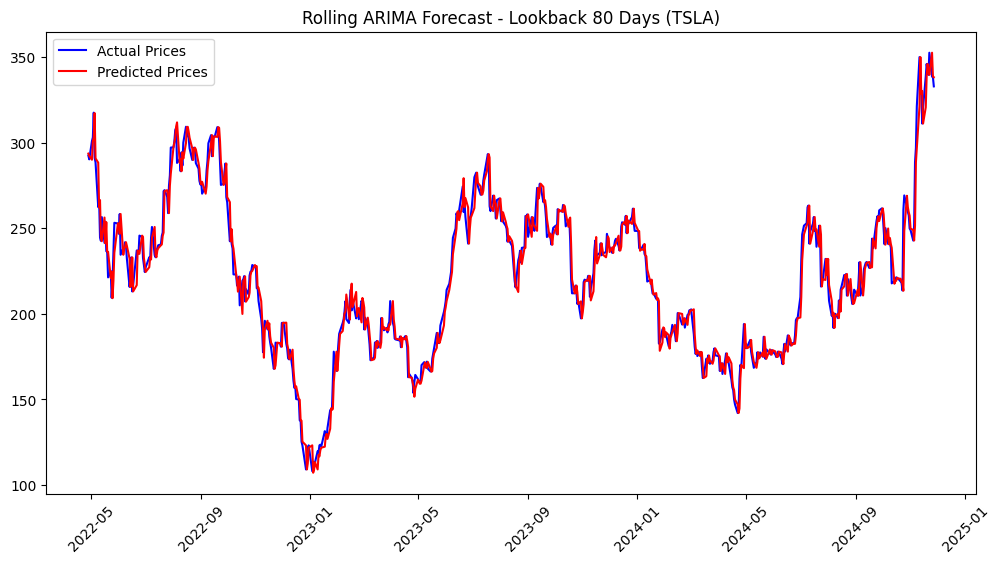


Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 68.556634777226


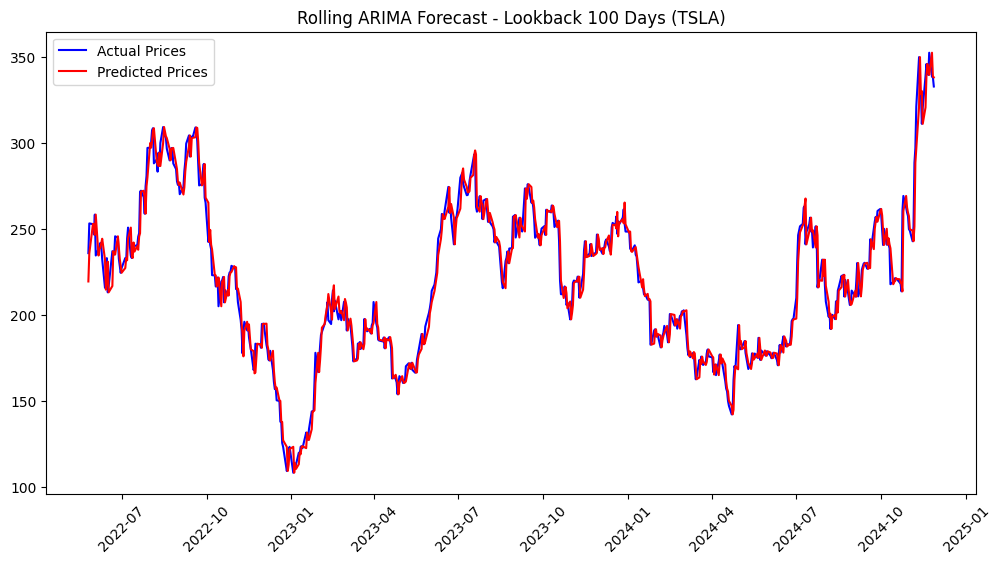

Completed processing for TSLA.


Processing stock: NEM
Starting rolling ARIMA forecasting for NEM...

Processing Lookback Period: 80 days...
  Rolling window step 0/651...
  Rolling window step 100/651...
  Rolling window step 200/651...
  Rolling window step 300/651...
  Rolling window step 400/651...
  Rolling window step 500/651...
  Rolling window step 600/651...
Lookback Period: 80 - MSE: 1.0029302986958977


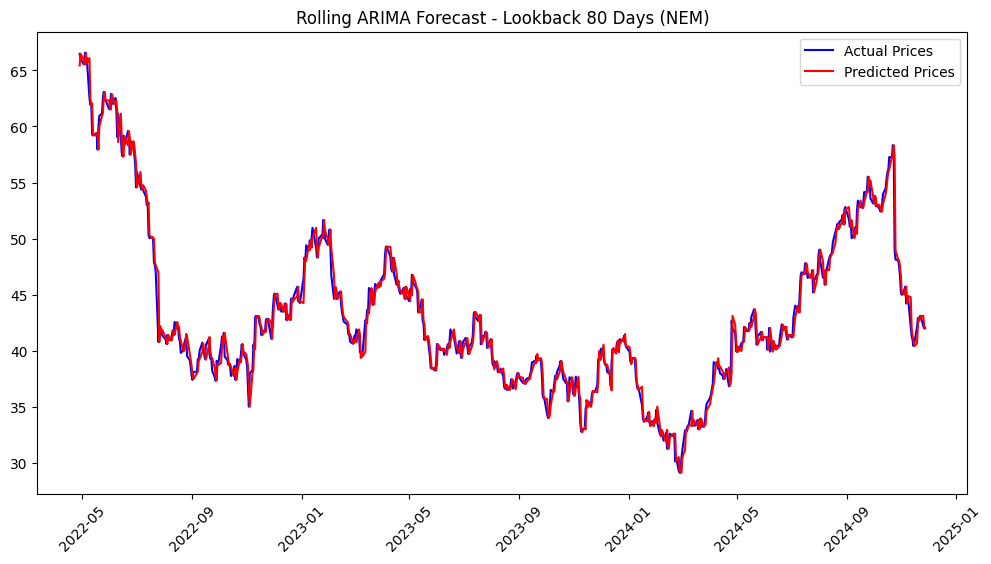


Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 0.9885817329851719


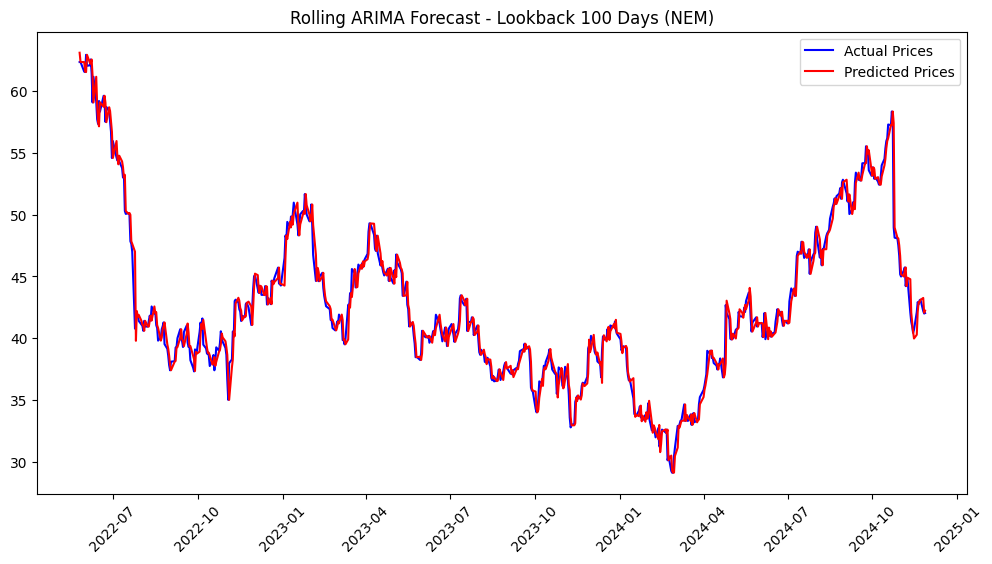

Completed processing for NEM.



In [104]:
import gc
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

def rolling_arima_forecast(data, ticker, lookback_periods):
    """Perform rolling ARIMA forecasting with varying lookback periods."""
    results = {}

    for lookback in lookback_periods:
        print(f"\nProcessing Lookback Period: {lookback} days...")
        predictions = []
        actuals = []
        dates = []

        # Single-pass rolling window
        for i in range(len(data) - lookback - 1):
            if i % 100 == 0:  # Print progress every 100 steps
                print(f"  Rolling window step {i}/{len(data) - lookback - 1}...")

            # Define the rolling window
            window_data = data.iloc[i:i + lookback]
            current_date = data.index[i + lookback]  # Get the date for the current prediction

            try:
                # Auto ARIMA for parameter selection
                model = auto_arima(
                    window_data,
                    seasonal=False,
                    trace=False,
                    error_action="ignore",
                    suppress_warnings=True,
                )

                # Fit ARIMA model
                fitted_model = SARIMAX(window_data, order=model.order).fit(disp=False)

                # Predict the next day's price
                forecast = fitted_model.get_forecast(steps=1)
                next_day_forecast = forecast.predicted_mean.iloc[0]

                # Store results
                predictions.append(next_day_forecast)
                actuals.append(data.iloc[i + lookback])
                dates.append(current_date)

                # Clear memory
                del model, fitted_model, forecast
                gc.collect()

            except Exception as e:
                print(f"    Error at step {i} with lookback {lookback}: {e}")
                predictions.append(None)
                actuals.append(None)
                dates.append(current_date)

        # Remove None values for analysis
        predictions = np.array([p for p in predictions if p is not None])
        actuals = np.array([a for a in actuals if a is not None])
        dates = [d for p, d in zip(predictions, dates) if p is not None]  # Keep valid dates

        # Calculate MSE for the current lookback period
        mse = mean_squared_error(actuals, predictions) if len(actuals) > 0 else float('inf')

        print(f"Lookback Period: {lookback} - MSE: {mse}")

        # Store results
        results[lookback] = {"predictions": predictions, "actuals": actuals, "mse": mse, "dates": dates}

        # Plot predictions vs. actuals
        plt.figure(figsize=(12, 6))
        plt.plot(dates, actuals, label="Actual Prices", color="blue")
        plt.plot(dates, predictions, label="Predicted Prices", color="red")
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format x-axis as dates
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.title(f"Rolling ARIMA Forecast - Lookback {lookback} Days ({ticker})")
        plt.legend()
        plt.show()

    return results

# Main Workflow
lookback_periods = [ 80, 100]  # Define lookback periods
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"
        
        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2022-01-01":]  # Restrict to data from 2020 onward

        # Extract prices for rolling ARIMA
        prices = clean_data['Adj Close']

        # Perform rolling ARIMA forecast on prices
        print(f"Starting rolling ARIMA forecasting for {ticker}...")
        results = rolling_arima_forecast(prices, ticker, lookback_periods)
        print(f"Completed processing for {ticker}.\n")
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Starting rolling ARIMA forecasting for AAPL with volume...

Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 7.890933581476452


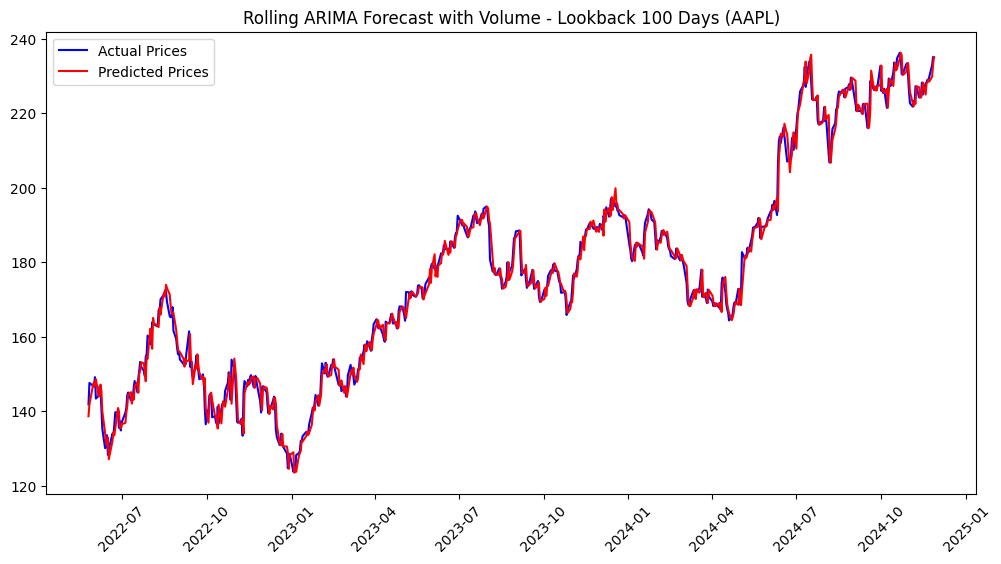

Completed processing for AAPL.


Processing stock: XOM
Starting rolling ARIMA forecasting for XOM with volume...

Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 2.7477261745173114


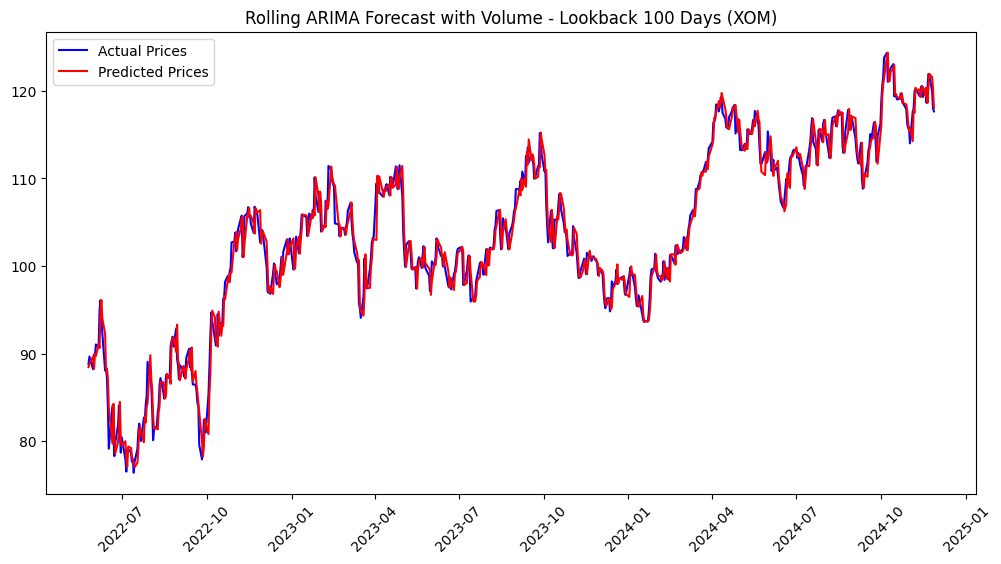

Completed processing for XOM.


Processing stock: TSLA
Starting rolling ARIMA forecasting for TSLA with volume...

Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 195397.110683044


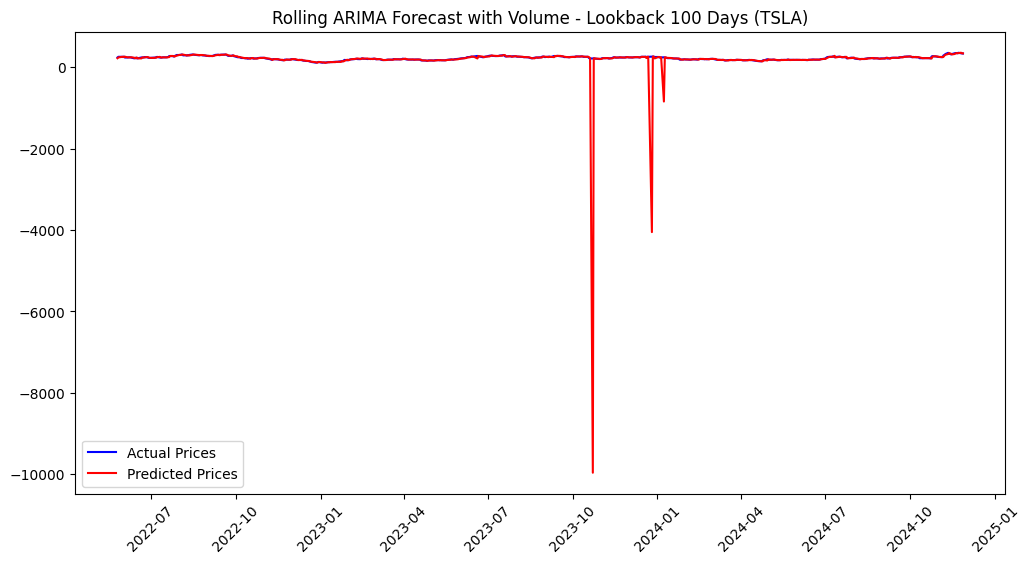

Completed processing for TSLA.


Processing stock: NEM
Starting rolling ARIMA forecasting for NEM with volume...

Processing Lookback Period: 100 days...
  Rolling window step 0/631...
  Rolling window step 100/631...
  Rolling window step 200/631...
  Rolling window step 300/631...
  Rolling window step 400/631...
  Rolling window step 500/631...
  Rolling window step 600/631...
Lookback Period: 100 - MSE: 7837.572290895132


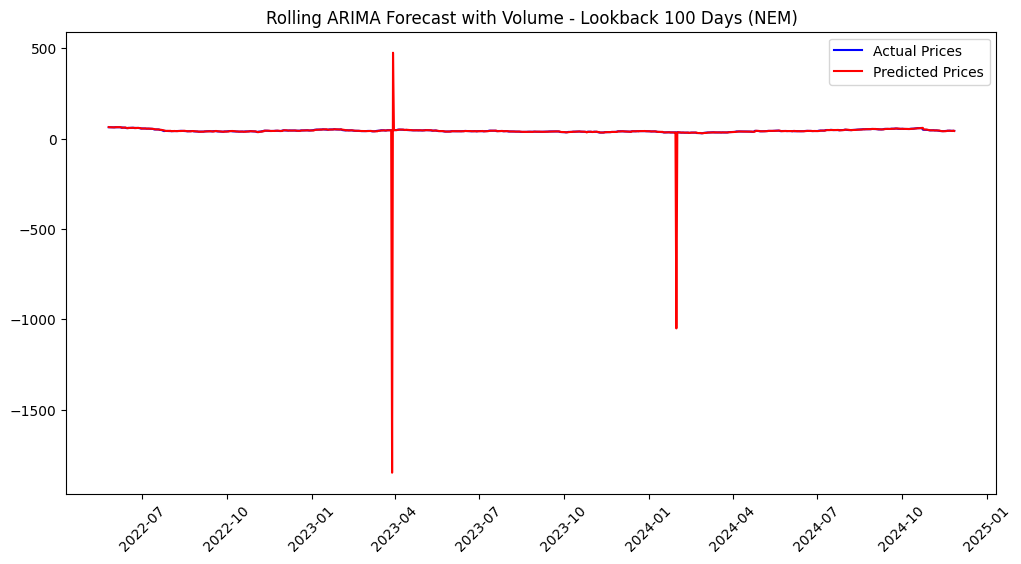

Completed processing for NEM.



In [103]:
import gc
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

def rolling_arima_forecast_with_volume(data, volume_data, ticker, lookback_periods):
    """Perform rolling ARIMA forecasting with volume as an exogenous variable."""
    results = {}

    for lookback in lookback_periods:
        print(f"\nProcessing Lookback Period: {lookback} days...")
        predictions = []
        actuals = []
        dates = []

        # Single-pass rolling window
        for i in range(len(data) - lookback - 1):
            if i % 100 == 0:  # Print progress every 100 steps
                print(f"  Rolling window step {i}/{len(data) - lookback - 1}...")

            # Define the rolling window
            window_data = data.iloc[i:i + lookback].astype(float)  # Ensure numeric dtype
            window_volume = volume_data.iloc[i:i + lookback].astype(float).values.reshape(-1, 1)
            current_date = data.index[i + lookback]  # Get the date for the current prediction

            try:
                # Auto ARIMA for parameter selection
                model = auto_arima(
                    window_data,
                    seasonal=False,
                    exogenous=window_volume,  # Pass volume as exog
                    trace=False,
                    error_action="ignore",
                    suppress_warnings=True,
                )

                # Fit ARIMA model with volume as exogenous variable
                fitted_model = SARIMAX(window_data, exog=window_volume, order=model.order).fit(disp=False)

                # Predict the next day's price
                next_day_volume = np.array([volume_data.iloc[i + lookback]]).reshape(-1, 1)
                forecast = fitted_model.get_forecast(steps=1, exog=next_day_volume)
                next_day_forecast = forecast.predicted_mean.iloc[0]

                # Store results
                predictions.append(next_day_forecast)
                actuals.append(data.iloc[i + lookback])
                dates.append(current_date)

                # Clear memory
                del model, fitted_model, forecast
                gc.collect()

            except Exception as e:
                print(f"    Error at step {i} with lookback {lookback}: {e}")
                predictions.append(None)
                actuals.append(None)
                dates.append(current_date)

        # Remove None values for analysis
        predictions = np.array([p for p in predictions if p is not None])
        actuals = np.array([a for a in actuals if a is not None])
        dates = [d for p, d in zip(predictions, dates) if p is not None]

        # Calculate MSE for the current lookback period
        mse = mean_squared_error(actuals, predictions) if len(actuals) > 0 else float('inf')

        print(f"Lookback Period: {lookback} - MSE: {mse}")

        # Store results
        results[lookback] = {"predictions": predictions, "actuals": actuals, "mse": mse, "dates": dates}

        # Plot predictions vs. actuals
        plt.figure(figsize=(12, 6))
        plt.plot(dates, actuals, label="Actual Prices", color="blue")
        plt.plot(dates, predictions, label="Predicted Prices", color="red")
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))  # Format x-axis as dates
        plt.xticks(rotation=45)  # Rotate x-axis labels
        plt.title(f"Rolling ARIMA Forecast with Volume - Lookback {lookback} Days ({ticker})")
        plt.legend()
        plt.show()

    return results

# Main Workflow
lookback_periods = [100]  # Define lookback periods
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"
        
        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2022 onward
        clean_data = clean_data.loc["2022-01-01":]  # Restrict to data from 2022 onward

        # Scale the volume data
        scaler = MinMaxScaler()
        clean_data['Volume_scaled'] = scaler.fit_transform(clean_data[['Volume']])

        # Extract prices and scaled volume for rolling ARIMA
        prices = clean_data['Adj Close']
        volume = clean_data['Volume_scaled']

        # Perform rolling ARIMA forecast with volume
        print(f"Starting rolling ARIMA forecasting for {ticker} with volume...")
        results = rolling_arima_forecast_with_volume(prices, volume, ticker, lookback_periods)
        print(f"Completed processing for {ticker}.\n")
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")


Processing stock: AAPL
Training LSTM model for AAPL...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1444 - val_loss: 0.0178
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0112 - val_loss: 0.0031
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0034 - val_loss: 0.0

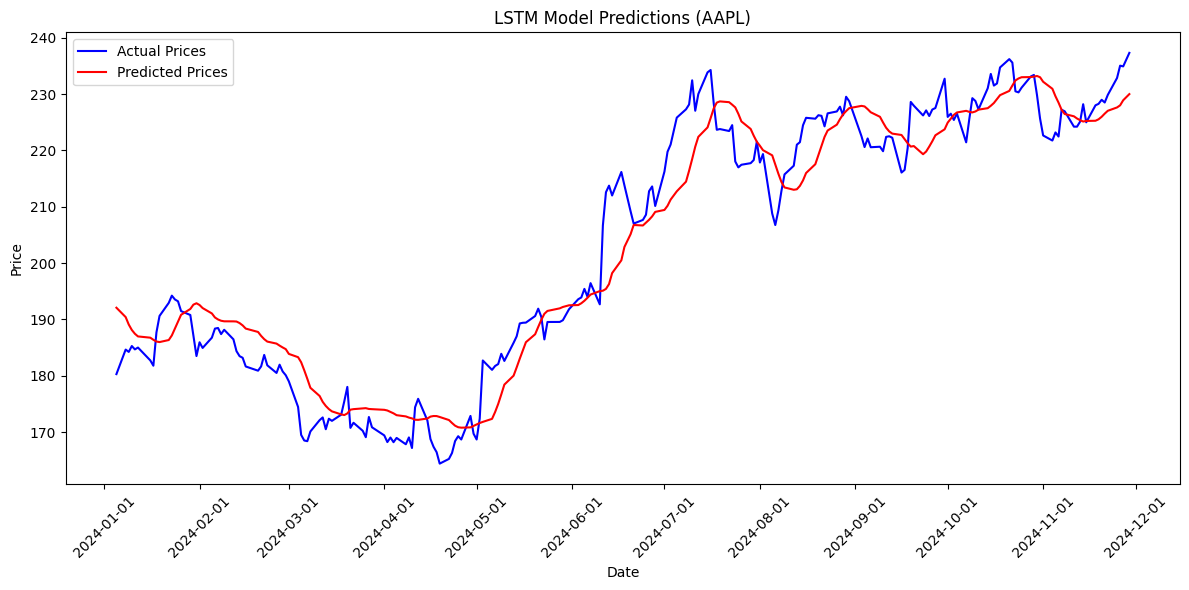


Processing stock: XOM
Training LSTM model for XOM...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1673 - val_loss: 0.0223
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0141 - val_loss: 0.0013
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072 - val_loss: 0.0031
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034 - val_loss: 8.7333e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 9

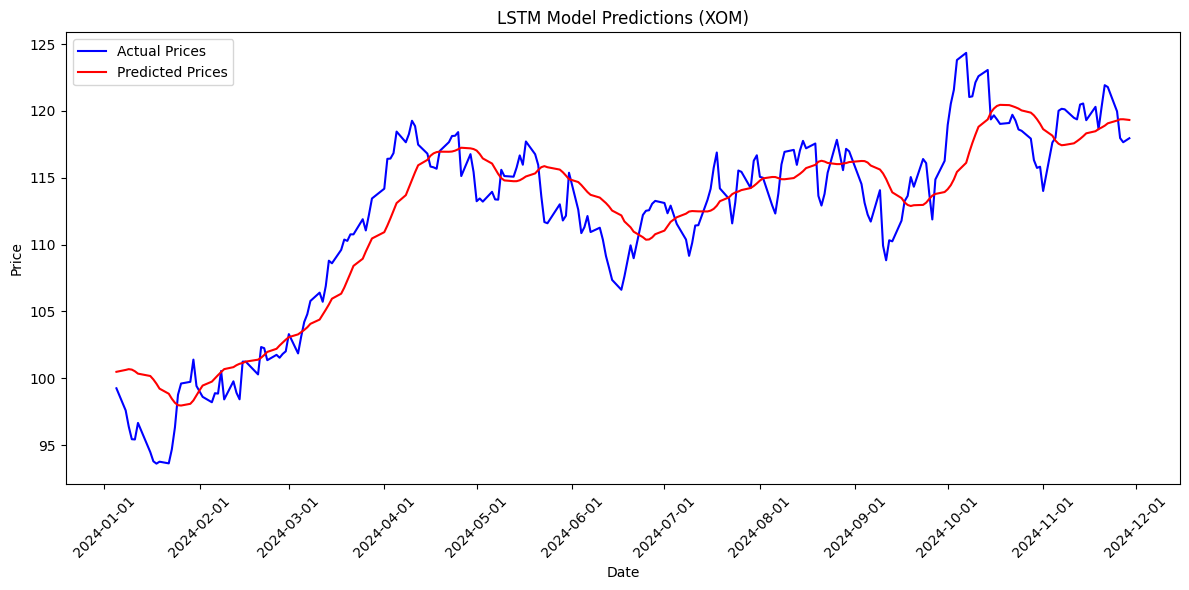


Processing stock: TSLA
Training LSTM model for TSLA...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.1017 - val_loss: 0.0137
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0151 - val_loss: 0.0046
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0077 - val_loss: 0.0041
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0044 - val_loss: 0.0

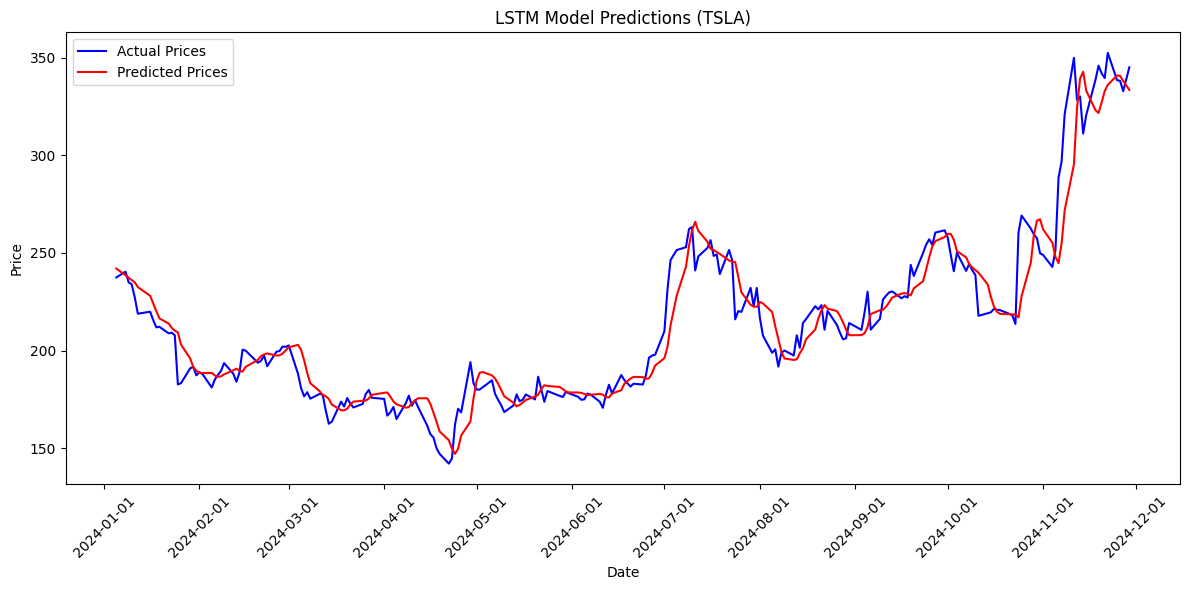


Processing stock: NEM
Training LSTM model for NEM...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0923 - val_loss: 0.0052
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0126 - val_loss: 0.0075
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038 - val_loss: 0.002

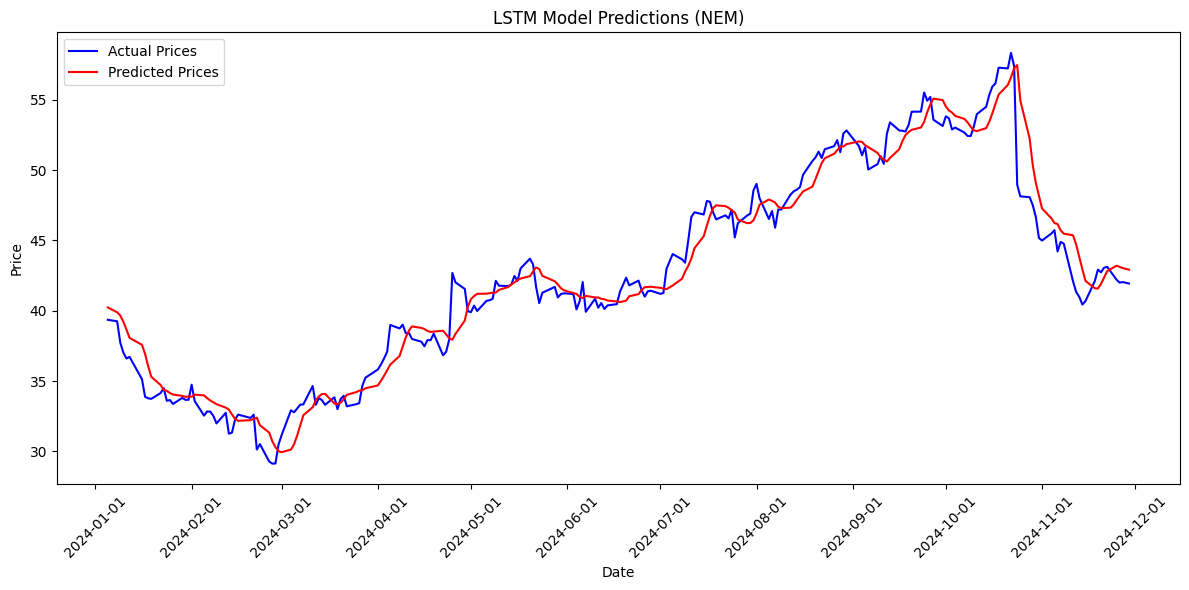

In [110]:
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.dates import DateFormatter

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Preprocessing for LSTM
def prepare_lstm_data(data, volume, lookback):
    """Prepare data for LSTM with lookback window."""
    X, y, dates = [], [], []
    for i in range(len(data) - lookback):
        X.append(np.column_stack((data[i:i + lookback], volume[i:i + lookback])))
        y.append(data[i + lookback])
        dates.append(data.index[i + lookback])
    return np.array(X), np.array(y), dates

# LSTM Model Training
def train_lstm(X_train, y_train, X_val, y_val, lookback):
    """Train LSTM model."""
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 2)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)  # Single output for price prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Main Workflow
lookback = 100  # Define lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]  # Restrict to data from 2020 onward

        # Scale prices and volume
        scaler_prices = MinMaxScaler()
        scaler_volume = MinMaxScaler()
        clean_data['Adj Close'] = scaler_prices.fit_transform(clean_data[['Adj Close']])
        clean_data['Volume'] = scaler_volume.fit_transform(clean_data[['Volume']])

        # Prepare data for LSTM
        X, y, dates = prepare_lstm_data(clean_data['Adj Close'], clean_data['Volume'], lookback)

        # Split into training and validation sets
        train_size = int(len(X) * 0.8)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]
        train_dates, val_dates = dates[:train_size], dates[train_size:]

        # Train LSTM
        print(f"Training LSTM model for {ticker}...")
        model, history = train_lstm(X_train, y_train, X_val, y_val, lookback)

        # Predict and evaluate
        predictions = model.predict(X_val)
        predictions = scaler_prices.inverse_transform(predictions)
        y_val_actual = scaler_prices.inverse_transform(y_val.reshape(-1, 1))

        mse = mean_squared_error(y_val_actual, predictions)
        print(f"{ticker} - Mean Squared Error: {mse}")

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(val_dates, y_val_actual, label="Actual Prices", color="blue")
        plt.plot(val_dates, predictions, label="Predicted Prices", color="red")
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=45)
        plt.title(f"LSTM Model Predictions ({ticker})")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Training LSTM model for AAPL...
Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0641 - val_loss: 0.0233
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0061 - val_loss: 0.0171
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0053 - val_loss: 0.0061
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0041 - val_loss: 0.0065
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0028 - val_loss: 0.0065
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0031 - val_loss: 0.0

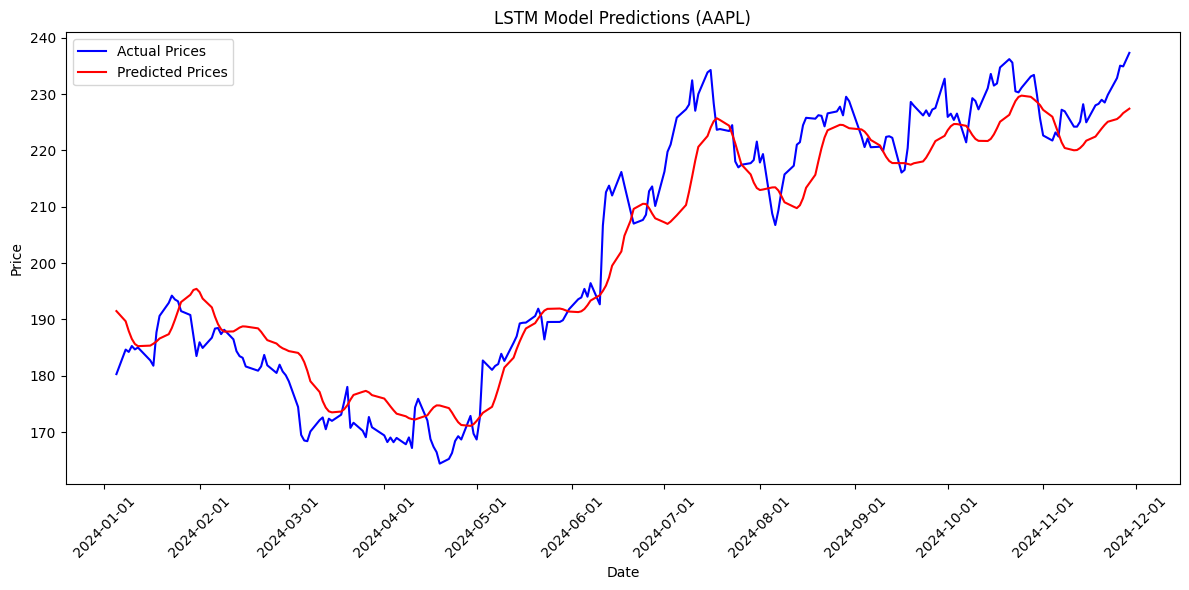


Processing stock: XOM
Training LSTM model for XOM...
Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1068 - val_loss: 0.0203
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0079 - val_loss: 0.0109
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0055 - val_loss: 0.0123
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0043 - val_loss: 0.0082
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0033 - val_loss: 0.0111
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0030 - val_loss: 0.0106
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0032 - val_loss: 0.0082
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0026 - val_loss: 0.009

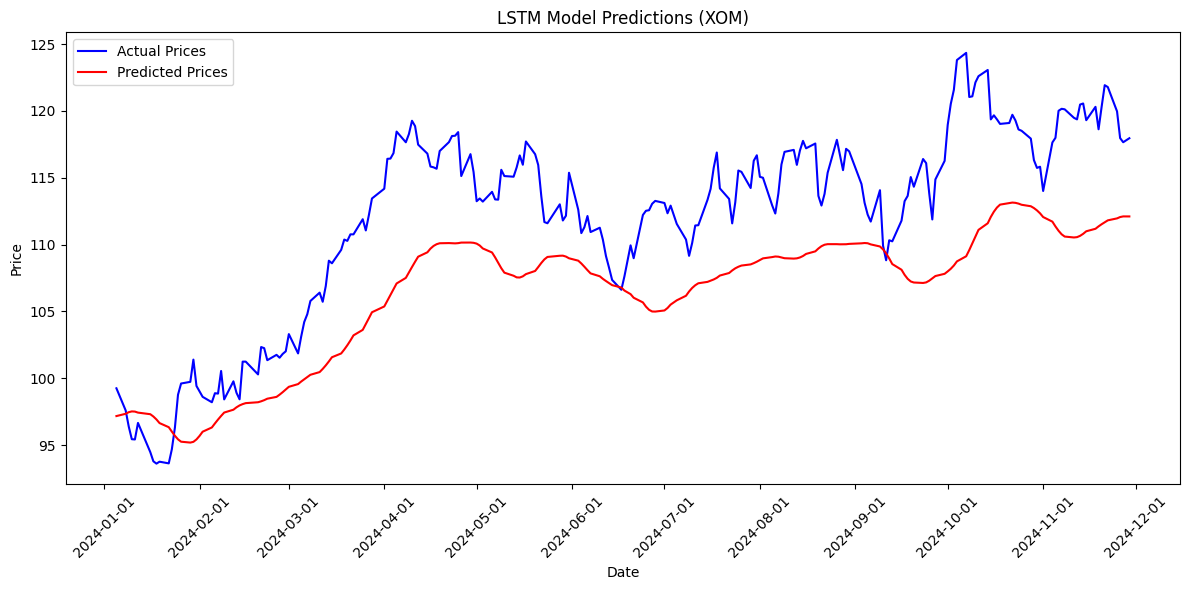


Processing stock: TSLA
Training LSTM model for TSLA...
Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0730 - val_loss: 0.0056
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0089 - val_loss: 0.0047
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0079 - val_loss: 0.0040
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0064 - val_loss: 0.0033
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0049 - val_loss: 0.0

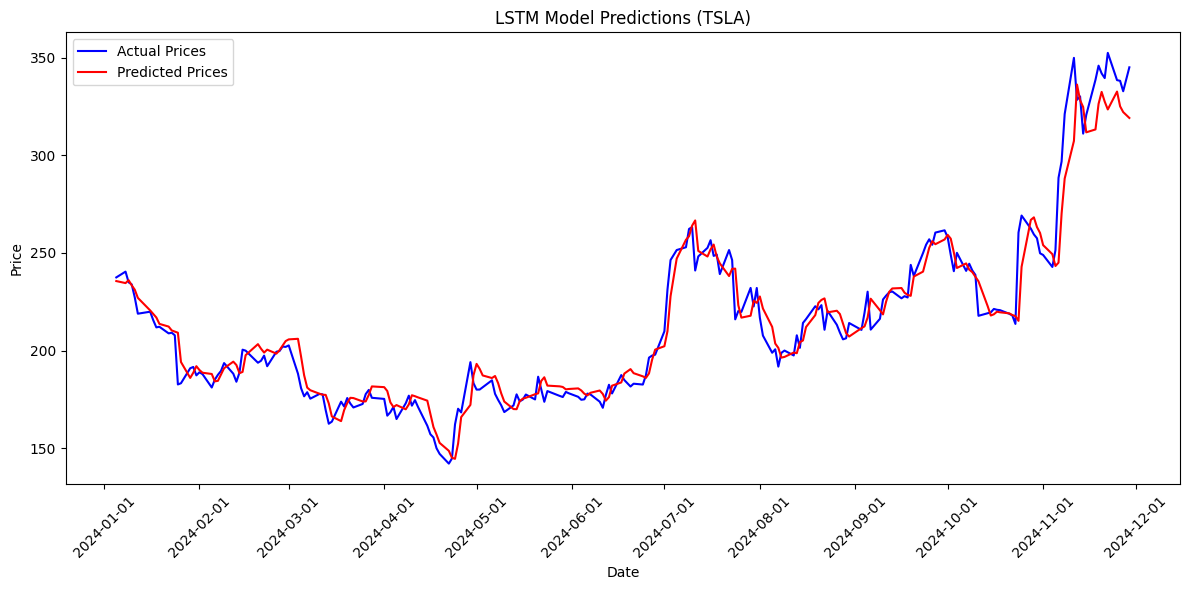


Processing stock: NEM
Training LSTM model for NEM...
Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.1143 - val_loss: 0.0059
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0126 - val_loss: 0.0047
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0083 - val_loss: 0.0044
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0057 - val_loss: 0.0037
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0041 - val_loss: 0.002

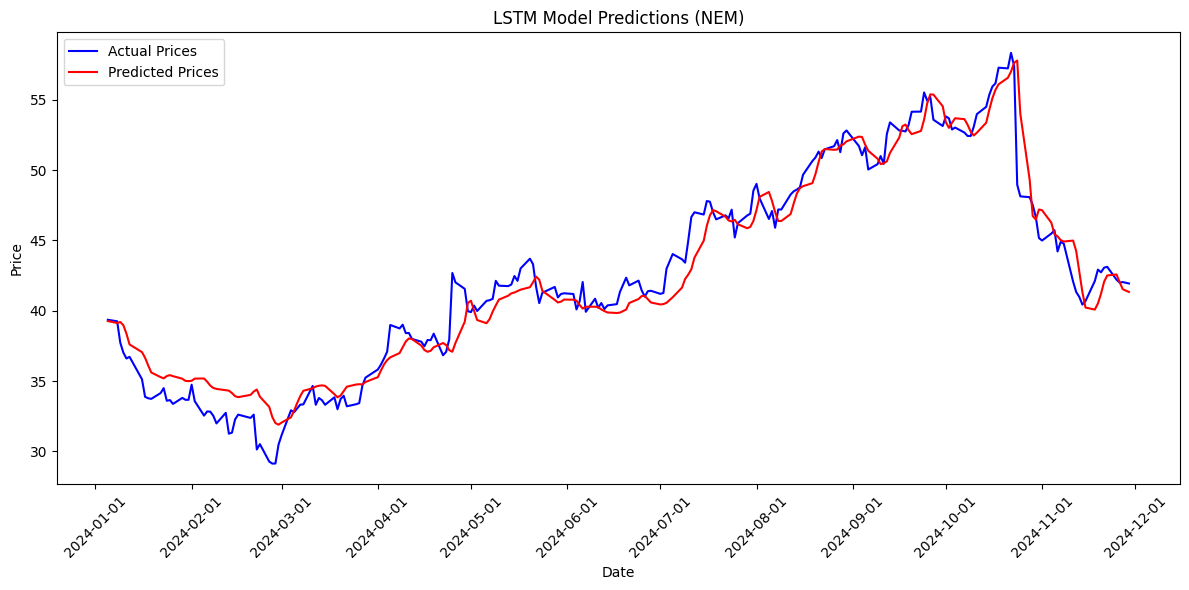

In [112]:
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.dates import DateFormatter

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Preprocessing for LSTM
def prepare_lstm_data(data, volume, lookback):
    """Prepare data for LSTM with lookback window."""
    X, y, dates = [], [], []
    for i in range(len(data) - lookback):
        X.append(np.column_stack((data[i:i + lookback], volume[i:i + lookback])))
        y.append(data[i + lookback])
        dates.append(data.index[i + lookback])
    return np.array(X), np.array(y), dates

# LSTM Model Training with Enhanced Architecture
def train_lstm(X_train, y_train, X_val, y_val, lookback):
    """Train an enhanced LSTM model."""
    model = Sequential([
        # First LSTM Layer
        LSTM(128, return_sequences=True, input_shape=(lookback, 2)),
        Dropout(0.3),
        
        # Second LSTM Layer
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        
        # Third LSTM Layer
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        
        # Dense Layers
        Dense(16, activation='relu'),
        Dense(1)  # Single output for price prediction
    ])
    
    # Compile the model with an advanced optimizer
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=200,  # Increased epochs for deeper learning
        batch_size=32,  # Smaller batch size for finer updates
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

# Main Workflow
lookback = 100  # Define lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]  # Restrict to data from 2020 onward

        # Scale prices and volume
        scaler_prices = MinMaxScaler()
        scaler_volume = MinMaxScaler()
        clean_data['Adj Close'] = scaler_prices.fit_transform(clean_data[['Adj Close']])
        clean_data['Volume'] = scaler_volume.fit_transform(clean_data[['Volume']])

        # Prepare data for LSTM
        X, y, dates = prepare_lstm_data(clean_data['Adj Close'], clean_data['Volume'], lookback)

        # Split into training and validation sets
        train_size = int(len(X) * 0.8)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]
        train_dates, val_dates = dates[:train_size], dates[train_size:]

        # Train LSTM
        print(f"Training LSTM model for {ticker}...")
        model, history = train_lstm(X_train, y_train, X_val, y_val, lookback)

        # Predict and evaluate
        predictions = model.predict(X_val)
        predictions = scaler_prices.inverse_transform(predictions)
        y_val_actual = scaler_prices.inverse_transform(y_val.reshape(-1, 1))

        mse = mean_squared_error(y_val_actual, predictions)
        print(f"{ticker} - Mean Squared Error: {mse}")

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(val_dates, y_val_actual, label="Actual Prices", color="blue")
        plt.plot(val_dates, predictions, label="Predicted Prices", color="red")
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=45)
        plt.title(f"LSTM Model Predictions ({ticker})")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Training LSTM model for AAPL...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1063 - val_loss: 0.0436
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0143 - val_loss: 0.0027
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039 - val_loss: 0.0

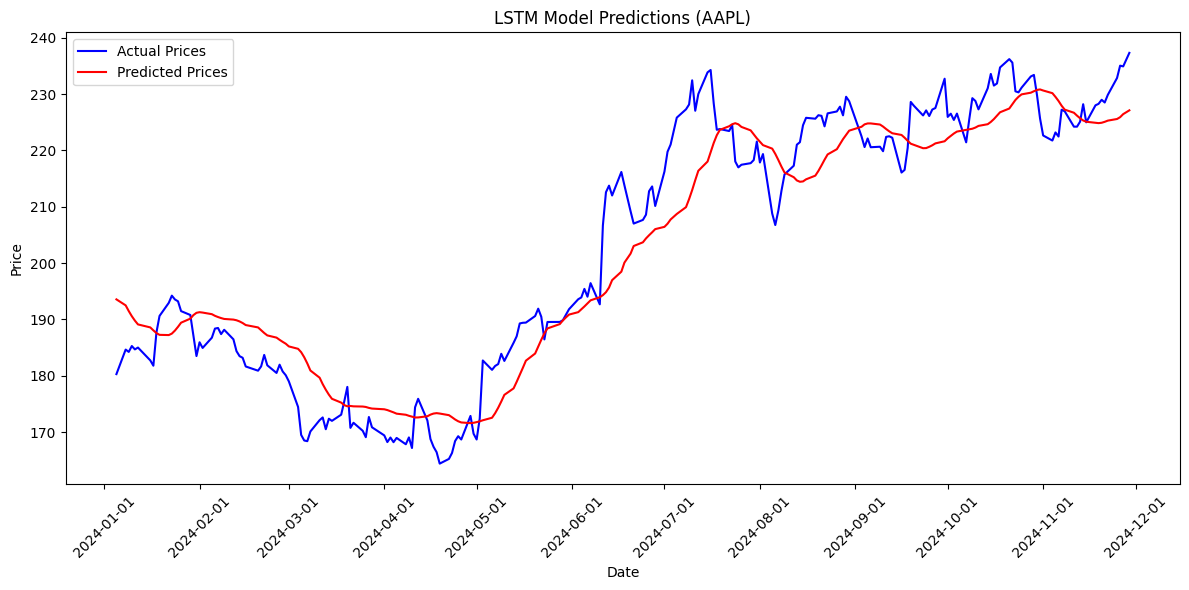


Processing stock: XOM
Training LSTM model for XOM...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1806 - val_loss: 0.0169
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0162 - val_loss: 0.0014
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0090 - val_loss: 0.0045
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042 - val_loss: 8.9525e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0049 - val_loss: 9

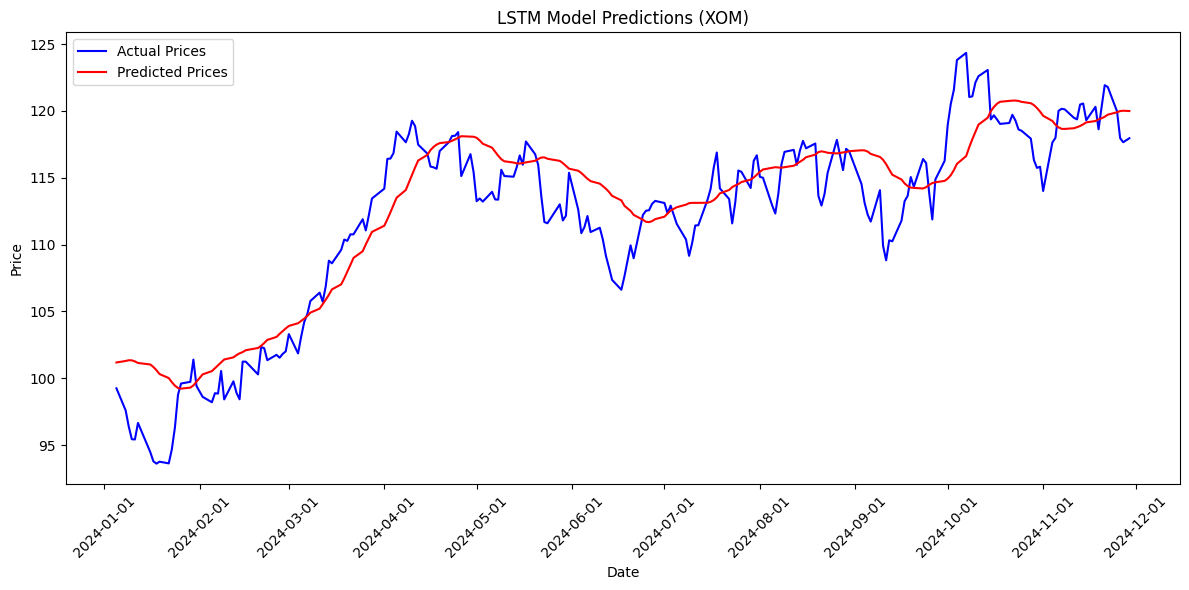


Processing stock: TSLA
Training LSTM model for TSLA...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1609 - val_loss: 0.0047
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0161 - val_loss: 0.0046
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0117 - val_loss: 0.0046
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0094 - val_loss: 0.0038
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0074 - val_loss: 0.0029
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0060 - val_loss: 0.0

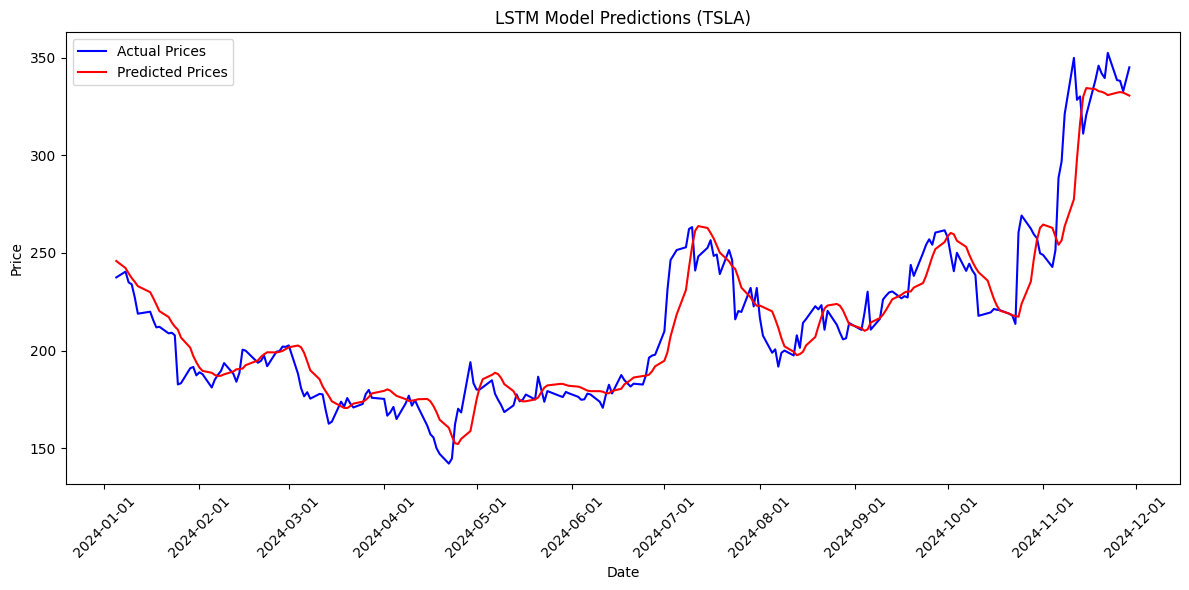


Processing stock: NEM
Training LSTM model for NEM...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1089 - val_loss: 0.0068
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0139 - val_loss: 0.0079
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0093 - val_loss: 0.0039
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0070 - val_loss: 0.0030
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0050 - val_loss: 0.002

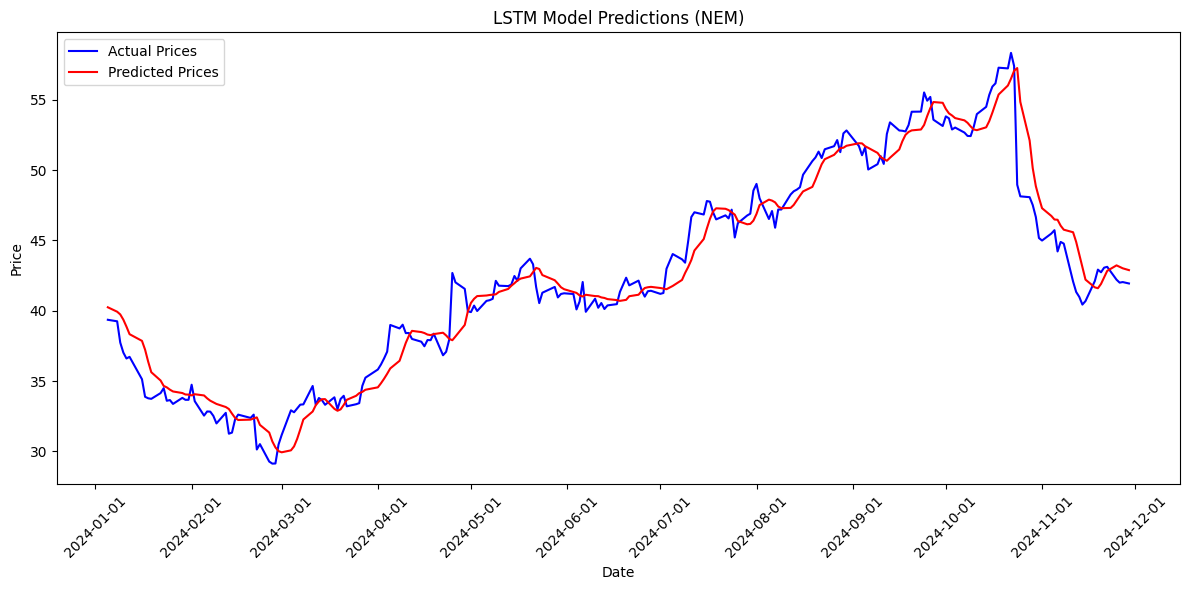

In [113]:
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.dates import DateFormatter

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Preprocessing for LSTM
def prepare_lstm_data(data, volume, lookback):
    """Prepare data for LSTM with lookback window."""
    X, y, dates = [], [], []
    for i in range(len(data) - lookback):
        X.append(np.column_stack((data[i:i + lookback], volume[i:i + lookback])))
        y.append(data[i + lookback])
        dates.append(data.index[i + lookback])
    return np.array(X), np.array(y), dates

# Simplified LSTM Model Training
def train_lstm(X_train, y_train, X_val, y_val, lookback):
    """Train a simpler LSTM model."""
    model = Sequential([
        # First LSTM Layer
        LSTM(64, return_sequences=True, input_shape=(lookback, 2)),
        Dropout(0.2),
        
        # Second LSTM Layer
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        
        # Dense Layer
        Dense(1)  # Single output for price prediction
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,  # Train for fewer epochs
        batch_size=64,  # Use a moderate batch size
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history


# Main Workflow
lookback = 100  # Define lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]  # Restrict to data from 2020 onward

        # Scale prices and volume
        scaler_prices = MinMaxScaler()
        scaler_volume = MinMaxScaler()
        clean_data['Adj Close'] = scaler_prices.fit_transform(clean_data[['Adj Close']])
        clean_data['Volume'] = scaler_volume.fit_transform(clean_data[['Volume']])

        # Prepare data for LSTM
        X, y, dates = prepare_lstm_data(clean_data['Adj Close'], clean_data['Volume'], lookback)

        # Split into training and validation sets
        train_size = int(len(X) * 0.8)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]
        train_dates, val_dates = dates[:train_size], dates[train_size:]

        # Train LSTM
        print(f"Training LSTM model for {ticker}...")
        model, history = train_lstm(X_train, y_train, X_val, y_val, lookback)

        # Predict and evaluate
        predictions = model.predict(X_val)
        predictions = scaler_prices.inverse_transform(predictions)
        y_val_actual = scaler_prices.inverse_transform(y_val.reshape(-1, 1))

        mse = mean_squared_error(y_val_actual, predictions)
        print(f"{ticker} - Mean Squared Error: {mse}")

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(val_dates, y_val_actual, label="Actual Prices", color="blue")
        plt.plot(val_dates, predictions, label="Predicted Prices", color="red")
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=45)
        plt.title(f"LSTM Model Predictions ({ticker})")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Training LSTM model for AAPL...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1181 - val_loss: 0.0037
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - val_loss: 0.0126
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0072
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 

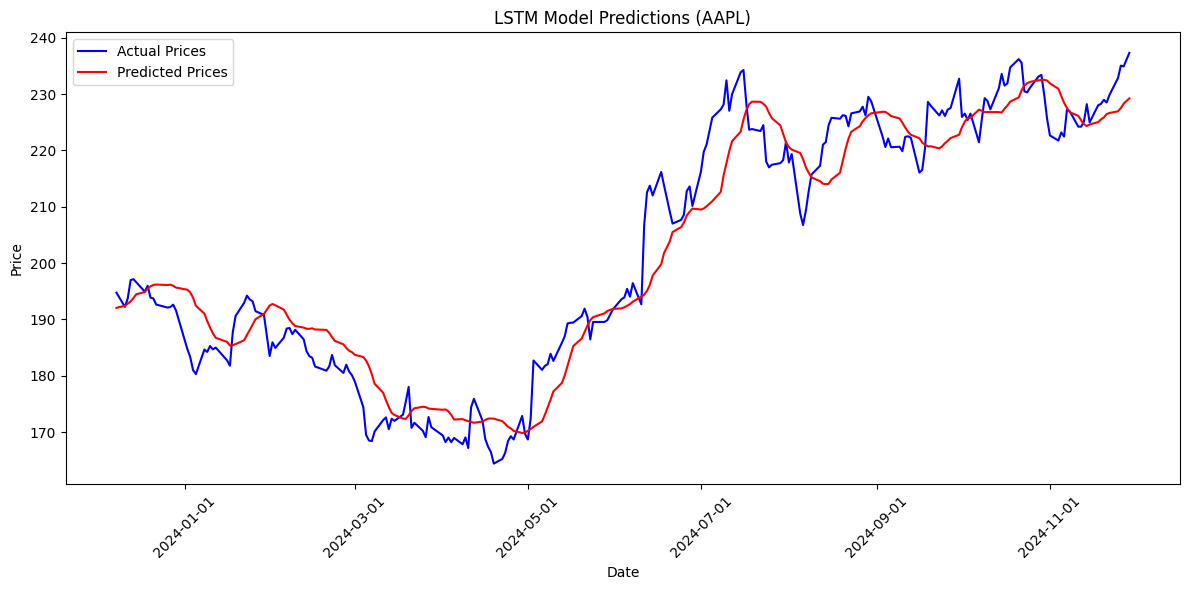


Processing stock: XOM
Training LSTM model for XOM...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1665 - val_loss: 0.0059
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0242 - val_loss: 0.0120
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 7.7439e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 7.2619e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 7.2048e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 9.9757e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss:

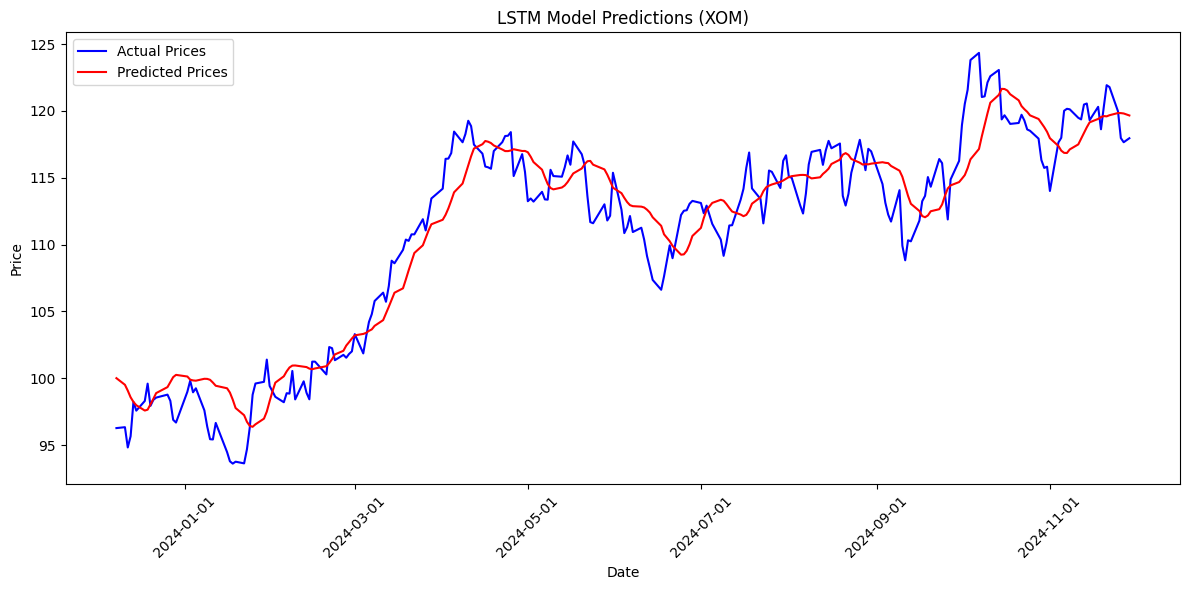


Processing stock: TSLA
Training LSTM model for TSLA...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1993 - val_loss: 0.0249
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262 - val_loss: 0.0091
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0035
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0026
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0026
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 

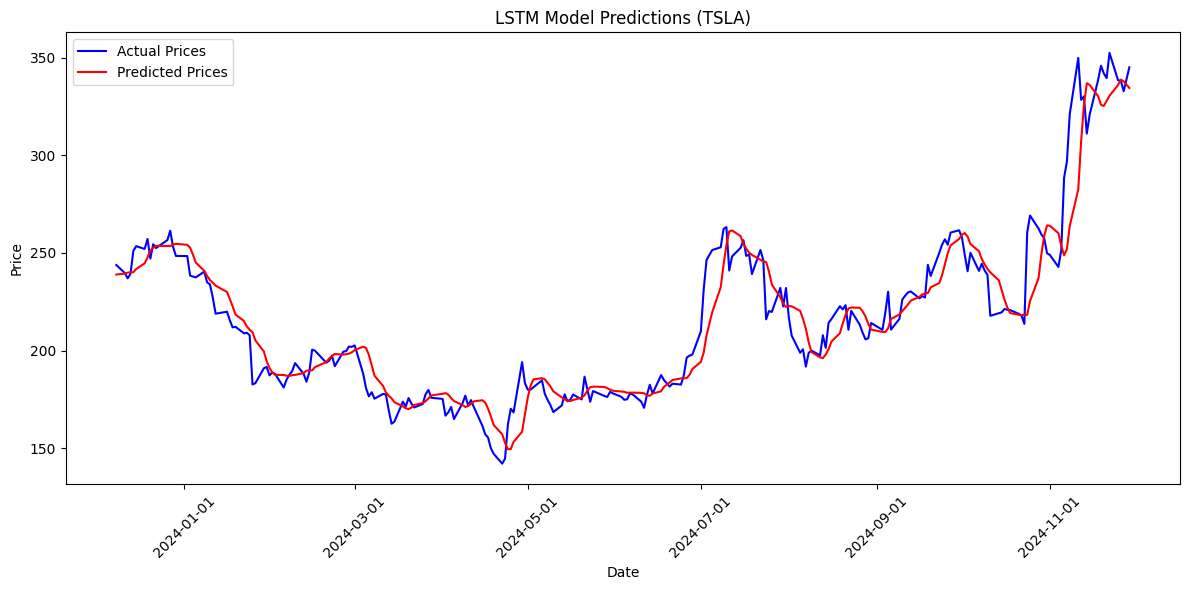


Processing stock: NEM
Training LSTM model for NEM...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1356 - val_loss: 0.0313
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0051
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 12

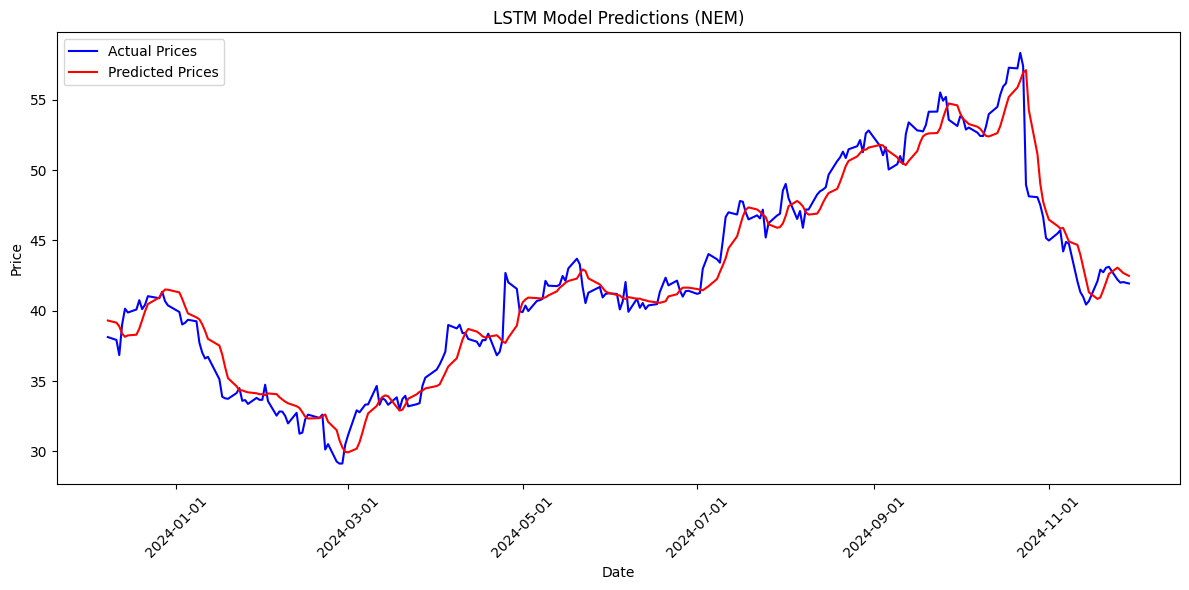

In [114]:
import gc
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib.dates import DateFormatter

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Preprocessing for LSTM
def prepare_lstm_data(data, volume, lookback):
    """Prepare data for LSTM with lookback window."""
    X, y, dates = [], [], []
    for i in range(len(data) - lookback):
        X.append(np.column_stack((data[i:i + lookback], volume[i:i + lookback])))
        y.append(data[i + lookback])
        dates.append(data.index[i + lookback])
    return np.array(X), np.array(y), dates

# Simplified LSTM Model Training
def train_lstm(X_train, y_train, X_val, y_val, lookback):
    """Train a simpler LSTM model."""
    model = Sequential([
        # First LSTM Layer
        LSTM(64, return_sequences=True, input_shape=(lookback, 2)),
        Dropout(0.2),
        
        # Second LSTM Layer
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        
        # Dense Layer
        Dense(1)  # Single output for price prediction
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,  # Train for fewer epochs
        batch_size=64,  # Use a moderate batch size
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history


# Main Workflow
lookback = 10  # Define lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]  # Restrict to data from 2020 onward

        # Scale prices and volume
        scaler_prices = MinMaxScaler()
        scaler_volume = MinMaxScaler()
        clean_data['Adj Close'] = scaler_prices.fit_transform(clean_data[['Adj Close']])
        clean_data['Volume'] = scaler_volume.fit_transform(clean_data[['Volume']])

        # Prepare data for LSTM
        X, y, dates = prepare_lstm_data(clean_data['Adj Close'], clean_data['Volume'], lookback)

        # Split into training and validation sets
        train_size = int(len(X) * 0.8)
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]
        train_dates, val_dates = dates[:train_size], dates[train_size:]

        # Train LSTM
        print(f"Training LSTM model for {ticker}...")
        model, history = train_lstm(X_train, y_train, X_val, y_val, lookback)

        # Predict and evaluate
        predictions = model.predict(X_val)
        predictions = scaler_prices.inverse_transform(predictions)
        y_val_actual = scaler_prices.inverse_transform(y_val.reshape(-1, 1))

        mse = mean_squared_error(y_val_actual, predictions)
        print(f"{ticker} - Mean Squared Error: {mse}")

        # Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(val_dates, y_val_actual, label="Actual Prices", color="blue")
        plt.plot(val_dates, predictions, label="Predicted Prices", color="red")
        plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=45)
        plt.title(f"LSTM Model Predictions ({ticker})")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Epoch 1/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0104
Epoch 2/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0019
Epoch 3/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0014
Epoch 4/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0012
Epoch 5/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0011
Epoch 6/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0010
Epoch 7/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011
Epoch 8/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.8437e-04
Epoch 9/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 7.3474e-04
Epoch 10/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0011
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
AAPL - Root Mean Squared Error: 3.614185841623597


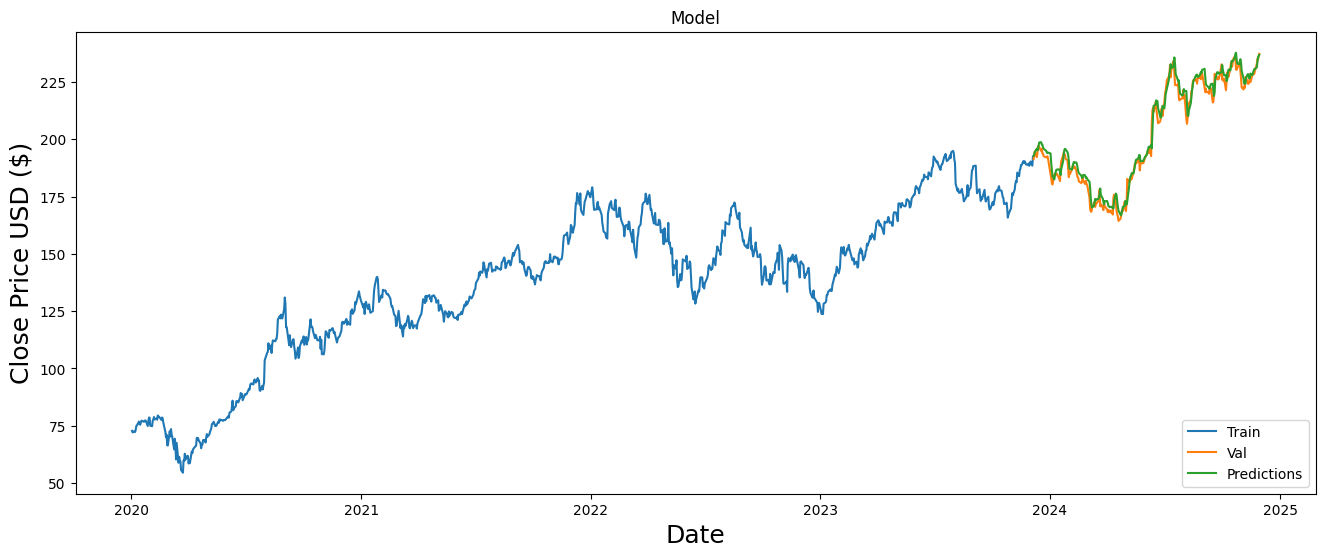


Processing stock: XOM
Epoch 1/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0081
Epoch 2/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0032
Epoch 3/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0019
Epoch 4/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0022
Epoch 5/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0023
Epoch 6/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0017
Epoch 7/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0017
Epoch 8/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0020
Epoch 9/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0018
Epoch 10/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0019
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
XOM - Root Mean Squared Error: 1.6781547823617775


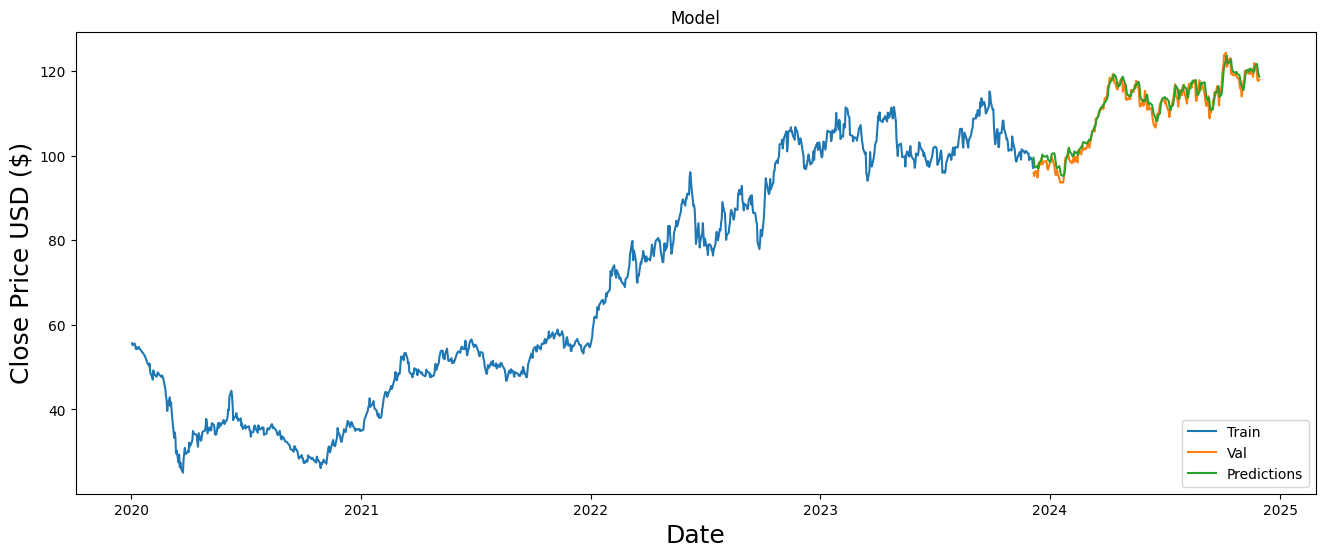


Processing stock: TSLA
Epoch 1/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0132
Epoch 2/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0032
Epoch 3/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0025
Epoch 4/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0025
Epoch 5/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0021
Epoch 6/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0020
Epoch 7/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0022
Epoch 8/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0022
Epoch 9/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0016
Epoch 10/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0016
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
TSLA - Root Mean Squared Error: 10.259945749066624


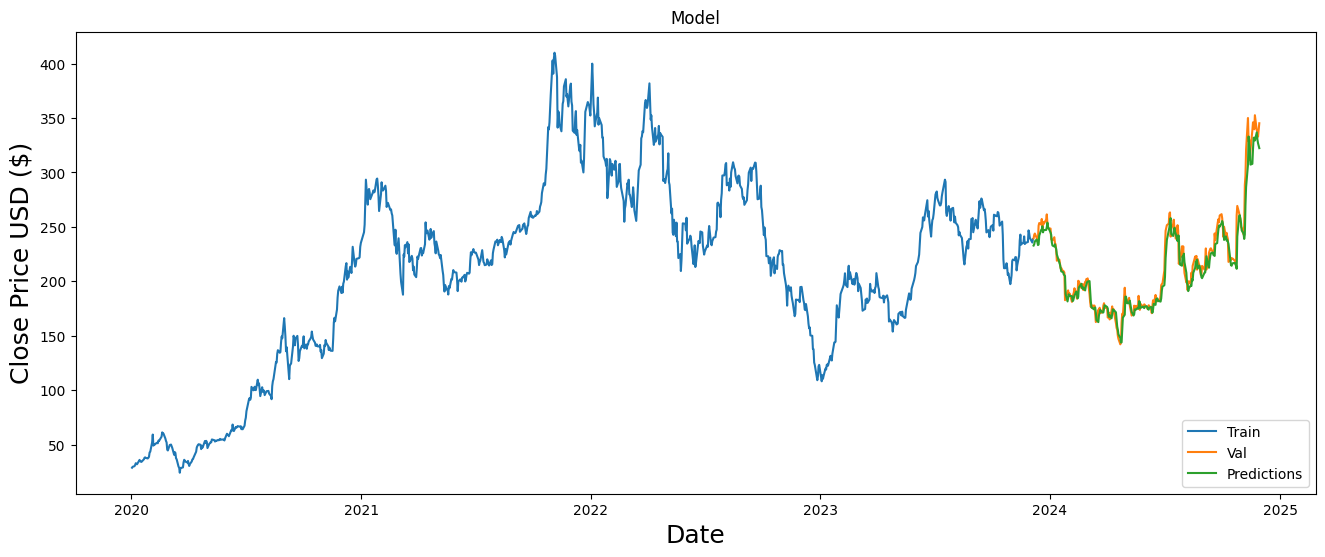


Processing stock: NEM
Epoch 1/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0119
Epoch 2/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0032
Epoch 3/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0022
Epoch 4/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0023
Epoch 5/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0024
Epoch 6/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0019
Epoch 7/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0018
Epoch 8/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0014
Epoch 9/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0018
Epoch 10/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0014
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
NEM - Root Mean Squared Error: 1.1391948017579745


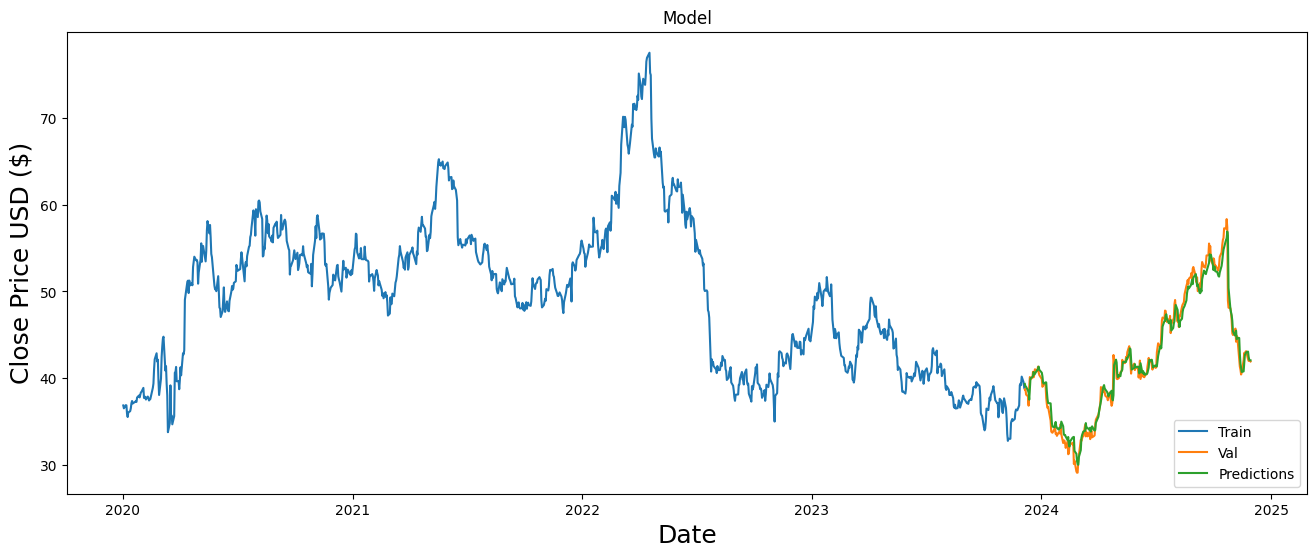

In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import datetime

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Prepare LSTM Data
def prepare_lstm_data(data, lookback):
    x_data, y_data = [], []
    for i in range(lookback, len(data)):
        x_data.append(data[i-lookback:i, 0])  # Lookback period for each input
        y_data.append(data[i, 0])            # Next value to predict
    return np.array(x_data), np.array(y_data)

# Main Workflow
lookback = 60  # Lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"
        
        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2022 onward
        clean_data = clean_data.loc["2020-01-01":]

        # Extract prices and scale data
        data = clean_data[['Adj Close']].values
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)

        # Define training and testing data
        training_data_len = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:training_data_len]
        test_data = scaled_data[training_data_len - lookback:]

        # Prepare training data
        x_train, y_train = prepare_lstm_data(train_data, lookback)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # Build and Train the LSTM Model
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, batch_size=1, epochs=10)

        # Prepare testing data
        x_test, y_test = prepare_lstm_data(test_data, lookback)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        # Make predictions
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)  # Inverse scaling
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scaling

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        print(f"{ticker} - Root Mean Squared Error: {rmse}")

        # Prepare data for plotting
        train = clean_data[:training_data_len]
        valid = clean_data[training_data_len:]
        valid['Predictions'] = predictions

        # Plot the data
        plt.figure(figsize=(16, 6))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Adj Close'], label='Train')
        plt.plot(valid[['Adj Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0747
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0095
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0044
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0038
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0036
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0030
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0028
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
AAPL - Root Mean Squared Error: 10.600323031372419


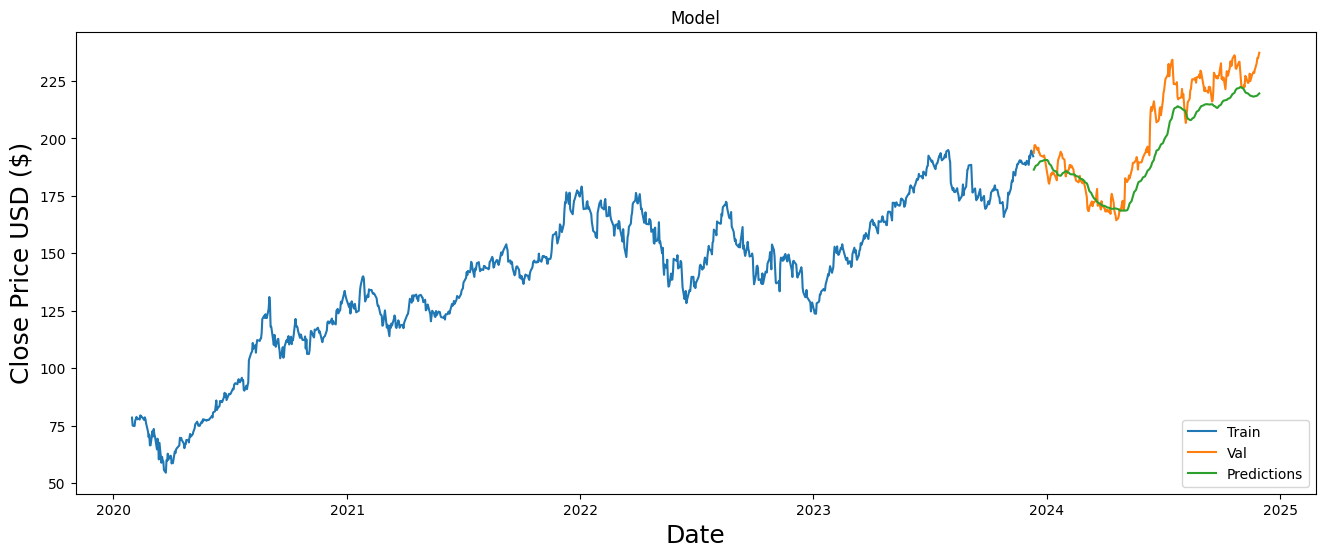


Processing stock: XOM
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0814
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0062
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0043
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0032
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0033
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0036
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0033
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0030
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0029
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
XOM - Root Mean Squared Error: 3.9962128674728916


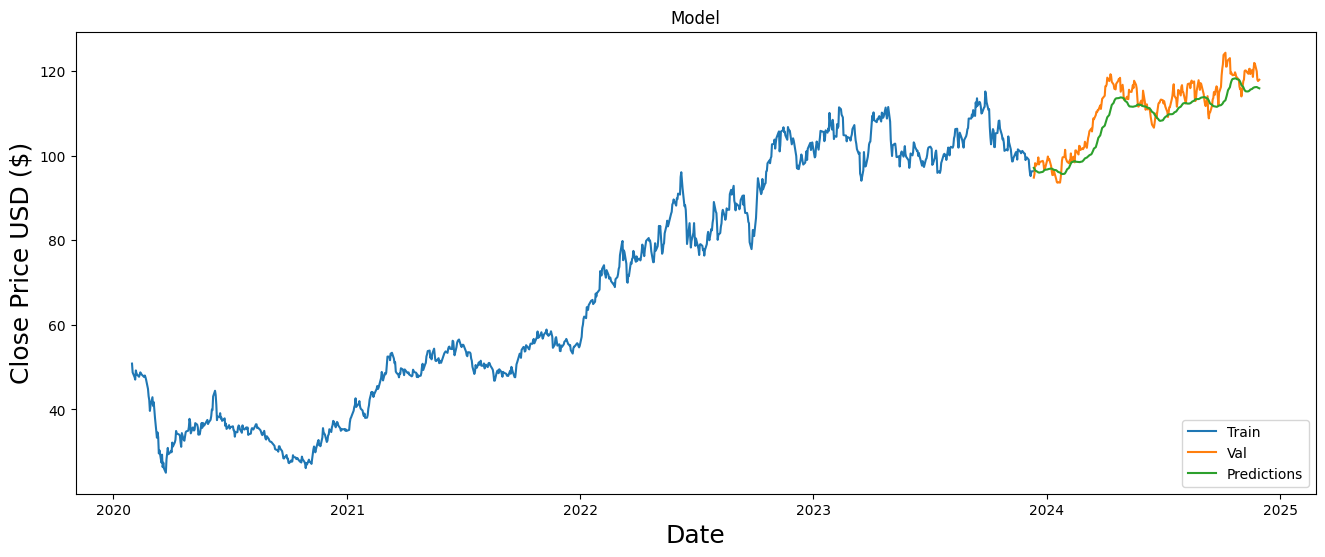


Processing stock: TSLA
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0890
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0111
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0057
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0055
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0045
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0043
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
TSLA - Root Mean Squared Error: 17.706165399666425


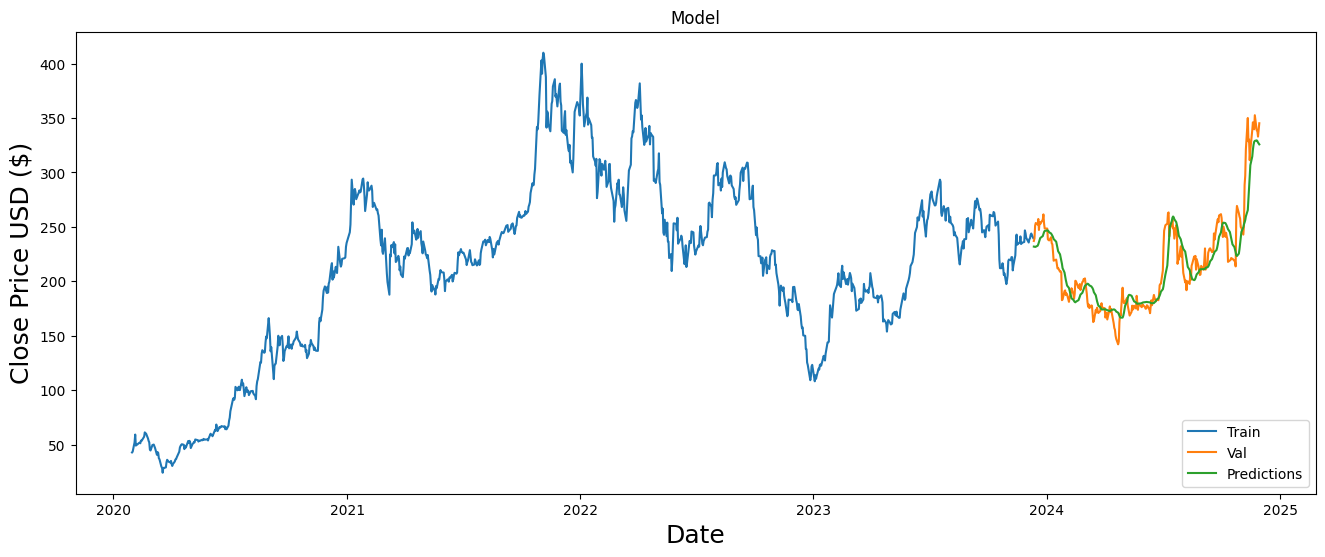


Processing stock: NEM
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0825
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0089
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0079
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0057
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0050
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0045
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0044
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0041
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0040
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0037
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
NEM - Root Mean Squared Error: 2.1293743656375352


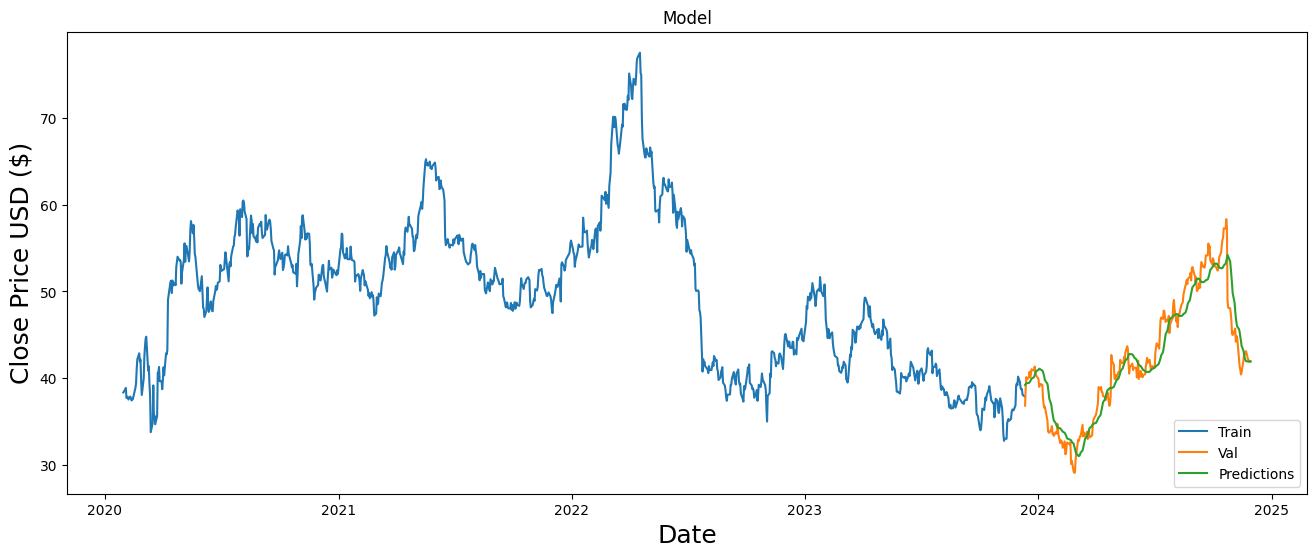

In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import datetime

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Feature Engineering
def add_features(data):
    """Add additional features to the dataset."""
    data['MA_10'] = data['Adj Close'].rolling(window=10).mean()  # 10-day moving average
    data['MA_20'] = data['Adj Close'].rolling(window=20).mean()  # 20-day moving average
    data['Volatility'] = data['Adj Close'].rolling(window=10).std()  # 10-day rolling volatility
    data = data.dropna()  # Drop rows with NaN after adding features
    return data

# Prepare LSTM Data with Features
def prepare_lstm_data_with_features(data, lookback):
    x_data, y_data = [], []
    for i in range(lookback, len(data)):
        x_data.append(data[i-lookback:i])  # Lookback period for each input
        y_data.append(data[i, 0])         # Next value to predict (Adj Close)
    return np.array(x_data), np.array(y_data)

# Main Workflow
lookback = 60  # Lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]

        # Add additional features
        clean_data = add_features(clean_data)

        # Select features and scale data
        features = ['Adj Close', 'Volume', 'MA_10', 'MA_20', 'Volatility']
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(clean_data[features])

        # Define training and testing data
        training_data_len = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:training_data_len]
        test_data = scaled_data[training_data_len - lookback:]

        # Prepare training data
        x_train, y_train = prepare_lstm_data_with_features(train_data, lookback)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))

        # Build and Train the LSTM Model
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, batch_size=64, epochs=10)

        # Prepare testing data
        x_test, y_test = prepare_lstm_data_with_features(test_data, lookback)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features)))

        # Make predictions
        # Predict and evaluate
        predictions = model.predict(x_test)
        
        # Expand predictions to match the scaler input shape
        predictions_expanded = np.zeros((predictions.shape[0], scaled_data.shape[1]))  # Match the original number of features
        predictions_expanded[:, 0] = predictions[:, 0]  # Only set the price column, others remain 0
        
        # Inverse scale the predictions
        predictions = scaler.inverse_transform(predictions_expanded)[:, 0]  # Extract only the first column (price)
        
        # Inverse scale the actual values
        y_test_expanded = np.zeros((y_test.shape[0], scaled_data.shape[1]))
        y_test_expanded[:, 0] = y_test
        y_test_actual = scaler.inverse_transform(y_test_expanded)[:, 0]
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
        print(f"{ticker} - Root Mean Squared Error: {rmse}")
        
        # Plot results
        train = clean_data[:training_data_len]
        valid = clean_data[training_data_len:]
        valid['Predictions'] = predictions
        
        plt.figure(figsize=(16, 6))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Adj Close'], label='Train')
        plt.plot(valid[['Adj Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()


    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0733
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0052
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0041
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0036
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0029
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0027
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0025
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0021
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0023
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0022
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
AAPL - Root Mean Squared Error: 6.721441097753689


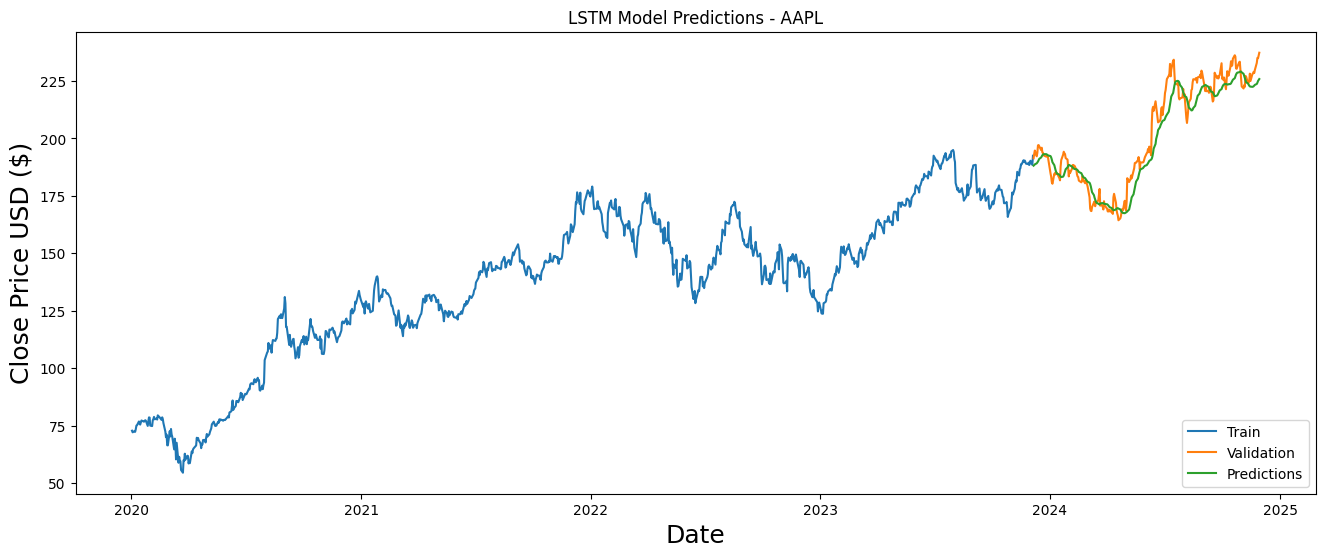


Processing stock: XOM
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1224
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0102
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0057
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0037
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0030
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0023
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0023
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
XOM - Root Mean Squared Error: 2.8835024442363575


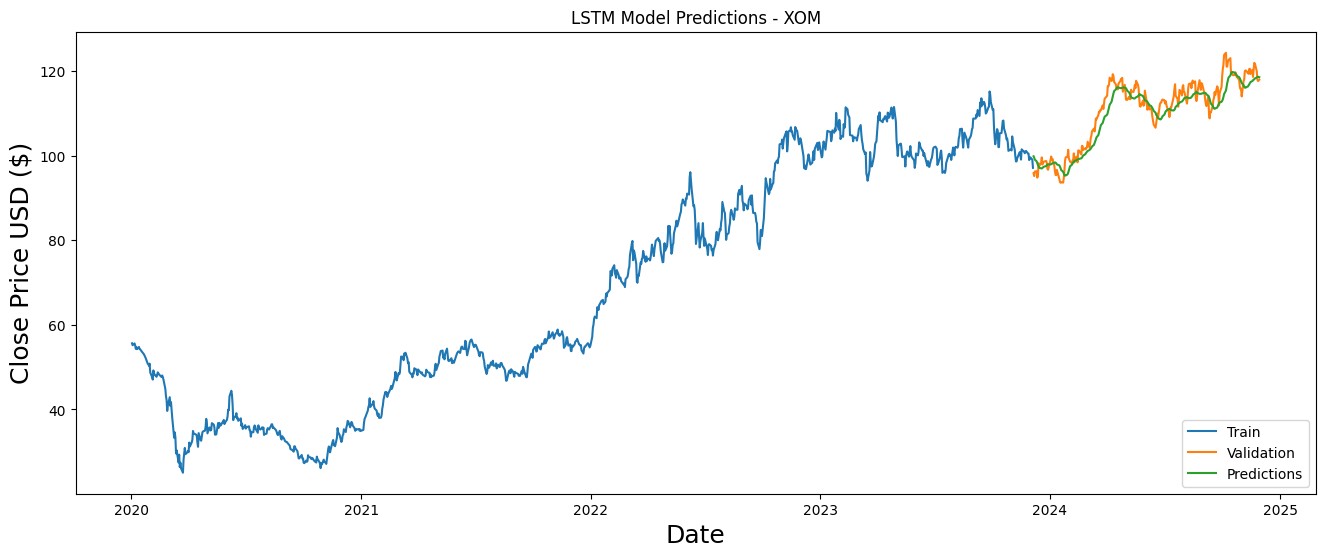


Processing stock: TSLA
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0766
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0076
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0063
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0045
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0044
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0038
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0041
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0043
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0031
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
TSLA - Root Mean Squared Error: 19.382005166431778


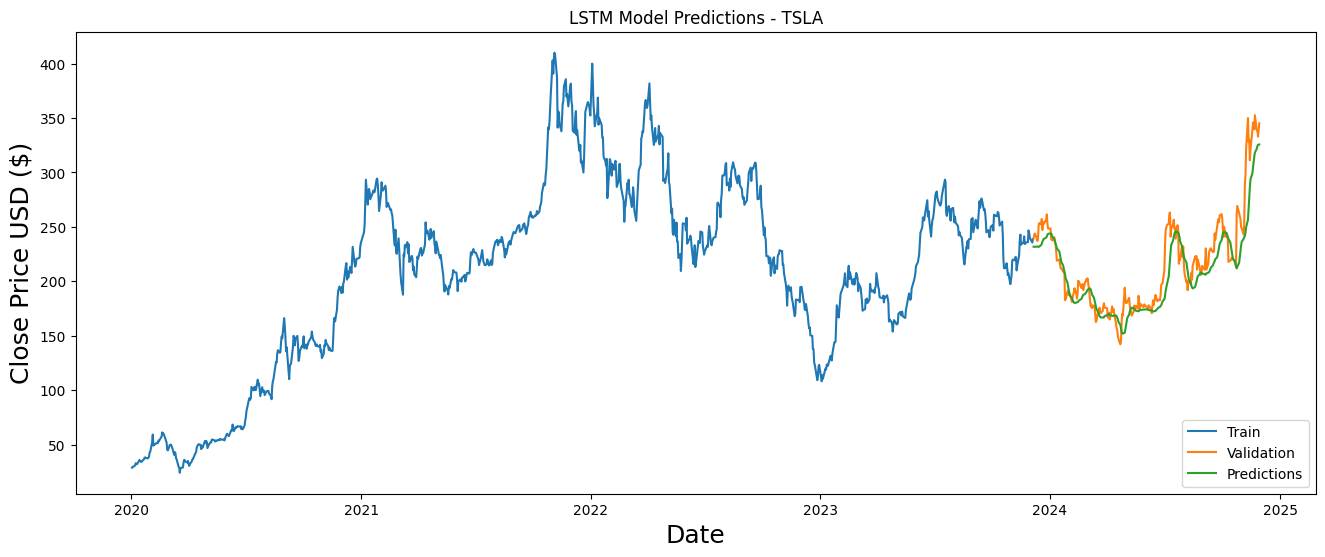


Processing stock: NEM
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0724
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0088
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0069
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0049
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0048
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0047
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0039
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0042
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0038
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
NEM - Root Mean Squared Error: 2.053494214510083


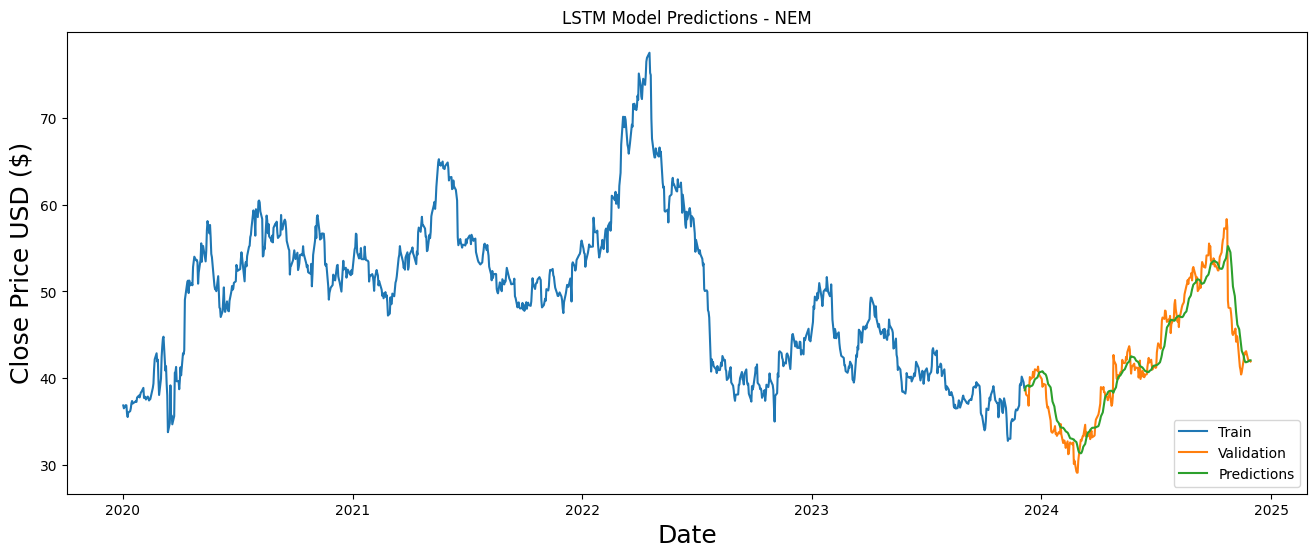

In [119]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Prepare LSTM Data
def prepare_lstm_data(data, lookback):
    """Prepare data for LSTM with lookback window."""
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])  # Lookback period for each input
        y.append(data[i])  # Next value to predict
    return np.array(X), np.array(y)

# Main Workflow
lookback = 60  # Lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]

        # Scale prices
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(clean_data[['Adj Close']])

        # Define training and testing data
        training_data_len = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:training_data_len]
        test_data = scaled_data[training_data_len - lookback:]

        # Prepare training data
        X_train, y_train = prepare_lstm_data(train_data, lookback)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # Build and Train the LSTM Model
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, batch_size=64, epochs=10)

        # Prepare testing data
        X_test, y_test = prepare_lstm_data(test_data, lookback)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # Make predictions
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
        print(f"{ticker} - Root Mean Squared Error: {rmse}")

        # Plot results
        train = clean_data[:training_data_len]
        valid = clean_data[training_data_len:]
        valid['Predictions'] = predictions
        
        plt.figure(figsize=(16, 6))
        plt.title(f"LSTM Model Predictions - {ticker}")
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Adj Close'], label='Train')
        plt.plot(valid[['Adj Close', 'Predictions']], label='Validation and Predictions')
        plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")


In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from datetime import datetime

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Prepare LSTM Data
def prepare_lstm_data(data, lookback):
    x_data, y_data = [], []
    for i in range(lookback, len(data)):
        x_data.append(data[i-lookback:i, 0])  # Lookback period for each input
        y_data.append(data[i, 0])            # Next value to predict
    return np.array(x_data), np.array(y_data)

# Objective Function for Bayesian Optimization
def objective(trial):
    # Hyperparameters to optimize
    lstm_units_1 = trial.suggest_int('lstm_units_1', 50, 200)
    lstm_units_2 = trial.suggest_int('lstm_units_2', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 10, 50)
    lookback = trial.suggest_int('lookback', 30, 120)

    # Prepare training and testing data
    x_train, y_train = prepare_lstm_data(train_data, lookback)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test, y_test = prepare_lstm_data(test_data, lookback)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Build the LSTM Model
    model = Sequential([
        LSTM(lstm_units_1, return_sequences=True, input_shape=(x_train.shape[1], 1)),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(
        x_train, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0
    )

    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)  # Inverse scaling
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scaling

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    return rmse

# Main Workflow
lookback = 60  # Initial lookback period (may be overridden by Optuna)
selected_stocks = ["AAPL"]  # Only optimizing for one stock for simplicity
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]

        # Extract prices and scale data
        data = clean_data[['Adj Close']].values
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)

        # Define training and testing data
        training_data_len = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:training_data_len]
        test_data = scaled_data[training_data_len - lookback:]

        # Run Bayesian Optimization
        print("Starting Bayesian Optimization...")
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=20)

        # Print best hyperparameters
        print("Best Hyperparameters:")
        print(study.best_params)

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")


[I 2024-12-08 18:25:27,731] A new study created in memory with name: no-name-e57eae1a-26c9-4116-8cf2-68b82900c1ef



Processing stock: AAPL
Starting Bayesian Optimization...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[I 2024-12-08 18:25:37,552] Trial 0 finished with value: 6.791981111535099 and parameters: {'lstm_units_1': 79, 'lstm_units_2': 84, 'dropout_rate': 0.2835860238919662, 'batch_size': 23, 'epochs': 26, 'lookback': 34}. Best is trial 0 with value: 6.791981111535099.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2024-12-08 18:25:48,154] Trial 1 finished with value: 7.698951139428499 and parameters: {'lstm_units_1': 127, 'lstm_units_2': 74, 'dropout_rate': 0.3127488771814525, 'batch_size': 50, 'epochs': 42, 'lookback': 78}. Best is trial 0 with value: 6.791981111535099.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[I 2024-12-08 18:26:02,139] Trial 2 finished with value: 6.130834441562351 and parameters: {'lstm_units_1': 69, 'lstm_units_2': 102, 'dropout_rate': 0.2968439634669039, 'batch_size': 23, 'epochs': 11, 'lookback': 117}. Best is trial 2 with value: 6.130834441562351.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2024-12-08 18:26:07,639] Trial 3 finished with value: 8.577345979919022 and parameters: {'lstm_units_1': 85, 'lstm_units_2': 49, 'dropout_rate': 0.35234796046798467, 'batch_size': 31, 'epochs': 32, 'lookback': 74}. Best is trial 2 with value: 6.130834441562351.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2024-12-08 18:26:17,064] Trial 4 finished with value: 10.755353765429705 and parameters: {'lstm_units_1': 194, 'lstm_units_2': 51, 'dropout_rate': 0.2523019033684294, 'batch_size': 36, 'epochs': 18, 'lookback': 106}. Best is trial 2 with value: 6.130834441562351.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-12-08 18:26:23,288] Trial 5 finished with value: 10.793253412755812 and parameters: {'lstm_units_1': 135, 'lstm_units_2': 107, 'dropout_rate': 0.48900967461909906, 'batch_size': 49, 'epochs': 19, 'lookback': 64}. Best is trial 2 with value: 6.130834441562351.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[I 2024-12-08 18:26:31,513] Trial 6 finished with value: 12.217881807391962 and parameters: {'lstm_units_1': 98, 'lstm_units_2': 79, 'dropout_rate': 0.46992974896389994, 'batch_size': 59, 'epochs': 43, 'lookback': 78}. Best is trial 2 with value: 6.130834441562351.


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


[I 2024-12-08 18:26:48,514] Trial 7 finished with value: 6.624183721577862 and parameters: {'lstm_units_1': 145, 'lstm_units_2': 127, 'dropout_rate': 0.38554114773508996, 'batch_size': 56, 'epochs': 33, 'lookback': 80}. Best is trial 2 with value: 6.130834441562351.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2024-12-08 18:27:08,430] Trial 8 finished with value: 7.358340986417893 and parameters: {'lstm_units_1': 97, 'lstm_units_2': 88, 'dropout_rate': 0.49285021573878207, 'batch_size': 19, 'epochs': 17, 'lookback': 102}. Best is trial 2 with value: 6.130834441562351.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-12-08 18:27:21,092] Trial 9 finished with value: 8.412231691989515 and parameters: {'lstm_units_1': 119, 'lstm_units_2': 68, 'dropout_rate': 0.356292417786629, 'batch_size': 16, 'epochs': 24, 'lookback': 91}. Best is trial 2 with value: 6.130834441562351.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


[I 2024-12-08 18:27:28,677] Trial 10 finished with value: 12.98160722566156 and parameters: {'lstm_units_1': 50, 'lstm_units_2': 107, 'dropout_rate': 0.109720691461272, 'batch_size': 29, 'epochs': 13, 'lookback': 120}. Best is trial 2 with value: 6.130834441562351.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2024-12-08 18:27:40,865] Trial 11 finished with value: 6.303761084438792 and parameters: {'lstm_units_1': 171, 'lstm_units_2': 127, 'dropout_rate': 0.19084302648682455, 'batch_size': 63, 'epochs': 35, 'lookback': 50}. Best is trial 2 with value: 6.130834441562351.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


[I 2024-12-08 18:27:46,625] Trial 12 finished with value: 9.55214332858077 and parameters: {'lstm_units_1': 176, 'lstm_units_2': 121, 'dropout_rate': 0.19348909988502316, 'batch_size': 44, 'epochs': 50, 'lookback': 47}. Best is trial 2 with value: 6.130834441562351.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-12-08 18:27:57,535] Trial 13 finished with value: 6.344711262115323 and parameters: {'lstm_units_1': 162, 'lstm_units_2': 105, 'dropout_rate': 0.18711670154191573, 'batch_size': 62, 'epochs': 38, 'lookback': 54}. Best is trial 2 with value: 6.130834441562351.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2024-12-08 18:28:06,863] Trial 14 finished with value: 7.054890097755971 and parameters: {'lstm_units_1': 53, 'lstm_units_2': 116, 'dropout_rate': 0.20794233380500168, 'batch_size': 42, 'epochs': 27, 'lookback': 32}. Best is trial 2 with value: 6.130834441562351.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[I 2024-12-08 18:28:46,481] Trial 15 finished with value: 6.113602072575448 and parameters: {'lstm_units_1': 193, 'lstm_units_2': 97, 'dropout_rate': 0.15953062676466437, 'batch_size': 26, 'epochs': 37, 'lookback': 120}. Best is trial 15 with value: 6.113602072575448.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


[I 2024-12-08 18:29:09,620] Trial 16 finished with value: 6.255947172376783 and parameters: {'lstm_units_1': 194, 'lstm_units_2': 94, 'dropout_rate': 0.12625647192982342, 'batch_size': 25, 'epochs': 12, 'lookback': 118}. Best is trial 15 with value: 6.113602072575448.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2024-12-08 18:29:22,391] Trial 17 finished with value: 10.653531477328348 and parameters: {'lstm_units_1': 111, 'lstm_units_2': 33, 'dropout_rate': 0.40739522711334514, 'batch_size': 35, 'epochs': 49, 'lookback': 107}. Best is trial 15 with value: 6.113602072575448.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2024-12-08 18:29:32,637] Trial 18 finished with value: 6.866534847754917 and parameters: {'lstm_units_1': 69, 'lstm_units_2': 98, 'dropout_rate': 0.14598632321825303, 'batch_size': 23, 'epochs': 39, 'lookback': 95}. Best is trial 15 with value: 6.113602072575448.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[I 2024-12-08 18:30:05,189] Trial 19 finished with value: 6.180196050987864 and parameters: {'lstm_units_1': 153, 'lstm_units_2': 64, 'dropout_rate': 0.2517511524488252, 'batch_size': 29, 'epochs': 29, 'lookback': 112}. Best is trial 15 with value: 6.113602072575448.


Best Hyperparameters:
{'lstm_units_1': 193, 'lstm_units_2': 97, 'dropout_rate': 0.15953062676466437, 'batch_size': 26, 'epochs': 37, 'lookback': 120}



Processing stock: AAPL
Epoch 1/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0558
Epoch 2/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0024
Epoch 3/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0017
Epoch 4/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0017
Epoch 5/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0017
Epoch 6/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0020
Epoch 7/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0016
Epoch 8/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0016
Epoch 9/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0016
Epoch 10/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0018
Epoch 11/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0014
Epoch 12/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0016
Epoch 13/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0015
Epoch 14/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0015
Epoch 15/37
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/

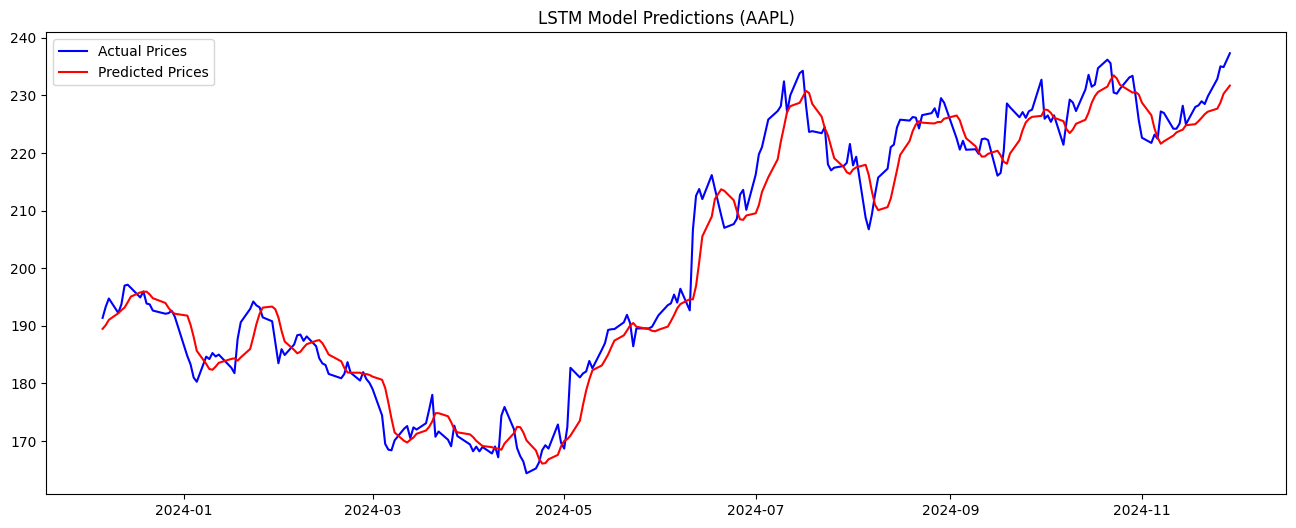

In [125]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import datetime

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Prepare LSTM Data
def prepare_lstm_data(data, lookback):
    x_data, y_data = [], []
    for i in range(lookback, len(data)):
        x_data.append(data[i-lookback:i, 0])  # Lookback period for each input
        y_data.append(data[i, 0])            # Next value to predict
    return np.array(x_data), np.array(y_data)

# Main Workflow
best_params = {
    'lstm_units_1': 193,
    'lstm_units_2': 97,
    'dropout_rate': 0.15953062676466437,
    'batch_size': 26,
    'epochs': 37,
    'lookback': 120
}
selected_stocks = ["AAPL"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"

        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]

        # Extract prices and scale data
        data = clean_data[['Adj Close']].values
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)

        # Define training and testing data
        lookback = best_params['lookback']
        training_data_len = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:training_data_len]
        test_data = scaled_data[training_data_len - lookback:]

        # Prepare training and testing data
        x_train, y_train = prepare_lstm_data(train_data, lookback)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test, y_test = prepare_lstm_data(test_data, lookback)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        # Build the final model
        model = Sequential([
            LSTM(best_params['lstm_units_1'], return_sequences=True, input_shape=(x_train.shape[1], 1)),
            Dropout(best_params['dropout_rate']),
            LSTM(best_params['lstm_units_2'], return_sequences=False),
            Dropout(best_params['dropout_rate']),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        model.fit(x_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'])

        # Make predictions
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(predictions)  # Inverse scaling
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scaling

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
        print(f"Final Model RMSE: {rmse}")

        # Plot predictions vs actuals
        plt.figure(figsize=(16, 6))
        plt.plot(clean_data.index[training_data_len:], y_test_actual, label="Actual Prices", color="blue")
        plt.plot(clean_data.index[training_data_len:], predictions, label="Predicted Prices", color="red")
        plt.title(f"LSTM Model Predictions ({ticker})")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



Processing stock: AAPL
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1068
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0064
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0042
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0031
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0026
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0025
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0022
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0024
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
AAPL - Root Mean Squared Error: 8.479963000592939


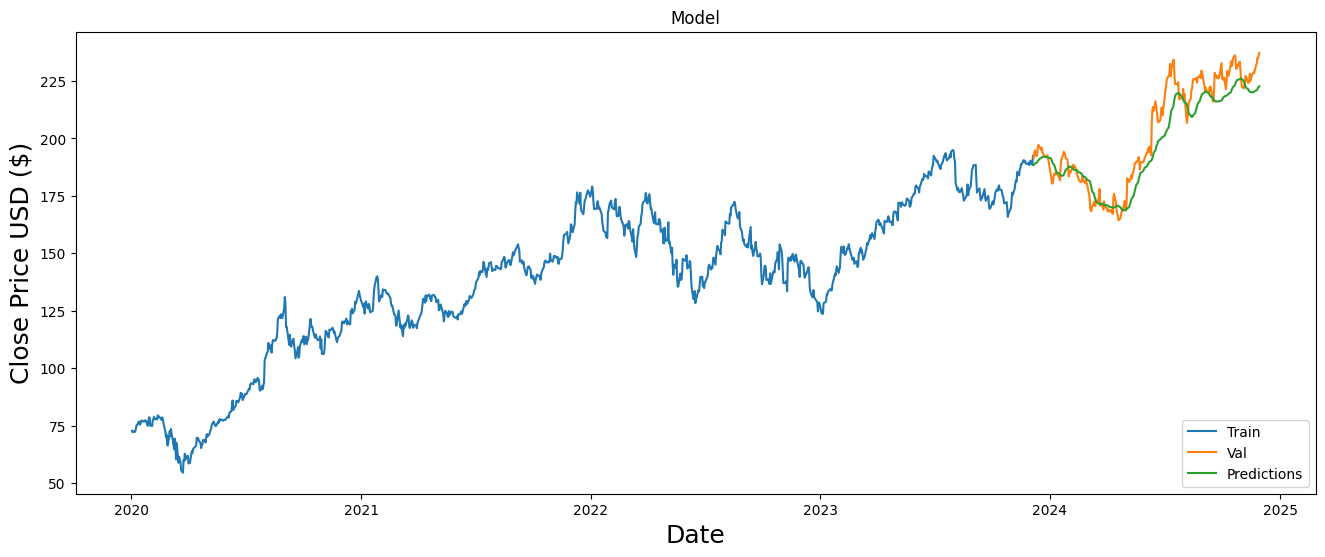


Processing stock: XOM
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1210
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0091
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0052
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0034
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0029
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
XOM - Root Mean Squared Error: 4.181844932827823


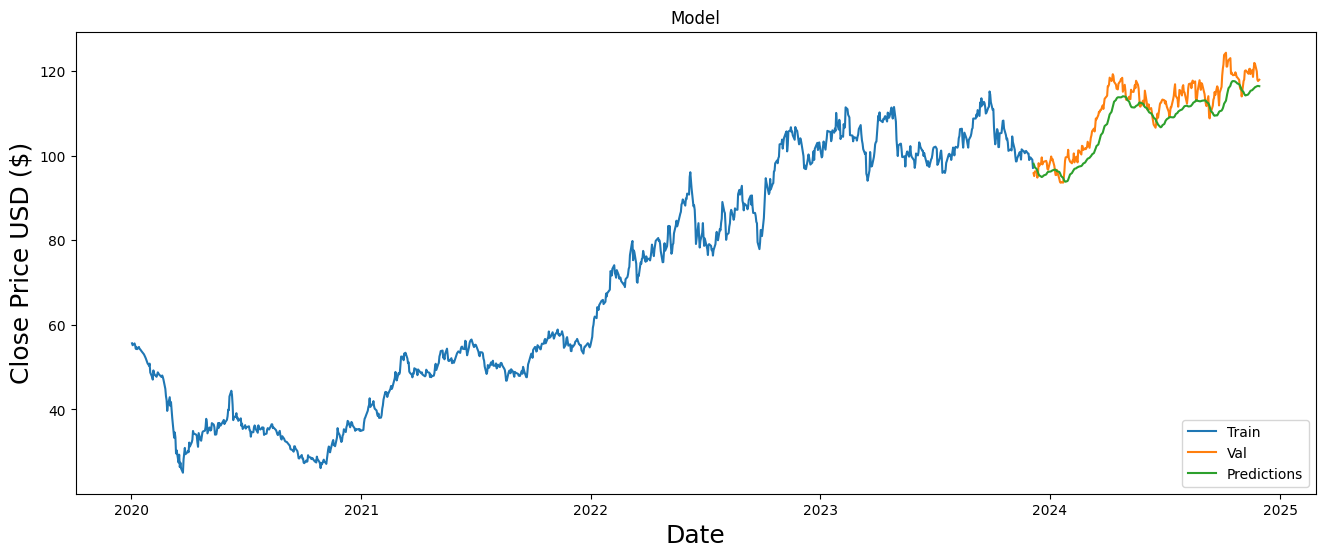


Processing stock: TSLA
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1128
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0090
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0069
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0050
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0047
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0050
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0041
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0037
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
TSLA - Root Mean Squared Error: 17.500917536228236


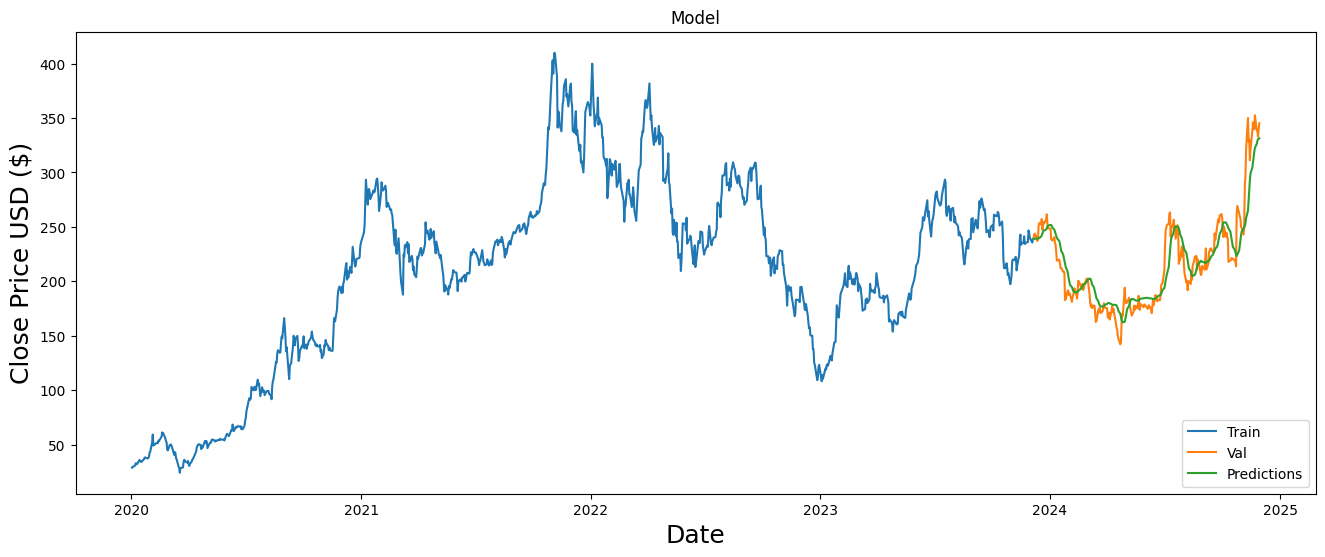


Processing stock: NEM
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0690
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0069
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0049
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0050
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0038
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0028
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0032
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
NEM - Root Mean Squared Error: 2.044279093971572


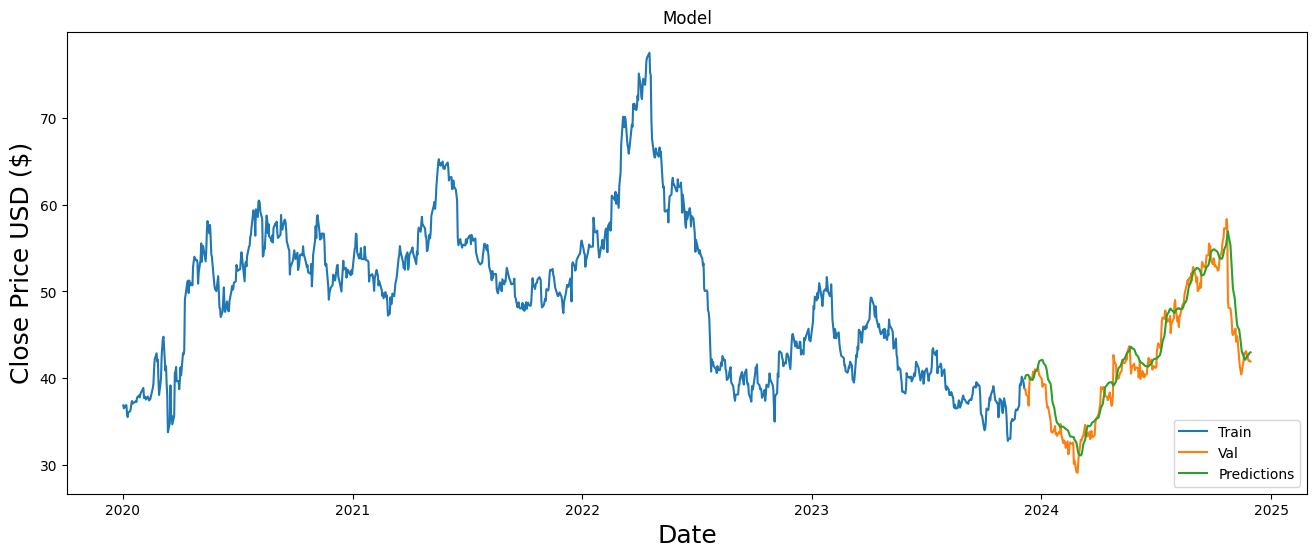

In [126]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import datetime

# Data Cleaning Function
def clean_stock_data(raw_data):
    raw_data = raw_data.iloc[2:].copy()  # Skip metadata rows
    raw_data.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw_data['Date'] = pd.to_datetime(raw_data['Date'], errors='coerce')
    raw_data = raw_data.dropna(subset=['Date']).reset_index(drop=True)

    # Convert numeric columns
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_cols:
        raw_data[col] = pd.to_numeric(raw_data[col], errors='coerce')

    # Drop rows with invalid numeric data
    raw_data = raw_data.dropna(subset=numeric_cols).reset_index(drop=True)
    raw_data.set_index('Date', inplace=True)  # Use 'Date' as the index
    return raw_data

# Prepare LSTM Data with Volume
def prepare_lstm_data(data, lookback):
    x_data, y_data = [], []
    for i in range(lookback, len(data)):
        x_data.append(data[i-lookback:i])  # Lookback period for each input
        y_data.append(data[i, 0])         # Next value to predict (Adj Close)
    return np.array(x_data), np.array(y_data)

# Main Workflow
lookback = 60  # Lookback period
selected_stocks = ["AAPL", "XOM", "TSLA", "NEM"]
data_folder = "SP500_Historical_Data"

for ticker in selected_stocks:
    try:
        print(f"\nProcessing stock: {ticker}")
        file_path = f"{data_folder}/{ticker}_adjusted.csv"
        
        # Load and clean data
        raw_data = pd.read_csv(file_path)
        clean_data = clean_stock_data(raw_data)

        # Filter dataset to start from 2020 onward
        clean_data = clean_data.loc["2020-01-01":]

        # Extract prices and volume, then scale data
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(clean_data[['Adj Close', 'Volume']])  # Scale both features

        # Define training and testing data
        training_data_len = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:training_data_len]
        test_data = scaled_data[training_data_len - lookback:]

        # Prepare training data
        x_train, y_train = prepare_lstm_data(train_data, lookback)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

        # Build and Train the LSTM Model
        model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, batch_size=64, epochs=10)

        # Prepare testing data
        x_test, y_test = prepare_lstm_data(test_data, lookback)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

        # Make predictions
        predictions = model.predict(x_test)
        predictions = scaler.inverse_transform(np.hstack([predictions, np.zeros((predictions.shape[0], 1))]))[:, 0]  # Inverse scaling for prices
        y_test = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))]))[:, 0]  # Inverse scaling for prices

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        print(f"{ticker} - Root Mean Squared Error: {rmse}")

        # Prepare data for plotting
        train = clean_data[:training_data_len]
        valid = clean_data[training_data_len:]
        valid['Predictions'] = predictions

        # Plot the data
        plt.figure(figsize=(16, 6))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Adj Close'], label='Train')
        plt.plot(valid[['Adj Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()

    except Exception as e:
        print(f"Failed to process {ticker}: {e}")
